In [199]:
# Importing data extraction libraries
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning, normalization and Regression libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.naive_bayes import MultinomialNB

import math


# TensorFlow Libraries

In [200]:
# Impoorting libraries for deep learning
import tensorflow as tf
from tensorflow import keras

# Ensure notebook doesnt use the entire ram
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
tf.debugging.disable_traceback_filtering()

1 Physical GPUs, 1 Logical GPUs


# Creating a Multi Activation Layer Function for Custom Model

In [201]:
# Define custom Layer
class MultiActivationLayer(keras.layers.Layer):
    '''
    Multiple Activation Layer
    
    A neural network layer in which every node has a different activation function applied
    '''
    
    def __init__(self, out_features, activations, **kwargs):
        super().__init__(**kwargs)
        self.out_features = out_features
        self.activations = activations
    
    def build(self, input_shape):
        self.w = tf.Variable(tf.random.normal([input_shape[-1], self.out_features]), name='w')
        self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
    
    @tf.function
    def call(self, inputs):
        z = tf.matmul(inputs, self.w) + self.b
        shape = tf.shape(z)[0]
        
        # Apply activation function to ouput features from nodes (columns) separately with different activation functions
        #, reshape to 2-D array and concatenate the results from each node in the same order
        nodes = [tf.reshape(self.activations[i%len(self.activations)](z[:,i]), (shape, 1)) for i in range(self.out_features)]
        z = tf.concat(nodes, 1)
        return z
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "out_features": self.out_features,
            "activations": self.activations,
        })
        return config

# Function to create other models 

In [202]:
# Define custom architecture using the new layer
def create_model(activations, option='multi', num_classes=1, dropout=False, dropout_rate=0.2, task='classification'):
    if task == 'classification' and num_classes < 2:
        raise RuntimeError()
        
    # Creating 5 Uniform models     
    if option == 'uniform':
        # Creating methods if the model does have dropout
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(20, activation=activations[0], name='layers_dense_2'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(15, activation=activations[0], name='layers_dense_3'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(10, activation=activations[0], name='layers_dense_4'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(5, activation=activations[0], name='layers_dense_5'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(num_classes, activation='softmax', name='layers_dense')
                ])
 
    elif option == 'multi':
        # Method to create a multi activation model
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    MultiActivationLayer(25, activations, name='layers_multi_1'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(20, activations, name='layers_multi_2'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(15, activations, name='layers_multi_3'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(10, activations, name='layers_multi_4'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(5, activations, name='layers_multi_5'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(num_classes, activation='softmax', name='layers_dense')
                ])

    elif option == 'sequential':
        if len(activations) < 5: raise RuntimeError()
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(20, activation=activations[1], name='layers_dense_2'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(15, activation=activations[2], name='layers_dense_3'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(10, activation=activations[3], name='layers_dense_4'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(5, activation=activations[4], name='layers_dense_5'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(num_classes, activation='softmax', name='layers_dense')
                ])

    else:
        raise RuntimeError()

In [203]:
# Define custom architecture using the new layer
def create_model_paper(activations, option='multi', num_classes=1, dropout=False, dropout_rate=0.3, task='classification'):
    if task == 'classification' and num_classes < 2:
        raise RuntimeError()
        
    # Creating 5 Uniform models     
    if option == 'uniform':
        # Creating methods if the model does have dropout
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    
                    keras.layers.Dense(30, activation=activations[0], name='layers_dense_1'),
                    keras.layers.Dropout(dropout_rate),
                    
                    keras.layers.Dense(15, activation=activations[0], name='layers_dense_2'),
                    keras.layers.Dropout(dropout_rate),
                    
                    keras.layers.Dense(30, activation=activations[0], name='layers_dense_3'),

                    keras.layers.Dense(1, activation=activations[0], name='layers_dense_4'),
                    
                    keras.layers.Dense(num_classes, activation='softmax', name='layers_dense')
                ])
 
    elif option == 'multi':
        # Method to create a multi activation model
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    
                    keras.layers.Dense(30, activation=activations[0], name='layers_dense_1'),
                    keras.layers.Dropout(dropout_rate),
                    
                    keras.layers.Dense(15, activation=activations[0], name='layers_dense_2'),
                    keras.layers.Dropout(dropout_rate),
                    
                    keras.layers.Dense(30, activation=activations[0], name='layers_dense_3'),

                    keras.layers.Dense(1, activation=activations[0], name='layers_dense_4'),
                    
                    keras.layers.Dense(num_classes, activation='softmax', name='layers_dense')
                ])
 

    elif option == 'sequential':
        if len(activations) < 5: raise RuntimeError()
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    
                    keras.layers.Dense(30, activation=activations[0], name='layers_dense_1'),
                    keras.layers.Dropout(dropout_rate),
                    
                    keras.layers.Dense(15, activation=activations[0], name='layers_dense_2'),
                    keras.layers.Dropout(dropout_rate),
                    
                    keras.layers.Dense(30, activation=activations[0], name='layers_dense_3'),

                    keras.layers.Dense(1, activation=activations[0], name='layers_dense_4'),
                    
                    keras.layers.Dense(num_classes, activation='softmax', name='layers_dense')
                ])
 

    else:
        raise RuntimeError()

In [204]:
# Define testing function for generating and running tests
def test(X, y, num_classes=None, X_test=None, y_test=None, task='classification', epochs=100, batch_size=32, task_name=''):
    
    Paper_MANN, Paper_MANN_Alt1, Paper_MANN_Alt2, Paper_MANN_Alt3 = None, None, None, None
    MANN, MANN_Alt1, MANN_Alt2, MANN_Alt3 = None, None, None, None
    UANN1, UANN2, UANN3, UANN4, UANN5 = None, None, None, None, None
    SANN =  None
    
    if X_test is None or y_test is None:
        # Split data into training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    else:
        X_train, y_train = X, y

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    train_dataset = train_dataset.shuffle(1000).batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
        
    
    if task == 'classification':
        if num_classes is None:
            raise RuntimeError()
            
        # Create our model
        MANN = create_model(activations=[tf.nn.sigmoid, 
                                         tf.nn.tanh, 
                                         tf.nn.leaky_relu, 
                                         tf.nn.elu, 
                                         tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        
        MANN.compile(optimizer=keras.optimizers.legacy.Nadam(),
                         loss=keras.losses.CategoricalCrossentropy(),
                         metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        MANN_Alt1 = create_model(activations=[tf.nn.tanh, 
                                              tf.nn.sigmoid, 
                                              tf.nn.leaky_relu, 
                                              tf.nn.elu, 
                                              tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        
        MANN_Alt1.compile(optimizer=keras.optimizers.legacy.Nadam(),
                         loss=keras.losses.CategoricalCrossentropy(),
                         metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        MANN_Alt2 = create_model(activations=[tf.nn.tanh,
                                              tf.nn.leaky_relu,
                                              tf.nn.sigmoid,
                                              tf.nn.elu,
                                              tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        MANN_Alt2.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        
        MANN_Alt3 = create_model(activations=[tf.nn.tanh, 
                                              tf.nn.leaky_relu, 
                                              tf.nn.elu, 
                                              tf.nn.sigmoid, 
                                              tf.nn.swish], 
                                 dropout=False, 
                                 num_classes=num_classes, 
                                 task=task)
        
        MANN_Alt3.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        # Paper Proposed Models
        
        # Create our model
        Paper_MANN = create_model_paper(activations=[tf.nn.sigmoid,
                                         tf.nn.leaky_relu, 
                                         tf.nn.elu, 
                                         tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        
        Paper_MANN.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        Paper_MANN_Alt1 = create_model_paper(activations=[tf.nn.leaky_relu, 
                                              tf.nn.sigmoid, 
                                              tf.nn.elu, 
                                              tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        Paper_MANN_Alt1.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        Paper_MANN_Alt2 = create_model_paper(activations=[tf.nn.leaky_relu,
                                              tf.nn.elu,
                                              tf.nn.sigmoid,
                                              tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        Paper_MANN_Alt2.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        Paper_MANN_Alt3 = create_model_paper(activations=[tf.nn.leaky_relu, 
                                              tf.nn.elu, 
                                              tf.nn.swish,
                                              tf.nn.sigmoid],
                                 dropout=False, 
                                 num_classes=num_classes, 
                                 task=task)
        
        Paper_MANN_Alt3.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        
        # Create uniform model for each activation function
        UANN1 = create_model(activations=[tf.nn.sigmoid], option='uniform', num_classes=num_classes, task=task)
        UANN1.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        UANN2 = create_model(activations=[tf.nn.tanh], option='uniform', num_classes=num_classes, task=task)
        UANN2.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        UANN3 = create_model(activations=[tf.nn.leaky_relu], option='uniform', num_classes=num_classes, task=task)
        UANN3.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        UANN4 = create_model(activations=[tf.nn.elu], option='uniform', num_classes=num_classes, task=task)
        UANN4.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        UANN5 = create_model(activations=[tf.nn.swish], option='uniform', num_classes=num_classes, task=task)
        UANN5.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        # Create sequential activation network
        SANN = create_model(activations=[tf.nn.swish, tf.nn.elu, tf.nn.leaky_relu, tf.nn.tanh, tf.nn.sigmoid], option='sequential', dropout=False, num_classes=num_classes, task=task)
        SANN.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])

        
    else:
        raise RuntimeError()
    
    # Fit the data to the models for a set number of epochs
    print("Training Multi Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/MANN.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    MANN_hist = MANN.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    MANN.save(filepath=f'./Models/250_Epochs/{task_name}/MANN', overwrite=True, save_format="keras")
    print('Training Complete')
    
    
    
    # Alternate MANN Model    
    path=f'./Models/Checkpoints/{task_name}/MANN_Alt1.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    MANN_Alt1_hist = MANN_Alt1.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    MANN_Alt1.save(filepath=f'./Models/250_Epochs/{task_name}/MANN_Alt1', overwrite=True, save_format="keras")
    print("Training Complete")
    

    # Alternate MANN Model 
    path=f'./Models/Checkpoints/{task_name}/MANN_Alt2.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    MANN_Alt2_hist = MANN_Alt2.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    MANN_Alt2.save(filepath=f'./Models/250_Epochs/{task_name}/MANN_Alt2', overwrite=True, save_format="keras")
    print("Training Compelte")
    
    
    
    
    
    
    path=f'./Models/Checkpoints/{task_name}/MANN_Alt3.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    MANN_Alt3_hist = MANN_Alt3.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    MANN_Alt3.save(filepath=f'./Models/250_Epochs/{task_name}/MANN_Alt3', overwrite=True, save_format="keras")
    
    
    # Training Paper proposed model
    print("Training Multi Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/Paper_MANN.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    Paper_MANN_hist = Paper_MANN.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    Paper_MANN.save(filepath=f'./Models/250_Epochs/{task_name}/Paper_MANN', overwrite=True, save_format="keras")
    print('Training Complete')
    
    
    print("\n\n************Training Multi Activation Neural Network...************")
    path=f'./Models/Checkpoints/{task_name}/Paper_MANN_Alt1.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    Paper_MANN_Alt1_hist = Paper_MANN_Alt1.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    Paper_MANN_Alt1.save(filepath=f'./Models/250_Epochs/{task_name}/Paper_MANN_Alt1', overwrite=True, save_format="keras")
    print('Training Complete')
    
    
    print("\n\n************Training Multi Activation Neural Network...************")
    path=f'./Models/Checkpoints/{task_name}/Paper_MANN_Alt2.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    Paper_MANN_Alt2_hist = Paper_MANN_Alt2.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    Paper_MANN_Alt2.save(filepath=f'./Models/250_Epochs/{task_name}/Paper_MANN_Alt2', overwrite=True, save_format="keras")
    print('Training Complete')
    
    
    print("\n\n************Training Multi Activation Neural Network************")
    path=f'./Models/Checkpoints/{task_name}/Paper_MANN_Alt3.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    Paper_MANN_Alt3_hist = Paper_MANN_Alt3.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    Paper_MANN_Alt3.save(filepath=f'./Models/250_Epochs/{task_name}/Paper_MANN_Alt3', overwrite=True, save_format="keras")
    print('Training Complete')
    
    
    
    
    print("\n\n************Training Sigmoid Uniform Activation Neural Network************")
    path=f'./Models/Checkpoints/{task_name}/Sigmoid.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN1_hist = UANN1.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    UANN1.save(filepath=f'./Models/250_Epochs/{task_name}/UniformSigmoid', overwrite=True, save_format="keras")
    print('Training Complete')

    
    print("\n\n************Training Tanh Uniform Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/Tanh.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN2_hist = UANN2.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    UANN2.save(filepath=f'./Models/250_Epochs/{task_name}/UniformTanh', overwrite=True, save_format="keras")
    print('Training Complete')

    
    print("\n\n************Training Leaky ReLU Uniform Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/LeakyReLU.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN3_hist = UANN3.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    UANN3.save(filepath=f'./Models/250_Epochs/{task_name}/UniformLeakyReLU', overwrite=True, save_format="keras")
    print('Training Complete')
    

    print("\n\n************Training ELU Uniform Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/ELU.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN4_hist = UANN4.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    UANN4.save(filepath=f'./Models/250_Epochs/{task_name}/UniformELU', overwrite=True, save_format="keras")
    print('Training Complete')

    print("\n\n************Training Swish Uniform Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/Swish.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN5_hist = UANN5.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    UANN5.save(filepath=f'./Models/250_Epochs/{task_name}/UniformSwish', overwrite=True, save_format="keras")
    print('Training Complete')

    print("\n\n************Training Sequential Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/Sequential.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    SANN_hist = SANN.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    SANN.save(filepath=f'./Models/250_Epochs/{task_name}/Sequential', overwrite=True, save_format="keras")
    print('Training Complete')

    # Create dictionaries to return for models and scores
    models = {
        'MANN': MANN,
        'MANN_Alt1': MANN_Alt1,
        'MANN_Alt2': MANN_Alt2,
        'MANN_Alt3': MANN_Alt3,
        'Paper_MANN': Paper_MANN,
        'Paper_MANN_Alt1': Paper_MANN_Alt1,
        'Paper_MANN_Alt2': Paper_MANN_Alt2,
        'Paper_MANN_Alt3': Paper_MANN_Alt3,
        'Sigmoid': UANN1,
        'Tanh': UANN2,
        'LeakyReLU': UANN3,
        'ELU': UANN4,
        'Swish': UANN5,
        'Sequential': SANN
    }
    
    histories = {
        'MANN': MANN_hist,
        'MANN_Alt1': MANN_Alt1_hist,
        'MANN_Alt2': MANN_Alt2_hist,
        'MANN_Alt3': MANN_Alt3_hist,
        'Paper_MANN': Paper_MANN_hist,
        'Paper_MANN_Alt1': Paper_MANN_Alt1_hist,
        'Paper_MANN_Alt2': Paper_MANN_Alt2_hist,
        'Paper_MANN_Alt3': Paper_MANN_Alt3_hist,
        'Sigmoid': UANN1_hist,
        'Tanh': UANN2_hist,
        'LeakyReLU': UANN3_hist,
        'ELU': UANN4_hist,
        'Swish': UANN5_hist,
        'Sequential': SANN_hist
    }

    return models, histories

# Pulling Heart Faliure data from the csv

In [205]:
# Load the data and split into testing and training for processing
HeartFailureData = pd.read_csv('./Datasets/heart.csv')

HeartFailureData.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

## Assigning features and targets from dataset

In [206]:
features = HeartFailureData.drop('HeartDisease', axis=1)
#npFeatures = np.array(features)

target = HeartFailureData['HeartDisease']
#npTarget = np.array(target)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

## Normalizing dataset

In [207]:
# Process and normalize the data
one_hot = OneHotEncoder(sparse_output=False)

# One-Hot encode categorical columns
X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]), columns=one_hot.get_feature_names_out()))
X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]), columns=one_hot.get_feature_names_out()))


# Drop the transformed columns and unneeded columns
X_train.drop(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis = 1, inplace=True)
X_test.drop(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis=1, inplace=True)


# Normalize numerical columns
scaler = StandardScaler()
X_train[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']]= scaler.fit_transform(X_train[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']])
X_test[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']] = scaler.transform(X_test[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']])

C:\Users\Jaskirat\AppData\Local\Temp\ipykernel_17868\3618434260.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]), columns=one_hot.get_feature_names_out()))
C:\Users\Jaskirat\AppData\Local\Temp\ipykernel_17868\3618434260.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]), columns=one_hot.get_feature_names_out()))


In [208]:
# One-Hot encode target labels
y_train = pd.DataFrame(data=one_hot.fit_transform(y_train.to_numpy().reshape(-1,1)), columns=one_hot.categories_)
y_test = pd.DataFrame(data=one_hot.transform(y_test.to_numpy().reshape(-1,1)), columns=one_hot.categories_)

In [209]:
# Create and fit all neural networks for evaluations

models, histories = test(X_train.to_numpy(), y_train.to_numpy(), X_test=X_test.to_numpy(), y_test=y_test.to_numpy(), num_classes=len(one_hot.categories_[0]), task='classification', epochs=250, batch_size=128, task_name='HeartFailure')

Training Multi Activation Neural Network...
Epoch 1/250
6/6 [==============================] - 3s 126ms/step - loss: 0.7045 - categorical_accuracy: 0.6172 - val_loss: 6.6852 - val_categorical_accuracy: 0.5815
Epoch 2/250
6/6 [==============================] - 0s 79ms/step - loss: 0.6936 - categorical_accuracy: 0.6349 - val_loss: 4.3045 - val_categorical_accuracy: 0.5924
Epoch 3/250
6/6 [==============================] - 0s 82ms/step - loss: 0.6442 - categorical_accuracy: 0.6621 - val_loss: 2.9514 - val_categorical_accuracy: 0.5978
Epoch 4/250
6/6 [==============================] - 1s 91ms/step - loss: 0.6411 - categorical_accuracy: 0.6730 - val_loss: 2.1168 - val_categorical_accuracy: 0.6250
Epoch 5/250
6/6 [==============================] - 1s 94ms/step - loss: 0.6089 - categorical_accuracy: 0.6907 - val_loss: 1.5976 - val_categorical_accuracy: 0.6522
Epoch 6/250
6/6 [==============================] - 0s 84ms/step - loss: 0.5925 - categorical_accuracy: 0.7044 - val_loss: 1.2604 - val_

6/6 [==============================] - 0s 43ms/step - loss: 0.4043 - categorical_accuracy: 0.8106 - val_loss: 0.5330 - val_categorical_accuracy: 0.7391
Epoch 51/250
6/6 [==============================] - 0s 36ms/step - loss: 0.4111 - categorical_accuracy: 0.7997 - val_loss: 0.5359 - val_categorical_accuracy: 0.7391
Epoch 52/250
6/6 [==============================] - 0s 36ms/step - loss: 0.4102 - categorical_accuracy: 0.8079 - val_loss: 0.5380 - val_categorical_accuracy: 0.7337
Epoch 53/250
6/6 [==============================] - 0s 34ms/step - loss: 0.3997 - categorical_accuracy: 0.8025 - val_loss: 0.5400 - val_categorical_accuracy: 0.7337
Epoch 54/250
6/6 [==============================] - 0s 42ms/step - loss: 0.4143 - categorical_accuracy: 0.7943 - val_loss: 0.5418 - val_categorical_accuracy: 0.7391
Epoch 55/250
6/6 [==============================] - 0s 37ms/step - loss: 0.4096 - categorical_accuracy: 0.8093 - val_loss: 0.5422 - val_categorical_accuracy: 0.7283
Epoch 56/250
6/6 [=====

Epoch 100/250
6/6 [==============================] - 0s 38ms/step - loss: 0.3496 - categorical_accuracy: 0.8460 - val_loss: 0.5783 - val_categorical_accuracy: 0.7174
Epoch 101/250
6/6 [==============================] - 0s 44ms/step - loss: 0.3632 - categorical_accuracy: 0.8311 - val_loss: 0.5792 - val_categorical_accuracy: 0.7228
Epoch 102/250
6/6 [==============================] - 0s 40ms/step - loss: 0.3454 - categorical_accuracy: 0.8338 - val_loss: 0.5815 - val_categorical_accuracy: 0.7174
Epoch 103/250
6/6 [==============================] - 0s 44ms/step - loss: 0.3604 - categorical_accuracy: 0.8365 - val_loss: 0.5818 - val_categorical_accuracy: 0.7228
Epoch 104/250
6/6 [==============================] - 0s 45ms/step - loss: 0.3560 - categorical_accuracy: 0.8283 - val_loss: 0.5824 - val_categorical_accuracy: 0.7228
Epoch 105/250
6/6 [==============================] - 0s 42ms/step - loss: 0.3386 - categorical_accuracy: 0.8433 - val_loss: 0.5857 - val_categorical_accuracy: 0.7228
Epoc

6/6 [==============================] - 0s 40ms/step - loss: 0.3261 - categorical_accuracy: 0.8610 - val_loss: 0.6207 - val_categorical_accuracy: 0.7228
Epoch 150/250
6/6 [==============================] - 0s 35ms/step - loss: 0.3409 - categorical_accuracy: 0.8433 - val_loss: 0.6180 - val_categorical_accuracy: 0.7228
Epoch 151/250
6/6 [==============================] - 0s 42ms/step - loss: 0.3207 - categorical_accuracy: 0.8638 - val_loss: 0.6161 - val_categorical_accuracy: 0.7228
Epoch 152/250
6/6 [==============================] - 0s 42ms/step - loss: 0.3262 - categorical_accuracy: 0.8501 - val_loss: 0.6139 - val_categorical_accuracy: 0.7228
Epoch 153/250
6/6 [==============================] - 0s 42ms/step - loss: 0.3268 - categorical_accuracy: 0.8569 - val_loss: 0.6135 - val_categorical_accuracy: 0.7228
Epoch 154/250
6/6 [==============================] - 0s 39ms/step - loss: 0.3093 - categorical_accuracy: 0.8610 - val_loss: 0.6173 - val_categorical_accuracy: 0.7228
Epoch 155/250
6/6 

6/6 [==============================] - 0s 38ms/step - loss: 0.2815 - categorical_accuracy: 0.8747 - val_loss: 0.6748 - val_categorical_accuracy: 0.7120
Epoch 199/250
6/6 [==============================] - 0s 35ms/step - loss: 0.2979 - categorical_accuracy: 0.8556 - val_loss: 0.6717 - val_categorical_accuracy: 0.7120
Epoch 200/250
6/6 [==============================] - 0s 35ms/step - loss: 0.2908 - categorical_accuracy: 0.8678 - val_loss: 0.6700 - val_categorical_accuracy: 0.7174
Epoch 201/250
6/6 [==============================] - 0s 33ms/step - loss: 0.2971 - categorical_accuracy: 0.8665 - val_loss: 0.6721 - val_categorical_accuracy: 0.7228
Epoch 202/250
6/6 [==============================] - 0s 33ms/step - loss: 0.2791 - categorical_accuracy: 0.8815 - val_loss: 0.6704 - val_categorical_accuracy: 0.7228
Epoch 203/250
6/6 [==============================] - 0s 34ms/step - loss: 0.2917 - categorical_accuracy: 0.8733 - val_loss: 0.6751 - val_categorical_accuracy: 0.7120
Epoch 204/250
6/6 

6/6 [==============================] - 0s 45ms/step - loss: 0.2821 - categorical_accuracy: 0.8651 - val_loss: 0.7276 - val_categorical_accuracy: 0.7065
Epoch 248/250
6/6 [==============================] - 0s 41ms/step - loss: 0.2730 - categorical_accuracy: 0.8896 - val_loss: 0.7362 - val_categorical_accuracy: 0.7065
Epoch 249/250
6/6 [==============================] - 0s 56ms/step - loss: 0.2860 - categorical_accuracy: 0.8733 - val_loss: 0.7407 - val_categorical_accuracy: 0.7120
Epoch 250/250
6/6 [==============================] - 0s 65ms/step - loss: 0.2817 - categorical_accuracy: 0.8638 - val_loss: 0.7358 - val_categorical_accuracy: 0.7065
INFO:tensorflow:Assets written to: ./Models/250_Epochs/HeartFailure/MANN\assets
Training Complete
Epoch 1/250
6/6 [==============================] - 3s 125ms/step - loss: 0.9552 - categorical_accuracy: 0.3420 - val_loss: 10.0528 - val_categorical_accuracy: 0.4293
Epoch 2/250
6/6 [==============================] - 0s 49ms/step - loss: 0.9097 - categ

6/6 [==============================] - 0s 62ms/step - loss: 0.4435 - categorical_accuracy: 0.8052 - val_loss: 0.5450 - val_categorical_accuracy: 0.7663
Epoch 47/250
6/6 [==============================] - 0s 75ms/step - loss: 0.4476 - categorical_accuracy: 0.8106 - val_loss: 0.5441 - val_categorical_accuracy: 0.7609
Epoch 48/250
6/6 [==============================] - 0s 56ms/step - loss: 0.4518 - categorical_accuracy: 0.7984 - val_loss: 0.5439 - val_categorical_accuracy: 0.7717
Epoch 49/250
6/6 [==============================] - 0s 49ms/step - loss: 0.4426 - categorical_accuracy: 0.8093 - val_loss: 0.5425 - val_categorical_accuracy: 0.7717
Epoch 50/250
6/6 [==============================] - 0s 65ms/step - loss: 0.4400 - categorical_accuracy: 0.8106 - val_loss: 0.5407 - val_categorical_accuracy: 0.7772
Epoch 51/250
6/6 [==============================] - 0s 49ms/step - loss: 0.4468 - categorical_accuracy: 0.7984 - val_loss: 0.5396 - val_categorical_accuracy: 0.7717
Epoch 52/250
6/6 [=====

Epoch 96/250
6/6 [==============================] - 0s 40ms/step - loss: 0.3735 - categorical_accuracy: 0.8392 - val_loss: 0.5449 - val_categorical_accuracy: 0.7717
Epoch 97/250
6/6 [==============================] - 0s 40ms/step - loss: 0.3805 - categorical_accuracy: 0.8379 - val_loss: 0.5476 - val_categorical_accuracy: 0.7717
Epoch 98/250
6/6 [==============================] - 0s 41ms/step - loss: 0.3760 - categorical_accuracy: 0.8392 - val_loss: 0.5499 - val_categorical_accuracy: 0.7717
Epoch 99/250
6/6 [==============================] - 0s 40ms/step - loss: 0.3815 - categorical_accuracy: 0.8311 - val_loss: 0.5553 - val_categorical_accuracy: 0.7663
Epoch 100/250
6/6 [==============================] - 0s 40ms/step - loss: 0.3727 - categorical_accuracy: 0.8433 - val_loss: 0.5576 - val_categorical_accuracy: 0.7663
Epoch 101/250
6/6 [==============================] - 0s 40ms/step - loss: 0.3866 - categorical_accuracy: 0.8270 - val_loss: 0.5593 - val_categorical_accuracy: 0.7663
Epoch 10

6/6 [==============================] - 0s 41ms/step - loss: 0.3170 - categorical_accuracy: 0.8747 - val_loss: 0.6018 - val_categorical_accuracy: 0.7391
Epoch 146/250
6/6 [==============================] - 0s 39ms/step - loss: 0.3168 - categorical_accuracy: 0.8529 - val_loss: 0.6028 - val_categorical_accuracy: 0.7283
Epoch 147/250
6/6 [==============================] - 0s 42ms/step - loss: 0.3480 - categorical_accuracy: 0.8515 - val_loss: 0.6020 - val_categorical_accuracy: 0.7228
Epoch 148/250
6/6 [==============================] - 0s 41ms/step - loss: 0.3173 - categorical_accuracy: 0.8665 - val_loss: 0.6053 - val_categorical_accuracy: 0.7337
Epoch 149/250
6/6 [==============================] - 0s 41ms/step - loss: 0.3085 - categorical_accuracy: 0.8760 - val_loss: 0.6111 - val_categorical_accuracy: 0.7337
Epoch 150/250
6/6 [==============================] - 0s 41ms/step - loss: 0.3083 - categorical_accuracy: 0.8774 - val_loss: 0.6123 - val_categorical_accuracy: 0.7283
Epoch 151/250
6/6 

6/6 [==============================] - 0s 33ms/step - loss: 0.2618 - categorical_accuracy: 0.8828 - val_loss: 0.6738 - val_categorical_accuracy: 0.6902
Epoch 195/250
6/6 [==============================] - 0s 32ms/step - loss: 0.2854 - categorical_accuracy: 0.8842 - val_loss: 0.6741 - val_categorical_accuracy: 0.6848
Epoch 196/250
6/6 [==============================] - 0s 37ms/step - loss: 0.2769 - categorical_accuracy: 0.8842 - val_loss: 0.6805 - val_categorical_accuracy: 0.6793
Epoch 197/250
6/6 [==============================] - 0s 37ms/step - loss: 0.2726 - categorical_accuracy: 0.8869 - val_loss: 0.6834 - val_categorical_accuracy: 0.6793
Epoch 198/250
6/6 [==============================] - 0s 36ms/step - loss: 0.2711 - categorical_accuracy: 0.8937 - val_loss: 0.6857 - val_categorical_accuracy: 0.6793
Epoch 199/250
6/6 [==============================] - 0s 40ms/step - loss: 0.2887 - categorical_accuracy: 0.8842 - val_loss: 0.6872 - val_categorical_accuracy: 0.6848
Epoch 200/250
6/6 

6/6 [==============================] - 0s 38ms/step - loss: 0.2511 - categorical_accuracy: 0.8992 - val_loss: 0.7445 - val_categorical_accuracy: 0.6576
Epoch 244/250
6/6 [==============================] - 0s 35ms/step - loss: 0.2424 - categorical_accuracy: 0.9087 - val_loss: 0.7390 - val_categorical_accuracy: 0.6685
Epoch 245/250
6/6 [==============================] - 0s 36ms/step - loss: 0.2663 - categorical_accuracy: 0.8924 - val_loss: 0.7331 - val_categorical_accuracy: 0.6739
Epoch 246/250
6/6 [==============================] - 0s 35ms/step - loss: 0.2679 - categorical_accuracy: 0.8978 - val_loss: 0.7404 - val_categorical_accuracy: 0.6793
Epoch 247/250
6/6 [==============================] - 0s 35ms/step - loss: 0.2717 - categorical_accuracy: 0.8910 - val_loss: 0.7393 - val_categorical_accuracy: 0.6739
Epoch 248/250
6/6 [==============================] - 0s 36ms/step - loss: 0.2515 - categorical_accuracy: 0.8951 - val_loss: 0.7374 - val_categorical_accuracy: 0.6848
Epoch 249/250
6/6 

6/6 [==============================] - 0s 55ms/step - loss: 0.4930 - categorical_accuracy: 0.7793 - val_loss: 0.5911 - val_categorical_accuracy: 0.7228
Epoch 43/250
6/6 [==============================] - 0s 51ms/step - loss: 0.4861 - categorical_accuracy: 0.7902 - val_loss: 0.5878 - val_categorical_accuracy: 0.7283
Epoch 44/250
6/6 [==============================] - 0s 48ms/step - loss: 0.4959 - categorical_accuracy: 0.7643 - val_loss: 0.5853 - val_categorical_accuracy: 0.7337
Epoch 45/250
6/6 [==============================] - 0s 47ms/step - loss: 0.4842 - categorical_accuracy: 0.7793 - val_loss: 0.5836 - val_categorical_accuracy: 0.7391
Epoch 46/250
6/6 [==============================] - 0s 45ms/step - loss: 0.4770 - categorical_accuracy: 0.7847 - val_loss: 0.5824 - val_categorical_accuracy: 0.7391
Epoch 47/250
6/6 [==============================] - 0s 45ms/step - loss: 0.4737 - categorical_accuracy: 0.7956 - val_loss: 0.5799 - val_categorical_accuracy: 0.7337
Epoch 48/250
6/6 [=====

Epoch 92/250
6/6 [==============================] - 0s 40ms/step - loss: 0.3942 - categorical_accuracy: 0.8297 - val_loss: 0.5750 - val_categorical_accuracy: 0.7391
Epoch 93/250
6/6 [==============================] - 0s 39ms/step - loss: 0.3943 - categorical_accuracy: 0.8379 - val_loss: 0.5747 - val_categorical_accuracy: 0.7446
Epoch 94/250
6/6 [==============================] - 0s 40ms/step - loss: 0.3905 - categorical_accuracy: 0.8351 - val_loss: 0.5733 - val_categorical_accuracy: 0.7500
Epoch 95/250
6/6 [==============================] - 0s 45ms/step - loss: 0.3855 - categorical_accuracy: 0.8324 - val_loss: 0.5740 - val_categorical_accuracy: 0.7500
Epoch 96/250
6/6 [==============================] - 0s 40ms/step - loss: 0.3861 - categorical_accuracy: 0.8324 - val_loss: 0.5756 - val_categorical_accuracy: 0.7500
Epoch 97/250
6/6 [==============================] - 0s 39ms/step - loss: 0.3891 - categorical_accuracy: 0.8283 - val_loss: 0.5770 - val_categorical_accuracy: 0.7500
Epoch 98/2

6/6 [==============================] - 0s 44ms/step - loss: 0.3389 - categorical_accuracy: 0.8501 - val_loss: 0.6841 - val_categorical_accuracy: 0.6902
Epoch 142/250
6/6 [==============================] - 0s 47ms/step - loss: 0.3431 - categorical_accuracy: 0.8501 - val_loss: 0.6864 - val_categorical_accuracy: 0.7011
Epoch 143/250
6/6 [==============================] - 0s 68ms/step - loss: 0.3255 - categorical_accuracy: 0.8556 - val_loss: 0.6890 - val_categorical_accuracy: 0.6902
Epoch 144/250
6/6 [==============================] - 0s 57ms/step - loss: 0.3321 - categorical_accuracy: 0.8501 - val_loss: 0.6929 - val_categorical_accuracy: 0.6902
Epoch 145/250
6/6 [==============================] - 0s 54ms/step - loss: 0.3364 - categorical_accuracy: 0.8542 - val_loss: 0.6969 - val_categorical_accuracy: 0.6902
Epoch 146/250
6/6 [==============================] - 0s 57ms/step - loss: 0.3082 - categorical_accuracy: 0.8706 - val_loss: 0.7011 - val_categorical_accuracy: 0.6902
Epoch 147/250
6/6 

6/6 [==============================] - 0s 38ms/step - loss: 0.3061 - categorical_accuracy: 0.8774 - val_loss: 0.7953 - val_categorical_accuracy: 0.6685
Epoch 191/250
6/6 [==============================] - 0s 53ms/step - loss: 0.3103 - categorical_accuracy: 0.8706 - val_loss: 0.7962 - val_categorical_accuracy: 0.6793
Epoch 192/250
6/6 [==============================] - 0s 48ms/step - loss: 0.2875 - categorical_accuracy: 0.8856 - val_loss: 0.7973 - val_categorical_accuracy: 0.6739
Epoch 193/250
6/6 [==============================] - 0s 47ms/step - loss: 0.2912 - categorical_accuracy: 0.8856 - val_loss: 0.7958 - val_categorical_accuracy: 0.6739
Epoch 194/250
6/6 [==============================] - 0s 47ms/step - loss: 0.2955 - categorical_accuracy: 0.8747 - val_loss: 0.7928 - val_categorical_accuracy: 0.6739
Epoch 195/250
6/6 [==============================] - 0s 44ms/step - loss: 0.2870 - categorical_accuracy: 0.8760 - val_loss: 0.8011 - val_categorical_accuracy: 0.6739
Epoch 196/250
6/6 

6/6 [==============================] - 0s 47ms/step - loss: 0.2667 - categorical_accuracy: 0.8760 - val_loss: 0.8815 - val_categorical_accuracy: 0.6576
Epoch 240/250
6/6 [==============================] - 0s 45ms/step - loss: 0.2539 - categorical_accuracy: 0.8978 - val_loss: 0.8842 - val_categorical_accuracy: 0.6522
Epoch 241/250
6/6 [==============================] - 0s 47ms/step - loss: 0.2742 - categorical_accuracy: 0.8828 - val_loss: 0.8923 - val_categorical_accuracy: 0.6467
Epoch 242/250
6/6 [==============================] - 0s 49ms/step - loss: 0.2423 - categorical_accuracy: 0.8992 - val_loss: 0.9000 - val_categorical_accuracy: 0.6359
Epoch 243/250
6/6 [==============================] - 0s 46ms/step - loss: 0.2514 - categorical_accuracy: 0.9074 - val_loss: 0.9003 - val_categorical_accuracy: 0.6413
Epoch 244/250
6/6 [==============================] - 0s 46ms/step - loss: 0.2545 - categorical_accuracy: 0.8896 - val_loss: 0.8994 - val_categorical_accuracy: 0.6413
Epoch 245/250
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.4709 - categorical_accuracy: 0.7779 - val_loss: 0.5835 - val_categorical_accuracy: 0.6902
Epoch 39/250
6/6 [==============================] - 0s 48ms/step - loss: 0.4592 - categorical_accuracy: 0.7956 - val_loss: 0.5835 - val_categorical_accuracy: 0.6848
Epoch 40/250
6/6 [==============================] - 0s 59ms/step - loss: 0.4513 - categorical_accuracy: 0.7970 - val_loss: 0.5826 - val_categorical_accuracy: 0.6793
Epoch 41/250
6/6 [==============================] - 0s 60ms/step - loss: 0.4545 - categorical_accuracy: 0.8011 - val_loss: 0.5813 - val_categorical_accuracy: 0.6793
Epoch 42/250
6/6 [==============================] - 0s 63ms/step - loss: 0.4408 - categorical_accuracy: 0.7956 - val_loss: 0.5802 - val_categorical_accuracy: 0.6793
Epoch 43/250
6/6 [==============================] - 0s 64ms/step - loss: 0.4424 - categorical_accuracy: 0.8038 - val_loss: 0.5799 - val_categorical_accuracy: 0.6848
Epoch 44/250
6/6 [=====

Epoch 88/250
6/6 [==============================] - 0s 50ms/step - loss: 0.3717 - categorical_accuracy: 0.8283 - val_loss: 0.5749 - val_categorical_accuracy: 0.7283
Epoch 89/250
6/6 [==============================] - 0s 47ms/step - loss: 0.3669 - categorical_accuracy: 0.8311 - val_loss: 0.5758 - val_categorical_accuracy: 0.7391
Epoch 90/250
6/6 [==============================] - 0s 45ms/step - loss: 0.3669 - categorical_accuracy: 0.8488 - val_loss: 0.5782 - val_categorical_accuracy: 0.7337
Epoch 91/250
6/6 [==============================] - 0s 48ms/step - loss: 0.3552 - categorical_accuracy: 0.8501 - val_loss: 0.5799 - val_categorical_accuracy: 0.7283
Epoch 92/250
6/6 [==============================] - 0s 55ms/step - loss: 0.3559 - categorical_accuracy: 0.8501 - val_loss: 0.5781 - val_categorical_accuracy: 0.7391
Epoch 93/250
6/6 [==============================] - 0s 48ms/step - loss: 0.3619 - categorical_accuracy: 0.8420 - val_loss: 0.5763 - val_categorical_accuracy: 0.7391
Epoch 94/2

6/6 [==============================] - 0s 46ms/step - loss: 0.3119 - categorical_accuracy: 0.8624 - val_loss: 0.6233 - val_categorical_accuracy: 0.7446
Epoch 138/250
6/6 [==============================] - 0s 46ms/step - loss: 0.3163 - categorical_accuracy: 0.8515 - val_loss: 0.6250 - val_categorical_accuracy: 0.7446
Epoch 139/250
6/6 [==============================] - 0s 55ms/step - loss: 0.3098 - categorical_accuracy: 0.8529 - val_loss: 0.6240 - val_categorical_accuracy: 0.7391
Epoch 140/250
6/6 [==============================] - 0s 56ms/step - loss: 0.3095 - categorical_accuracy: 0.8610 - val_loss: 0.6248 - val_categorical_accuracy: 0.7446
Epoch 141/250
6/6 [==============================] - 0s 47ms/step - loss: 0.3004 - categorical_accuracy: 0.8638 - val_loss: 0.6276 - val_categorical_accuracy: 0.7500
Epoch 142/250
6/6 [==============================] - 0s 57ms/step - loss: 0.2938 - categorical_accuracy: 0.8678 - val_loss: 0.6311 - val_categorical_accuracy: 0.7446
Epoch 143/250
6/6 

6/6 [==============================] - 0s 42ms/step - loss: 0.2751 - categorical_accuracy: 0.8774 - val_loss: 0.7258 - val_categorical_accuracy: 0.7120
Epoch 187/250
6/6 [==============================] - 0s 43ms/step - loss: 0.2701 - categorical_accuracy: 0.8815 - val_loss: 0.7261 - val_categorical_accuracy: 0.7120
Epoch 188/250
6/6 [==============================] - 0s 50ms/step - loss: 0.2483 - categorical_accuracy: 0.8937 - val_loss: 0.7330 - val_categorical_accuracy: 0.7120
Epoch 189/250
6/6 [==============================] - 0s 46ms/step - loss: 0.2583 - categorical_accuracy: 0.8937 - val_loss: 0.7349 - val_categorical_accuracy: 0.7228
Epoch 190/250
6/6 [==============================] - 0s 49ms/step - loss: 0.2743 - categorical_accuracy: 0.8815 - val_loss: 0.7387 - val_categorical_accuracy: 0.7228
Epoch 191/250
6/6 [==============================] - 0s 46ms/step - loss: 0.2540 - categorical_accuracy: 0.8978 - val_loss: 0.7418 - val_categorical_accuracy: 0.7228
Epoch 192/250
6/6 

6/6 [==============================] - 0s 44ms/step - loss: 0.2473 - categorical_accuracy: 0.9019 - val_loss: 0.7827 - val_categorical_accuracy: 0.7228
Epoch 236/250
6/6 [==============================] - 0s 44ms/step - loss: 0.2182 - categorical_accuracy: 0.9142 - val_loss: 0.7839 - val_categorical_accuracy: 0.7337
Epoch 237/250
6/6 [==============================] - 0s 45ms/step - loss: 0.2474 - categorical_accuracy: 0.8965 - val_loss: 0.7940 - val_categorical_accuracy: 0.7337
Epoch 238/250
6/6 [==============================] - 0s 44ms/step - loss: 0.2380 - categorical_accuracy: 0.9087 - val_loss: 0.8013 - val_categorical_accuracy: 0.7283
Epoch 239/250
6/6 [==============================] - 0s 44ms/step - loss: 0.2202 - categorical_accuracy: 0.9074 - val_loss: 0.8068 - val_categorical_accuracy: 0.7174
Epoch 240/250
6/6 [==============================] - 0s 45ms/step - loss: 0.2364 - categorical_accuracy: 0.9046 - val_loss: 0.8111 - val_categorical_accuracy: 0.7228
Epoch 241/250
6/6 

Epoch 34/250
6/6 [==============================] - 0s 26ms/step - loss: 0.6851 - categorical_accuracy: 0.5463 - val_loss: 0.6785 - val_categorical_accuracy: 0.5815
Epoch 35/250
6/6 [==============================] - 0s 18ms/step - loss: 0.6841 - categorical_accuracy: 0.5463 - val_loss: 0.6772 - val_categorical_accuracy: 0.5815
Epoch 36/250
6/6 [==============================] - 0s 21ms/step - loss: 0.6828 - categorical_accuracy: 0.5463 - val_loss: 0.6754 - val_categorical_accuracy: 0.5815
Epoch 37/250
6/6 [==============================] - 0s 25ms/step - loss: 0.6801 - categorical_accuracy: 0.5463 - val_loss: 0.6733 - val_categorical_accuracy: 0.5815
Epoch 38/250
6/6 [==============================] - 0s 22ms/step - loss: 0.6779 - categorical_accuracy: 0.5463 - val_loss: 0.6709 - val_categorical_accuracy: 0.5815
Epoch 39/250
6/6 [==============================] - 0s 24ms/step - loss: 0.6761 - categorical_accuracy: 0.5463 - val_loss: 0.6683 - val_categorical_accuracy: 0.5815
Epoch 40/2

Epoch 84/250
6/6 [==============================] - 0s 18ms/step - loss: 0.5790 - categorical_accuracy: 0.7766 - val_loss: 0.5953 - val_categorical_accuracy: 0.7120
Epoch 85/250
6/6 [==============================] - 0s 19ms/step - loss: 0.5762 - categorical_accuracy: 0.7793 - val_loss: 0.5946 - val_categorical_accuracy: 0.7065
Epoch 86/250
6/6 [==============================] - 0s 18ms/step - loss: 0.5755 - categorical_accuracy: 0.7807 - val_loss: 0.5938 - val_categorical_accuracy: 0.7120
Epoch 87/250
6/6 [==============================] - 0s 18ms/step - loss: 0.5735 - categorical_accuracy: 0.7834 - val_loss: 0.5932 - val_categorical_accuracy: 0.7120
Epoch 88/250
6/6 [==============================] - 0s 21ms/step - loss: 0.5738 - categorical_accuracy: 0.7807 - val_loss: 0.5927 - val_categorical_accuracy: 0.7120
Epoch 89/250
6/6 [==============================] - 0s 22ms/step - loss: 0.5697 - categorical_accuracy: 0.7943 - val_loss: 0.5921 - val_categorical_accuracy: 0.7174
Epoch 90/2

6/6 [==============================] - 0s 27ms/step - loss: 0.5354 - categorical_accuracy: 0.7861 - val_loss: 0.5735 - val_categorical_accuracy: 0.7120
Epoch 134/250
6/6 [==============================] - 0s 34ms/step - loss: 0.5370 - categorical_accuracy: 0.7725 - val_loss: 0.5730 - val_categorical_accuracy: 0.7120
Epoch 135/250
6/6 [==============================] - 0s 36ms/step - loss: 0.5390 - categorical_accuracy: 0.7793 - val_loss: 0.5728 - val_categorical_accuracy: 0.7120
Epoch 136/250
6/6 [==============================] - 0s 20ms/step - loss: 0.5399 - categorical_accuracy: 0.7793 - val_loss: 0.5724 - val_categorical_accuracy: 0.7065
Epoch 137/250
6/6 [==============================] - 0s 19ms/step - loss: 0.5308 - categorical_accuracy: 0.7875 - val_loss: 0.5719 - val_categorical_accuracy: 0.7065
Epoch 138/250
6/6 [==============================] - 0s 37ms/step - loss: 0.5314 - categorical_accuracy: 0.7820 - val_loss: 0.5716 - val_categorical_accuracy: 0.7065
Epoch 139/250
6/6 

6/6 [==============================] - 0s 15ms/step - loss: 0.5163 - categorical_accuracy: 0.7834 - val_loss: 0.5638 - val_categorical_accuracy: 0.7174
Epoch 183/250
6/6 [==============================] - 0s 20ms/step - loss: 0.5150 - categorical_accuracy: 0.7807 - val_loss: 0.5634 - val_categorical_accuracy: 0.7120
Epoch 184/250
6/6 [==============================] - 0s 20ms/step - loss: 0.5150 - categorical_accuracy: 0.7834 - val_loss: 0.5631 - val_categorical_accuracy: 0.7120
Epoch 185/250
6/6 [==============================] - 0s 13ms/step - loss: 0.5163 - categorical_accuracy: 0.7861 - val_loss: 0.5633 - val_categorical_accuracy: 0.7174
Epoch 186/250
6/6 [==============================] - 0s 16ms/step - loss: 0.5117 - categorical_accuracy: 0.7888 - val_loss: 0.5635 - val_categorical_accuracy: 0.7174
Epoch 187/250
6/6 [==============================] - 0s 15ms/step - loss: 0.5131 - categorical_accuracy: 0.7888 - val_loss: 0.5637 - val_categorical_accuracy: 0.7174
Epoch 188/250
6/6 

6/6 [==============================] - 0s 17ms/step - loss: 0.5028 - categorical_accuracy: 0.7902 - val_loss: 0.5612 - val_categorical_accuracy: 0.7174
Epoch 232/250
6/6 [==============================] - 0s 25ms/step - loss: 0.5034 - categorical_accuracy: 0.7875 - val_loss: 0.5608 - val_categorical_accuracy: 0.7174
Epoch 233/250
6/6 [==============================] - 0s 27ms/step - loss: 0.5081 - categorical_accuracy: 0.7725 - val_loss: 0.5605 - val_categorical_accuracy: 0.7174
Epoch 234/250
6/6 [==============================] - 0s 23ms/step - loss: 0.5090 - categorical_accuracy: 0.7752 - val_loss: 0.5603 - val_categorical_accuracy: 0.7174
Epoch 235/250
6/6 [==============================] - 0s 26ms/step - loss: 0.5133 - categorical_accuracy: 0.7738 - val_loss: 0.5600 - val_categorical_accuracy: 0.7174
Epoch 236/250
6/6 [==============================] - 0s 17ms/step - loss: 0.4985 - categorical_accuracy: 0.7902 - val_loss: 0.5601 - val_categorical_accuracy: 0.7174
Epoch 237/250
6/6 

6/6 [==============================] - 0s 25ms/step - loss: 0.5150 - categorical_accuracy: 0.7807 - val_loss: 0.5559 - val_categorical_accuracy: 0.7337
Epoch 30/250
6/6 [==============================] - 0s 23ms/step - loss: 0.4978 - categorical_accuracy: 0.7847 - val_loss: 0.5536 - val_categorical_accuracy: 0.7337
Epoch 31/250
6/6 [==============================] - 0s 24ms/step - loss: 0.4993 - categorical_accuracy: 0.7820 - val_loss: 0.5515 - val_categorical_accuracy: 0.7337
Epoch 32/250
6/6 [==============================] - 0s 25ms/step - loss: 0.5074 - categorical_accuracy: 0.7657 - val_loss: 0.5481 - val_categorical_accuracy: 0.7337
Epoch 33/250
6/6 [==============================] - 0s 26ms/step - loss: 0.5039 - categorical_accuracy: 0.7698 - val_loss: 0.5454 - val_categorical_accuracy: 0.7283
Epoch 34/250
6/6 [==============================] - 0s 22ms/step - loss: 0.4972 - categorical_accuracy: 0.7752 - val_loss: 0.5439 - val_categorical_accuracy: 0.7337
Epoch 35/250
6/6 [=====

Epoch 79/250
6/6 [==============================] - 0s 21ms/step - loss: 0.4612 - categorical_accuracy: 0.7861 - val_loss: 0.5178 - val_categorical_accuracy: 0.7500
Epoch 80/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4818 - categorical_accuracy: 0.7929 - val_loss: 0.5170 - val_categorical_accuracy: 0.7500
Epoch 81/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4633 - categorical_accuracy: 0.7970 - val_loss: 0.5171 - val_categorical_accuracy: 0.7500
Epoch 82/250
6/6 [==============================] - 0s 24ms/step - loss: 0.4665 - categorical_accuracy: 0.7916 - val_loss: 0.5160 - val_categorical_accuracy: 0.7500
Epoch 83/250
6/6 [==============================] - 0s 18ms/step - loss: 0.4543 - categorical_accuracy: 0.7970 - val_loss: 0.5166 - val_categorical_accuracy: 0.7500
Epoch 84/250
6/6 [==============================] - 0s 19ms/step - loss: 0.4628 - categorical_accuracy: 0.7956 - val_loss: 0.5168 - val_categorical_accuracy: 0.7500
Epoch 85/2

6/6 [==============================] - 0s 16ms/step - loss: 0.4552 - categorical_accuracy: 0.7834 - val_loss: 0.5092 - val_categorical_accuracy: 0.7500
Epoch 129/250
6/6 [==============================] - 0s 28ms/step - loss: 0.4640 - categorical_accuracy: 0.7956 - val_loss: 0.5084 - val_categorical_accuracy: 0.7500
Epoch 130/250
6/6 [==============================] - 0s 20ms/step - loss: 0.4692 - categorical_accuracy: 0.8011 - val_loss: 0.5086 - val_categorical_accuracy: 0.7500
Epoch 131/250
6/6 [==============================] - 0s 23ms/step - loss: 0.4676 - categorical_accuracy: 0.7902 - val_loss: 0.5084 - val_categorical_accuracy: 0.7500
Epoch 132/250
6/6 [==============================] - 0s 26ms/step - loss: 0.4612 - categorical_accuracy: 0.7997 - val_loss: 0.5074 - val_categorical_accuracy: 0.7500
Epoch 133/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4613 - categorical_accuracy: 0.7902 - val_loss: 0.5089 - val_categorical_accuracy: 0.7500
Epoch 134/250
6/6 

6/6 [==============================] - 0s 10ms/step - loss: 0.4582 - categorical_accuracy: 0.7888 - val_loss: 0.5033 - val_categorical_accuracy: 0.7609
Epoch 178/250
6/6 [==============================] - 0s 11ms/step - loss: 0.4534 - categorical_accuracy: 0.7875 - val_loss: 0.5020 - val_categorical_accuracy: 0.7609
Epoch 179/250
6/6 [==============================] - 0s 11ms/step - loss: 0.4534 - categorical_accuracy: 0.8079 - val_loss: 0.5016 - val_categorical_accuracy: 0.7609
Epoch 180/250
6/6 [==============================] - 0s 15ms/step - loss: 0.4548 - categorical_accuracy: 0.8052 - val_loss: 0.5021 - val_categorical_accuracy: 0.7609
Epoch 181/250
6/6 [==============================] - 0s 14ms/step - loss: 0.4465 - categorical_accuracy: 0.8011 - val_loss: 0.5032 - val_categorical_accuracy: 0.7554
Epoch 182/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4495 - categorical_accuracy: 0.8093 - val_loss: 0.5041 - val_categorical_accuracy: 0.7554
Epoch 183/250
6/6 

6/6 [==============================] - 0s 16ms/step - loss: 0.4643 - categorical_accuracy: 0.7997 - val_loss: 0.5049 - val_categorical_accuracy: 0.7554
Epoch 227/250
6/6 [==============================] - 0s 17ms/step - loss: 0.4518 - categorical_accuracy: 0.7997 - val_loss: 0.5026 - val_categorical_accuracy: 0.7609
Epoch 228/250
6/6 [==============================] - 0s 11ms/step - loss: 0.4528 - categorical_accuracy: 0.7997 - val_loss: 0.5027 - val_categorical_accuracy: 0.7609
Epoch 229/250
6/6 [==============================] - 0s 17ms/step - loss: 0.4525 - categorical_accuracy: 0.8038 - val_loss: 0.5023 - val_categorical_accuracy: 0.7609
Epoch 230/250
6/6 [==============================] - 0s 19ms/step - loss: 0.4580 - categorical_accuracy: 0.7875 - val_loss: 0.5025 - val_categorical_accuracy: 0.7554
Epoch 231/250
6/6 [==============================] - 0s 19ms/step - loss: 0.4492 - categorical_accuracy: 0.8079 - val_loss: 0.5035 - val_categorical_accuracy: 0.7554
Epoch 232/250
6/6 

6/6 [==============================] - 0s 21ms/step - loss: 0.5322 - categorical_accuracy: 0.7698 - val_loss: 0.5405 - val_categorical_accuracy: 0.6902
Epoch 25/250
6/6 [==============================] - 0s 21ms/step - loss: 0.5198 - categorical_accuracy: 0.7807 - val_loss: 0.5384 - val_categorical_accuracy: 0.6957
Epoch 26/250
6/6 [==============================] - 0s 32ms/step - loss: 0.5138 - categorical_accuracy: 0.7834 - val_loss: 0.5354 - val_categorical_accuracy: 0.7011
Epoch 27/250
6/6 [==============================] - 0s 26ms/step - loss: 0.5065 - categorical_accuracy: 0.7875 - val_loss: 0.5326 - val_categorical_accuracy: 0.6957
Epoch 28/250
6/6 [==============================] - 0s 42ms/step - loss: 0.5094 - categorical_accuracy: 0.7834 - val_loss: 0.5306 - val_categorical_accuracy: 0.6957
Epoch 29/250
6/6 [==============================] - 0s 40ms/step - loss: 0.5006 - categorical_accuracy: 0.7766 - val_loss: 0.5284 - val_categorical_accuracy: 0.7011
Epoch 30/250
6/6 [=====

Epoch 74/250
6/6 [==============================] - 0s 20ms/step - loss: 0.4788 - categorical_accuracy: 0.7902 - val_loss: 0.5146 - val_categorical_accuracy: 0.7446
Epoch 75/250
6/6 [==============================] - 0s 28ms/step - loss: 0.4730 - categorical_accuracy: 0.7929 - val_loss: 0.5142 - val_categorical_accuracy: 0.7391
Epoch 76/250
6/6 [==============================] - 0s 25ms/step - loss: 0.4772 - categorical_accuracy: 0.7902 - val_loss: 0.5139 - val_categorical_accuracy: 0.7337
Epoch 77/250
6/6 [==============================] - 0s 26ms/step - loss: 0.4698 - categorical_accuracy: 0.7984 - val_loss: 0.5138 - val_categorical_accuracy: 0.7337
Epoch 78/250
6/6 [==============================] - 0s 22ms/step - loss: 0.4650 - categorical_accuracy: 0.7970 - val_loss: 0.5136 - val_categorical_accuracy: 0.7337
Epoch 79/250
6/6 [==============================] - 0s 23ms/step - loss: 0.4765 - categorical_accuracy: 0.7902 - val_loss: 0.5134 - val_categorical_accuracy: 0.7337
Epoch 80/2

6/6 [==============================] - 0s 16ms/step - loss: 0.4582 - categorical_accuracy: 0.7997 - val_loss: 0.5091 - val_categorical_accuracy: 0.7337
Epoch 124/250
6/6 [==============================] - 0s 20ms/step - loss: 0.4525 - categorical_accuracy: 0.8106 - val_loss: 0.5093 - val_categorical_accuracy: 0.7337
Epoch 125/250
6/6 [==============================] - 0s 18ms/step - loss: 0.4541 - categorical_accuracy: 0.8038 - val_loss: 0.5094 - val_categorical_accuracy: 0.7337
Epoch 126/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4490 - categorical_accuracy: 0.7807 - val_loss: 0.5097 - val_categorical_accuracy: 0.7337
Epoch 127/250
6/6 [==============================] - 0s 18ms/step - loss: 0.4583 - categorical_accuracy: 0.7956 - val_loss: 0.5097 - val_categorical_accuracy: 0.7337
Epoch 128/250
6/6 [==============================] - 0s 17ms/step - loss: 0.4662 - categorical_accuracy: 0.7970 - val_loss: 0.5099 - val_categorical_accuracy: 0.7391
Epoch 129/250
6/6 

6/6 [==============================] - 0s 18ms/step - loss: 0.4494 - categorical_accuracy: 0.8052 - val_loss: 0.5056 - val_categorical_accuracy: 0.7446
Epoch 173/250
6/6 [==============================] - 0s 23ms/step - loss: 0.4516 - categorical_accuracy: 0.8025 - val_loss: 0.5051 - val_categorical_accuracy: 0.7446
Epoch 174/250
6/6 [==============================] - 0s 22ms/step - loss: 0.4546 - categorical_accuracy: 0.7916 - val_loss: 0.5050 - val_categorical_accuracy: 0.7446
Epoch 175/250
6/6 [==============================] - 0s 22ms/step - loss: 0.4645 - categorical_accuracy: 0.7970 - val_loss: 0.5047 - val_categorical_accuracy: 0.7500
Epoch 176/250
6/6 [==============================] - 0s 21ms/step - loss: 0.4528 - categorical_accuracy: 0.7943 - val_loss: 0.5047 - val_categorical_accuracy: 0.7500
Epoch 177/250
6/6 [==============================] - 0s 20ms/step - loss: 0.4466 - categorical_accuracy: 0.7888 - val_loss: 0.5052 - val_categorical_accuracy: 0.7500
Epoch 178/250
6/6 

6/6 [==============================] - 0s 28ms/step - loss: 0.4427 - categorical_accuracy: 0.8025 - val_loss: 0.5022 - val_categorical_accuracy: 0.7391
Epoch 222/250
6/6 [==============================] - 0s 25ms/step - loss: 0.4582 - categorical_accuracy: 0.7956 - val_loss: 0.5021 - val_categorical_accuracy: 0.7391
Epoch 223/250
6/6 [==============================] - 0s 22ms/step - loss: 0.4534 - categorical_accuracy: 0.7943 - val_loss: 0.5020 - val_categorical_accuracy: 0.7446
Epoch 224/250
6/6 [==============================] - 0s 17ms/step - loss: 0.4552 - categorical_accuracy: 0.7997 - val_loss: 0.5021 - val_categorical_accuracy: 0.7391
Epoch 225/250
6/6 [==============================] - 0s 17ms/step - loss: 0.4477 - categorical_accuracy: 0.7929 - val_loss: 0.5025 - val_categorical_accuracy: 0.7391
Epoch 226/250
6/6 [==============================] - 0s 17ms/step - loss: 0.4606 - categorical_accuracy: 0.8025 - val_loss: 0.5030 - val_categorical_accuracy: 0.7500
Epoch 227/250
6/6 

6/6 [==============================] - 0s 22ms/step - loss: 0.5312 - categorical_accuracy: 0.7807 - val_loss: 0.5458 - val_categorical_accuracy: 0.7120
Epoch 20/250
6/6 [==============================] - 0s 23ms/step - loss: 0.5357 - categorical_accuracy: 0.7766 - val_loss: 0.5435 - val_categorical_accuracy: 0.7065
Epoch 21/250
6/6 [==============================] - 0s 29ms/step - loss: 0.5399 - categorical_accuracy: 0.7657 - val_loss: 0.5412 - val_categorical_accuracy: 0.7065
Epoch 22/250
6/6 [==============================] - 0s 30ms/step - loss: 0.5240 - categorical_accuracy: 0.7738 - val_loss: 0.5378 - val_categorical_accuracy: 0.7065
Epoch 23/250
6/6 [==============================] - 0s 20ms/step - loss: 0.5272 - categorical_accuracy: 0.7643 - val_loss: 0.5380 - val_categorical_accuracy: 0.7174
Epoch 24/250
6/6 [==============================] - 0s 19ms/step - loss: 0.5153 - categorical_accuracy: 0.7847 - val_loss: 0.5366 - val_categorical_accuracy: 0.7174
Epoch 25/250
6/6 [=====

Epoch 69/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4803 - categorical_accuracy: 0.7847 - val_loss: 0.5244 - val_categorical_accuracy: 0.7283
Epoch 70/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4591 - categorical_accuracy: 0.7875 - val_loss: 0.5246 - val_categorical_accuracy: 0.7283
Epoch 71/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4490 - categorical_accuracy: 0.7916 - val_loss: 0.5256 - val_categorical_accuracy: 0.7120
Epoch 72/250
6/6 [==============================] - 0s 15ms/step - loss: 0.4680 - categorical_accuracy: 0.7929 - val_loss: 0.5252 - val_categorical_accuracy: 0.7283
Epoch 73/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4793 - categorical_accuracy: 0.7807 - val_loss: 0.5259 - val_categorical_accuracy: 0.7174
Epoch 74/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4745 - categorical_accuracy: 0.7929 - val_loss: 0.5247 - val_categorical_accuracy: 0.7283
Epoch 75/2

6/6 [==============================] - 0s 20ms/step - loss: 0.4641 - categorical_accuracy: 0.7956 - val_loss: 0.5192 - val_categorical_accuracy: 0.7446
Epoch 119/250
6/6 [==============================] - 0s 17ms/step - loss: 0.4656 - categorical_accuracy: 0.7902 - val_loss: 0.5189 - val_categorical_accuracy: 0.7391
Epoch 120/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4541 - categorical_accuracy: 0.7984 - val_loss: 0.5188 - val_categorical_accuracy: 0.7391
Epoch 121/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4430 - categorical_accuracy: 0.7984 - val_loss: 0.5196 - val_categorical_accuracy: 0.7391
Epoch 122/250
6/6 [==============================] - 0s 17ms/step - loss: 0.4451 - categorical_accuracy: 0.8038 - val_loss: 0.5199 - val_categorical_accuracy: 0.7391
Epoch 123/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4625 - categorical_accuracy: 0.7888 - val_loss: 0.5186 - val_categorical_accuracy: 0.7446
Epoch 124/250
6/6 

6/6 [==============================] - 0s 18ms/step - loss: 0.4448 - categorical_accuracy: 0.7916 - val_loss: 0.5175 - val_categorical_accuracy: 0.7391
Epoch 168/250
6/6 [==============================] - 0s 20ms/step - loss: 0.4455 - categorical_accuracy: 0.8038 - val_loss: 0.5177 - val_categorical_accuracy: 0.7391
Epoch 169/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4492 - categorical_accuracy: 0.8011 - val_loss: 0.5174 - val_categorical_accuracy: 0.7391
Epoch 170/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4621 - categorical_accuracy: 0.7916 - val_loss: 0.5168 - val_categorical_accuracy: 0.7337
Epoch 171/250
6/6 [==============================] - 0s 17ms/step - loss: 0.4528 - categorical_accuracy: 0.8025 - val_loss: 0.5170 - val_categorical_accuracy: 0.7391
Epoch 172/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4526 - categorical_accuracy: 0.7970 - val_loss: 0.5169 - val_categorical_accuracy: 0.7391
Epoch 173/250
6/6 

6/6 [==============================] - 0s 17ms/step - loss: 0.4425 - categorical_accuracy: 0.8025 - val_loss: 0.5190 - val_categorical_accuracy: 0.7391
Epoch 217/250
6/6 [==============================] - 0s 15ms/step - loss: 0.4507 - categorical_accuracy: 0.7997 - val_loss: 0.5189 - val_categorical_accuracy: 0.7391
Epoch 218/250
6/6 [==============================] - 0s 17ms/step - loss: 0.4575 - categorical_accuracy: 0.7970 - val_loss: 0.5190 - val_categorical_accuracy: 0.7391
Epoch 219/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4462 - categorical_accuracy: 0.8052 - val_loss: 0.5190 - val_categorical_accuracy: 0.7337
Epoch 220/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4431 - categorical_accuracy: 0.7943 - val_loss: 0.5185 - val_categorical_accuracy: 0.7337
Epoch 221/250
6/6 [==============================] - 0s 16ms/step - loss: 0.4473 - categorical_accuracy: 0.7997 - val_loss: 0.5181 - val_categorical_accuracy: 0.7391
Epoch 222/250
6/6 

6/6 [==============================] - 0s 43ms/step - loss: 0.4609 - categorical_accuracy: 0.7847 - val_loss: 0.7807 - val_categorical_accuracy: 0.4185
Epoch 15/250
6/6 [==============================] - 0s 43ms/step - loss: 0.4591 - categorical_accuracy: 0.7793 - val_loss: 0.7741 - val_categorical_accuracy: 0.4185
Epoch 16/250
6/6 [==============================] - 0s 54ms/step - loss: 0.4632 - categorical_accuracy: 0.7902 - val_loss: 0.7677 - val_categorical_accuracy: 0.4185
Epoch 17/250
6/6 [==============================] - 0s 55ms/step - loss: 0.4645 - categorical_accuracy: 0.7847 - val_loss: 0.7618 - val_categorical_accuracy: 0.4185
Epoch 18/250
6/6 [==============================] - 0s 51ms/step - loss: 0.4555 - categorical_accuracy: 0.7943 - val_loss: 0.7566 - val_categorical_accuracy: 0.4185
Epoch 19/250
6/6 [==============================] - 0s 53ms/step - loss: 0.4526 - categorical_accuracy: 0.7956 - val_loss: 0.7512 - val_categorical_accuracy: 0.4185
Epoch 20/250
6/6 [=====

Epoch 64/250
6/6 [==============================] - 0s 34ms/step - loss: 0.4140 - categorical_accuracy: 0.8052 - val_loss: 0.5658 - val_categorical_accuracy: 0.7011
Epoch 65/250
6/6 [==============================] - 0s 21ms/step - loss: 0.4260 - categorical_accuracy: 0.7943 - val_loss: 0.5660 - val_categorical_accuracy: 0.7174
Epoch 66/250
6/6 [==============================] - 0s 37ms/step - loss: 0.4265 - categorical_accuracy: 0.8038 - val_loss: 0.5653 - val_categorical_accuracy: 0.7174
Epoch 67/250
6/6 [==============================] - 0s 45ms/step - loss: 0.4255 - categorical_accuracy: 0.7916 - val_loss: 0.5593 - val_categorical_accuracy: 0.7174
Epoch 68/250
6/6 [==============================] - 0s 42ms/step - loss: 0.4270 - categorical_accuracy: 0.7997 - val_loss: 0.5534 - val_categorical_accuracy: 0.7120
Epoch 69/250
6/6 [==============================] - 0s 32ms/step - loss: 0.4297 - categorical_accuracy: 0.7929 - val_loss: 0.5535 - val_categorical_accuracy: 0.7174
Epoch 70/2

6/6 [==============================] - 0s 28ms/step - loss: 0.4001 - categorical_accuracy: 0.8202 - val_loss: 0.5149 - val_categorical_accuracy: 0.7554
Epoch 114/250
6/6 [==============================] - 0s 28ms/step - loss: 0.4094 - categorical_accuracy: 0.8106 - val_loss: 0.5220 - val_categorical_accuracy: 0.7337
Epoch 115/250
6/6 [==============================] - 0s 34ms/step - loss: 0.4054 - categorical_accuracy: 0.8079 - val_loss: 0.5140 - val_categorical_accuracy: 0.7554
Epoch 116/250
6/6 [==============================] - 0s 32ms/step - loss: 0.4078 - categorical_accuracy: 0.8052 - val_loss: 0.5151 - val_categorical_accuracy: 0.7500
Epoch 117/250
6/6 [==============================] - 0s 30ms/step - loss: 0.4010 - categorical_accuracy: 0.8202 - val_loss: 0.5159 - val_categorical_accuracy: 0.7500
Epoch 118/250
6/6 [==============================] - 0s 31ms/step - loss: 0.4028 - categorical_accuracy: 0.8120 - val_loss: 0.5168 - val_categorical_accuracy: 0.7391
Epoch 119/250
6/6 

6/6 [==============================] - 0s 37ms/step - loss: 0.3917 - categorical_accuracy: 0.8120 - val_loss: 0.5139 - val_categorical_accuracy: 0.7446
Epoch 163/250
6/6 [==============================] - 0s 30ms/step - loss: 0.3927 - categorical_accuracy: 0.8243 - val_loss: 0.5112 - val_categorical_accuracy: 0.7554
Epoch 164/250
6/6 [==============================] - 0s 40ms/step - loss: 0.3854 - categorical_accuracy: 0.8297 - val_loss: 0.5047 - val_categorical_accuracy: 0.7500
Epoch 165/250
6/6 [==============================] - 0s 31ms/step - loss: 0.3930 - categorical_accuracy: 0.8202 - val_loss: 0.5207 - val_categorical_accuracy: 0.7283
Epoch 166/250
6/6 [==============================] - 0s 33ms/step - loss: 0.3887 - categorical_accuracy: 0.8079 - val_loss: 0.5209 - val_categorical_accuracy: 0.7228
Epoch 167/250
6/6 [==============================] - 0s 33ms/step - loss: 0.3978 - categorical_accuracy: 0.8106 - val_loss: 0.5355 - val_categorical_accuracy: 0.7337
Epoch 168/250
6/6 

6/6 [==============================] - 0s 31ms/step - loss: 0.3822 - categorical_accuracy: 0.8229 - val_loss: 0.5250 - val_categorical_accuracy: 0.7446
Epoch 212/250
6/6 [==============================] - 0s 32ms/step - loss: 0.3842 - categorical_accuracy: 0.8243 - val_loss: 0.5180 - val_categorical_accuracy: 0.7554
Epoch 213/250
6/6 [==============================] - 0s 32ms/step - loss: 0.3737 - categorical_accuracy: 0.8365 - val_loss: 0.5205 - val_categorical_accuracy: 0.7554
Epoch 214/250
6/6 [==============================] - 0s 30ms/step - loss: 0.3740 - categorical_accuracy: 0.8351 - val_loss: 0.5375 - val_categorical_accuracy: 0.7609
Epoch 215/250
6/6 [==============================] - 0s 33ms/step - loss: 0.3803 - categorical_accuracy: 0.8215 - val_loss: 0.5259 - val_categorical_accuracy: 0.7500
Epoch 216/250
6/6 [==============================] - 0s 30ms/step - loss: 0.3743 - categorical_accuracy: 0.8215 - val_loss: 0.5300 - val_categorical_accuracy: 0.7391
Epoch 217/250
6/6 

6/6 [==============================] - 0s 39ms/step - loss: 0.4641 - categorical_accuracy: 0.8011 - val_loss: 0.5874 - val_categorical_accuracy: 0.7120
Epoch 10/250
6/6 [==============================] - 0s 42ms/step - loss: 0.4589 - categorical_accuracy: 0.8038 - val_loss: 0.5833 - val_categorical_accuracy: 0.7120
Epoch 11/250
6/6 [==============================] - 0s 41ms/step - loss: 0.4576 - categorical_accuracy: 0.8052 - val_loss: 0.5803 - val_categorical_accuracy: 0.7120
Epoch 12/250
6/6 [==============================] - 0s 41ms/step - loss: 0.4506 - categorical_accuracy: 0.8038 - val_loss: 0.5770 - val_categorical_accuracy: 0.7120
Epoch 13/250
6/6 [==============================] - 0s 33ms/step - loss: 0.4485 - categorical_accuracy: 0.8052 - val_loss: 0.5742 - val_categorical_accuracy: 0.7174
Epoch 14/250
6/6 [==============================] - 0s 45ms/step - loss: 0.4455 - categorical_accuracy: 0.8038 - val_loss: 0.5734 - val_categorical_accuracy: 0.7120
Epoch 15/250
6/6 [=====

Epoch 59/250
6/6 [==============================] - 0s 29ms/step - loss: 0.3533 - categorical_accuracy: 0.8379 - val_loss: 0.5244 - val_categorical_accuracy: 0.7446
Epoch 60/250
6/6 [==============================] - 0s 34ms/step - loss: 0.3446 - categorical_accuracy: 0.8515 - val_loss: 0.5235 - val_categorical_accuracy: 0.7337
Epoch 61/250
6/6 [==============================] - 0s 29ms/step - loss: 0.3543 - categorical_accuracy: 0.8474 - val_loss: 0.5265 - val_categorical_accuracy: 0.7337
Epoch 62/250
6/6 [==============================] - 0s 36ms/step - loss: 0.3491 - categorical_accuracy: 0.8460 - val_loss: 0.5292 - val_categorical_accuracy: 0.7446
Epoch 63/250
6/6 [==============================] - 0s 38ms/step - loss: 0.3643 - categorical_accuracy: 0.8460 - val_loss: 0.5172 - val_categorical_accuracy: 0.7500
Epoch 64/250
6/6 [==============================] - 0s 38ms/step - loss: 0.3475 - categorical_accuracy: 0.8433 - val_loss: 0.5202 - val_categorical_accuracy: 0.7446
Epoch 65/2

6/6 [==============================] - 0s 32ms/step - loss: 0.2937 - categorical_accuracy: 0.8747 - val_loss: 0.6037 - val_categorical_accuracy: 0.7120
Epoch 109/250
6/6 [==============================] - 0s 36ms/step - loss: 0.2878 - categorical_accuracy: 0.8801 - val_loss: 0.6056 - val_categorical_accuracy: 0.7228
Epoch 110/250
6/6 [==============================] - 0s 37ms/step - loss: 0.2913 - categorical_accuracy: 0.8760 - val_loss: 0.6119 - val_categorical_accuracy: 0.7120
Epoch 111/250
6/6 [==============================] - 0s 30ms/step - loss: 0.2849 - categorical_accuracy: 0.8760 - val_loss: 0.6240 - val_categorical_accuracy: 0.6957
Epoch 112/250
6/6 [==============================] - 0s 30ms/step - loss: 0.3056 - categorical_accuracy: 0.8678 - val_loss: 0.6278 - val_categorical_accuracy: 0.7011
Epoch 113/250
6/6 [==============================] - 0s 29ms/step - loss: 0.2968 - categorical_accuracy: 0.8651 - val_loss: 0.6330 - val_categorical_accuracy: 0.7174
Epoch 114/250
6/6 

6/6 [==============================] - 0s 30ms/step - loss: 0.2508 - categorical_accuracy: 0.8978 - val_loss: 0.7421 - val_categorical_accuracy: 0.6793
Epoch 158/250
6/6 [==============================] - 0s 29ms/step - loss: 0.2391 - categorical_accuracy: 0.9005 - val_loss: 0.7213 - val_categorical_accuracy: 0.7011
Epoch 159/250
6/6 [==============================] - 0s 31ms/step - loss: 0.2535 - categorical_accuracy: 0.8801 - val_loss: 0.7459 - val_categorical_accuracy: 0.7065
Epoch 160/250
6/6 [==============================] - 0s 30ms/step - loss: 0.2730 - categorical_accuracy: 0.8896 - val_loss: 0.7327 - val_categorical_accuracy: 0.7065
Epoch 161/250
6/6 [==============================] - 0s 30ms/step - loss: 0.2641 - categorical_accuracy: 0.8760 - val_loss: 0.7083 - val_categorical_accuracy: 0.7011
Epoch 162/250
6/6 [==============================] - 0s 33ms/step - loss: 0.2498 - categorical_accuracy: 0.8883 - val_loss: 0.7240 - val_categorical_accuracy: 0.7011
Epoch 163/250
6/6 

6/6 [==============================] - 0s 30ms/step - loss: 0.2603 - categorical_accuracy: 0.8801 - val_loss: 0.8959 - val_categorical_accuracy: 0.6685
Epoch 207/250
6/6 [==============================] - 0s 32ms/step - loss: 0.2475 - categorical_accuracy: 0.8842 - val_loss: 0.9316 - val_categorical_accuracy: 0.6848
Epoch 208/250
6/6 [==============================] - 0s 28ms/step - loss: 0.2271 - categorical_accuracy: 0.9033 - val_loss: 0.8987 - val_categorical_accuracy: 0.6848
Epoch 209/250
6/6 [==============================] - 0s 29ms/step - loss: 0.2211 - categorical_accuracy: 0.8924 - val_loss: 0.9114 - val_categorical_accuracy: 0.7065
Epoch 210/250
6/6 [==============================] - 0s 34ms/step - loss: 0.2409 - categorical_accuracy: 0.8910 - val_loss: 0.8996 - val_categorical_accuracy: 0.6848
Epoch 211/250
6/6 [==============================] - 0s 28ms/step - loss: 0.2251 - categorical_accuracy: 0.9074 - val_loss: 0.9177 - val_categorical_accuracy: 0.6739
Epoch 212/250
6/6 

6/6 [==============================] - 0s 34ms/step - loss: 0.6619 - categorical_accuracy: 0.6158 - val_loss: 0.6980 - val_categorical_accuracy: 0.5000
Epoch 5/250
6/6 [==============================] - 0s 31ms/step - loss: 0.5977 - categorical_accuracy: 0.6676 - val_loss: 0.6826 - val_categorical_accuracy: 0.5598
Epoch 6/250
6/6 [==============================] - 0s 39ms/step - loss: 0.5666 - categorical_accuracy: 0.7098 - val_loss: 0.6686 - val_categorical_accuracy: 0.6522
Epoch 7/250
6/6 [==============================] - 0s 33ms/step - loss: 0.5426 - categorical_accuracy: 0.7234 - val_loss: 0.6549 - val_categorical_accuracy: 0.6957
Epoch 8/250
6/6 [==============================] - 0s 31ms/step - loss: 0.5173 - categorical_accuracy: 0.7616 - val_loss: 0.6429 - val_categorical_accuracy: 0.7228
Epoch 9/250
6/6 [==============================] - 0s 33ms/step - loss: 0.5000 - categorical_accuracy: 0.7629 - val_loss: 0.6311 - val_categorical_accuracy: 0.7391
Epoch 10/250
6/6 [==========

Epoch 54/250
6/6 [==============================] - 0s 27ms/step - loss: 0.3728 - categorical_accuracy: 0.8297 - val_loss: 0.5111 - val_categorical_accuracy: 0.7663
Epoch 55/250
6/6 [==============================] - 0s 27ms/step - loss: 0.3616 - categorical_accuracy: 0.8420 - val_loss: 0.5115 - val_categorical_accuracy: 0.7663
Epoch 56/250
6/6 [==============================] - 0s 30ms/step - loss: 0.3588 - categorical_accuracy: 0.8460 - val_loss: 0.5129 - val_categorical_accuracy: 0.7609
Epoch 57/250
6/6 [==============================] - 0s 54ms/step - loss: 0.3572 - categorical_accuracy: 0.8447 - val_loss: 0.5088 - val_categorical_accuracy: 0.7500
Epoch 58/250
6/6 [==============================] - 0s 33ms/step - loss: 0.3625 - categorical_accuracy: 0.8324 - val_loss: 0.5129 - val_categorical_accuracy: 0.7500
Epoch 59/250
6/6 [==============================] - 0s 30ms/step - loss: 0.3488 - categorical_accuracy: 0.8529 - val_loss: 0.5160 - val_categorical_accuracy: 0.7391
Epoch 60/2

6/6 [==============================] - 0s 34ms/step - loss: 0.3099 - categorical_accuracy: 0.8719 - val_loss: 0.5668 - val_categorical_accuracy: 0.7120
Epoch 104/250
6/6 [==============================] - 0s 35ms/step - loss: 0.3228 - categorical_accuracy: 0.8624 - val_loss: 0.5588 - val_categorical_accuracy: 0.7174
Epoch 105/250
6/6 [==============================] - 0s 32ms/step - loss: 0.3068 - categorical_accuracy: 0.8678 - val_loss: 0.5627 - val_categorical_accuracy: 0.6957
Epoch 106/250
6/6 [==============================] - 0s 30ms/step - loss: 0.3153 - categorical_accuracy: 0.8583 - val_loss: 0.5649 - val_categorical_accuracy: 0.7120
Epoch 107/250
6/6 [==============================] - 0s 31ms/step - loss: 0.3159 - categorical_accuracy: 0.8651 - val_loss: 0.5594 - val_categorical_accuracy: 0.7228
Epoch 108/250
6/6 [==============================] - 0s 30ms/step - loss: 0.2936 - categorical_accuracy: 0.8774 - val_loss: 0.5612 - val_categorical_accuracy: 0.7228
Epoch 109/250
6/6 

6/6 [==============================] - 0s 28ms/step - loss: 0.2819 - categorical_accuracy: 0.8692 - val_loss: 0.6075 - val_categorical_accuracy: 0.7120
Epoch 153/250
6/6 [==============================] - 0s 29ms/step - loss: 0.2544 - categorical_accuracy: 0.9033 - val_loss: 0.6066 - val_categorical_accuracy: 0.7337
Epoch 154/250
6/6 [==============================] - 0s 29ms/step - loss: 0.2620 - categorical_accuracy: 0.8924 - val_loss: 0.6087 - val_categorical_accuracy: 0.7228
Epoch 155/250
6/6 [==============================] - 0s 28ms/step - loss: 0.2711 - categorical_accuracy: 0.8774 - val_loss: 0.6008 - val_categorical_accuracy: 0.7337
Epoch 156/250
6/6 [==============================] - 0s 29ms/step - loss: 0.2465 - categorical_accuracy: 0.8856 - val_loss: 0.6071 - val_categorical_accuracy: 0.7228
Epoch 157/250
6/6 [==============================] - 0s 28ms/step - loss: 0.2615 - categorical_accuracy: 0.8856 - val_loss: 0.6297 - val_categorical_accuracy: 0.7174
Epoch 158/250
6/6 

6/6 [==============================] - 0s 29ms/step - loss: 0.2300 - categorical_accuracy: 0.9019 - val_loss: 0.6657 - val_categorical_accuracy: 0.7283
Epoch 202/250
6/6 [==============================] - 0s 33ms/step - loss: 0.2182 - categorical_accuracy: 0.9237 - val_loss: 0.6843 - val_categorical_accuracy: 0.7228
Epoch 203/250
6/6 [==============================] - 0s 29ms/step - loss: 0.2580 - categorical_accuracy: 0.8883 - val_loss: 0.7099 - val_categorical_accuracy: 0.7283
Epoch 204/250
6/6 [==============================] - 0s 31ms/step - loss: 0.2552 - categorical_accuracy: 0.8951 - val_loss: 0.7093 - val_categorical_accuracy: 0.7011
Epoch 205/250
6/6 [==============================] - 0s 35ms/step - loss: 0.2454 - categorical_accuracy: 0.8951 - val_loss: 0.7021 - val_categorical_accuracy: 0.7446
Epoch 206/250
6/6 [==============================] - 0s 33ms/step - loss: 0.2254 - categorical_accuracy: 0.9046 - val_loss: 0.6965 - val_categorical_accuracy: 0.7228
Epoch 207/250
6/6 

6/6 [==============================] - 0s 33ms/step - loss: 0.2168 - categorical_accuracy: 0.9142 - val_loss: 0.7565 - val_categorical_accuracy: 0.7120
INFO:tensorflow:Assets written to: ./Models/250_Epochs/HeartFailure/UniformLeakyReLU\assets
Training Complete


************Training ELU Uniform Activation Neural Network...
Epoch 1/250
6/6 [==============================] - 2s 79ms/step - loss: 0.9686 - categorical_accuracy: 0.5204 - val_loss: 0.6094 - val_categorical_accuracy: 0.6848
Epoch 2/250
6/6 [==============================] - 0s 52ms/step - loss: 0.7060 - categorical_accuracy: 0.6608 - val_loss: 0.5860 - val_categorical_accuracy: 0.7065
Epoch 3/250
6/6 [==============================] - 0s 45ms/step - loss: 0.5992 - categorical_accuracy: 0.7153 - val_loss: 0.5701 - val_categorical_accuracy: 0.6957
Epoch 4/250
6/6 [==============================] - 0s 51ms/step - loss: 0.5448 - categorical_accuracy: 0.7548 - val_loss: 0.5582 - val_categorical_accuracy: 0.6957
Epoch 5/250
6/6 [=

Epoch 49/250
6/6 [==============================] - 0s 35ms/step - loss: 0.4211 - categorical_accuracy: 0.8106 - val_loss: 0.5207 - val_categorical_accuracy: 0.7663
Epoch 50/250
6/6 [==============================] - 0s 41ms/step - loss: 0.4246 - categorical_accuracy: 0.8025 - val_loss: 0.5195 - val_categorical_accuracy: 0.7500
Epoch 51/250
6/6 [==============================] - 0s 42ms/step - loss: 0.4183 - categorical_accuracy: 0.8065 - val_loss: 0.5207 - val_categorical_accuracy: 0.7554
Epoch 52/250
6/6 [==============================] - 0s 40ms/step - loss: 0.4215 - categorical_accuracy: 0.8106 - val_loss: 0.5230 - val_categorical_accuracy: 0.7609
Epoch 53/250
6/6 [==============================] - 0s 32ms/step - loss: 0.4233 - categorical_accuracy: 0.8025 - val_loss: 0.5225 - val_categorical_accuracy: 0.7554
Epoch 54/250
6/6 [==============================] - 0s 28ms/step - loss: 0.4159 - categorical_accuracy: 0.8065 - val_loss: 0.5227 - val_categorical_accuracy: 0.7554
Epoch 55/2

Epoch 99/250
6/6 [==============================] - 0s 28ms/step - loss: 0.3893 - categorical_accuracy: 0.8120 - val_loss: 0.5338 - val_categorical_accuracy: 0.7228
Epoch 100/250
6/6 [==============================] - 0s 29ms/step - loss: 0.3849 - categorical_accuracy: 0.8079 - val_loss: 0.5366 - val_categorical_accuracy: 0.7174
Epoch 101/250
6/6 [==============================] - 0s 21ms/step - loss: 0.3891 - categorical_accuracy: 0.8025 - val_loss: 0.5398 - val_categorical_accuracy: 0.7228
Epoch 102/250
6/6 [==============================] - 0s 21ms/step - loss: 0.3917 - categorical_accuracy: 0.8161 - val_loss: 0.5374 - val_categorical_accuracy: 0.7120
Epoch 103/250
6/6 [==============================] - 0s 21ms/step - loss: 0.3886 - categorical_accuracy: 0.8120 - val_loss: 0.5325 - val_categorical_accuracy: 0.7174
Epoch 104/250
6/6 [==============================] - 0s 22ms/step - loss: 0.3804 - categorical_accuracy: 0.8161 - val_loss: 0.5350 - val_categorical_accuracy: 0.7120
Epoch

6/6 [==============================] - 0s 38ms/step - loss: 0.3775 - categorical_accuracy: 0.8188 - val_loss: 0.5597 - val_categorical_accuracy: 0.7283
Epoch 149/250
6/6 [==============================] - 0s 31ms/step - loss: 0.3641 - categorical_accuracy: 0.8202 - val_loss: 0.5720 - val_categorical_accuracy: 0.7174
Epoch 150/250
6/6 [==============================] - 0s 34ms/step - loss: 0.3589 - categorical_accuracy: 0.8256 - val_loss: 0.5648 - val_categorical_accuracy: 0.7228
Epoch 151/250
6/6 [==============================] - 0s 32ms/step - loss: 0.3654 - categorical_accuracy: 0.8229 - val_loss: 0.5622 - val_categorical_accuracy: 0.7120
Epoch 152/250
6/6 [==============================] - 0s 40ms/step - loss: 0.3676 - categorical_accuracy: 0.8147 - val_loss: 0.5679 - val_categorical_accuracy: 0.6957
Epoch 153/250
6/6 [==============================] - 0s 36ms/step - loss: 0.3681 - categorical_accuracy: 0.8215 - val_loss: 0.5813 - val_categorical_accuracy: 0.7120
Epoch 154/250
6/6 

6/6 [==============================] - 0s 33ms/step - loss: 0.3465 - categorical_accuracy: 0.8474 - val_loss: 0.5875 - val_categorical_accuracy: 0.7228
Epoch 198/250
6/6 [==============================] - 0s 30ms/step - loss: 0.3452 - categorical_accuracy: 0.8297 - val_loss: 0.5723 - val_categorical_accuracy: 0.7228
Epoch 199/250
6/6 [==============================] - 0s 29ms/step - loss: 0.3537 - categorical_accuracy: 0.8420 - val_loss: 0.5845 - val_categorical_accuracy: 0.7174
Epoch 200/250
6/6 [==============================] - 0s 33ms/step - loss: 0.3610 - categorical_accuracy: 0.8338 - val_loss: 0.5878 - val_categorical_accuracy: 0.7174
Epoch 201/250
6/6 [==============================] - 0s 30ms/step - loss: 0.3617 - categorical_accuracy: 0.8283 - val_loss: 0.5876 - val_categorical_accuracy: 0.7283
Epoch 202/250
6/6 [==============================] - 0s 33ms/step - loss: 0.3465 - categorical_accuracy: 0.8311 - val_loss: 0.5757 - val_categorical_accuracy: 0.7337
Epoch 203/250
6/6 

6/6 [==============================] - 0s 29ms/step - loss: 0.3475 - categorical_accuracy: 0.8365 - val_loss: 0.6092 - val_categorical_accuracy: 0.7120
Epoch 247/250
6/6 [==============================] - 0s 30ms/step - loss: 0.3360 - categorical_accuracy: 0.8420 - val_loss: 0.6103 - val_categorical_accuracy: 0.7283
Epoch 248/250
6/6 [==============================] - 0s 29ms/step - loss: 0.3307 - categorical_accuracy: 0.8283 - val_loss: 0.6120 - val_categorical_accuracy: 0.7120
Epoch 249/250
6/6 [==============================] - 0s 29ms/step - loss: 0.3272 - categorical_accuracy: 0.8460 - val_loss: 0.6061 - val_categorical_accuracy: 0.7174
Epoch 250/250
6/6 [==============================] - 0s 28ms/step - loss: 0.3304 - categorical_accuracy: 0.8460 - val_loss: 0.5982 - val_categorical_accuracy: 0.7174
INFO:tensorflow:Assets written to: ./Models/250_Epochs/HeartFailure/UniformELU\assets
Training Complete


************Training Swish Uniform Activation Neural Network...
Epoch 1/250
6/

Epoch 45/250
6/6 [==============================] - 0s 42ms/step - loss: 0.3934 - categorical_accuracy: 0.8188 - val_loss: 0.5291 - val_categorical_accuracy: 0.6957
Epoch 46/250
6/6 [==============================] - 0s 39ms/step - loss: 0.3922 - categorical_accuracy: 0.8134 - val_loss: 0.5287 - val_categorical_accuracy: 0.6957
Epoch 47/250
6/6 [==============================] - 0s 27ms/step - loss: 0.3939 - categorical_accuracy: 0.8188 - val_loss: 0.5317 - val_categorical_accuracy: 0.7011
Epoch 48/250
6/6 [==============================] - 0s 32ms/step - loss: 0.3840 - categorical_accuracy: 0.8229 - val_loss: 0.5338 - val_categorical_accuracy: 0.6957
Epoch 49/250
6/6 [==============================] - 0s 27ms/step - loss: 0.3879 - categorical_accuracy: 0.8256 - val_loss: 0.5341 - val_categorical_accuracy: 0.7065
Epoch 50/250
6/6 [==============================] - 0s 27ms/step - loss: 0.3941 - categorical_accuracy: 0.8079 - val_loss: 0.5353 - val_categorical_accuracy: 0.7065
Epoch 51/2

Epoch 95/250
6/6 [==============================] - 0s 26ms/step - loss: 0.3503 - categorical_accuracy: 0.8433 - val_loss: 0.6509 - val_categorical_accuracy: 0.7011
Epoch 96/250
6/6 [==============================] - 0s 28ms/step - loss: 0.3446 - categorical_accuracy: 0.8392 - val_loss: 0.6550 - val_categorical_accuracy: 0.7011
Epoch 97/250
6/6 [==============================] - 0s 27ms/step - loss: 0.3573 - categorical_accuracy: 0.8379 - val_loss: 0.6736 - val_categorical_accuracy: 0.6957
Epoch 98/250
6/6 [==============================] - 0s 26ms/step - loss: 0.3540 - categorical_accuracy: 0.8433 - val_loss: 0.6782 - val_categorical_accuracy: 0.6957
Epoch 99/250
6/6 [==============================] - 0s 28ms/step - loss: 0.3517 - categorical_accuracy: 0.8447 - val_loss: 0.6784 - val_categorical_accuracy: 0.6957
Epoch 100/250
6/6 [==============================] - 0s 26ms/step - loss: 0.3564 - categorical_accuracy: 0.8351 - val_loss: 0.6639 - val_categorical_accuracy: 0.7011
Epoch 101

6/6 [==============================] - 0s 29ms/step - loss: 0.3367 - categorical_accuracy: 0.8351 - val_loss: 0.7283 - val_categorical_accuracy: 0.6957
Epoch 145/250
6/6 [==============================] - 0s 33ms/step - loss: 0.3143 - categorical_accuracy: 0.8556 - val_loss: 0.7255 - val_categorical_accuracy: 0.6957
Epoch 146/250
6/6 [==============================] - 0s 29ms/step - loss: 0.3120 - categorical_accuracy: 0.8501 - val_loss: 0.7200 - val_categorical_accuracy: 0.7011
Epoch 147/250
6/6 [==============================] - 0s 28ms/step - loss: 0.3021 - categorical_accuracy: 0.8610 - val_loss: 0.7291 - val_categorical_accuracy: 0.6957
Epoch 148/250
6/6 [==============================] - 0s 27ms/step - loss: 0.3125 - categorical_accuracy: 0.8515 - val_loss: 0.7279 - val_categorical_accuracy: 0.6902
Epoch 149/250
6/6 [==============================] - 0s 28ms/step - loss: 0.3160 - categorical_accuracy: 0.8583 - val_loss: 0.7442 - val_categorical_accuracy: 0.6848
Epoch 150/250
6/6 

6/6 [==============================] - 0s 27ms/step - loss: 0.2867 - categorical_accuracy: 0.8597 - val_loss: 0.7301 - val_categorical_accuracy: 0.7174
Epoch 194/250
6/6 [==============================] - 0s 28ms/step - loss: 0.2938 - categorical_accuracy: 0.8583 - val_loss: 0.7393 - val_categorical_accuracy: 0.7283
Epoch 195/250
6/6 [==============================] - 0s 28ms/step - loss: 0.2948 - categorical_accuracy: 0.8610 - val_loss: 0.7087 - val_categorical_accuracy: 0.7337
Epoch 196/250
6/6 [==============================] - 0s 28ms/step - loss: 0.2799 - categorical_accuracy: 0.8651 - val_loss: 0.7234 - val_categorical_accuracy: 0.7228
Epoch 197/250
6/6 [==============================] - 0s 29ms/step - loss: 0.2914 - categorical_accuracy: 0.8651 - val_loss: 0.7348 - val_categorical_accuracy: 0.7228
Epoch 198/250
6/6 [==============================] - 0s 28ms/step - loss: 0.2832 - categorical_accuracy: 0.8719 - val_loss: 0.7153 - val_categorical_accuracy: 0.7120
Epoch 199/250
6/6 

6/6 [==============================] - 0s 29ms/step - loss: 0.2697 - categorical_accuracy: 0.8747 - val_loss: 0.8014 - val_categorical_accuracy: 0.7337
Epoch 243/250
6/6 [==============================] - 0s 28ms/step - loss: 0.2703 - categorical_accuracy: 0.8719 - val_loss: 0.7802 - val_categorical_accuracy: 0.7337
Epoch 244/250
6/6 [==============================] - 0s 29ms/step - loss: 0.3013 - categorical_accuracy: 0.8624 - val_loss: 0.8013 - val_categorical_accuracy: 0.7391
Epoch 245/250
6/6 [==============================] - 0s 28ms/step - loss: 0.2794 - categorical_accuracy: 0.8624 - val_loss: 0.7999 - val_categorical_accuracy: 0.7283
Epoch 246/250
6/6 [==============================] - 0s 27ms/step - loss: 0.2887 - categorical_accuracy: 0.8719 - val_loss: 0.8056 - val_categorical_accuracy: 0.6957
Epoch 247/250
6/6 [==============================] - 0s 28ms/step - loss: 0.2581 - categorical_accuracy: 0.8733 - val_loss: 0.8193 - val_categorical_accuracy: 0.7011
Epoch 248/250
6/6 

Epoch 41/250
6/6 [==============================] - 0s 39ms/step - loss: 0.3971 - categorical_accuracy: 0.8215 - val_loss: 0.5286 - val_categorical_accuracy: 0.7663
Epoch 42/250
6/6 [==============================] - 0s 29ms/step - loss: 0.3914 - categorical_accuracy: 0.8202 - val_loss: 0.5293 - val_categorical_accuracy: 0.7717
Epoch 43/250
6/6 [==============================] - 0s 45ms/step - loss: 0.3894 - categorical_accuracy: 0.8229 - val_loss: 0.5241 - val_categorical_accuracy: 0.7663
Epoch 44/250
6/6 [==============================] - 0s 28ms/step - loss: 0.3953 - categorical_accuracy: 0.8202 - val_loss: 0.5276 - val_categorical_accuracy: 0.7609
Epoch 45/250
6/6 [==============================] - 0s 41ms/step - loss: 0.3935 - categorical_accuracy: 0.8188 - val_loss: 0.5236 - val_categorical_accuracy: 0.7554
Epoch 46/250
6/6 [==============================] - 0s 30ms/step - loss: 0.4110 - categorical_accuracy: 0.8120 - val_loss: 0.5246 - val_categorical_accuracy: 0.7500
Epoch 47/2

Epoch 91/250
6/6 [==============================] - 0s 29ms/step - loss: 0.3463 - categorical_accuracy: 0.8420 - val_loss: 0.5339 - val_categorical_accuracy: 0.7500
Epoch 92/250
6/6 [==============================] - 0s 31ms/step - loss: 0.3243 - categorical_accuracy: 0.8556 - val_loss: 0.5370 - val_categorical_accuracy: 0.7554
Epoch 93/250
6/6 [==============================] - 0s 38ms/step - loss: 0.3401 - categorical_accuracy: 0.8515 - val_loss: 0.5454 - val_categorical_accuracy: 0.7554
Epoch 94/250
6/6 [==============================] - 0s 27ms/step - loss: 0.3581 - categorical_accuracy: 0.8338 - val_loss: 0.5519 - val_categorical_accuracy: 0.7500
Epoch 95/250
6/6 [==============================] - 0s 27ms/step - loss: 0.3280 - categorical_accuracy: 0.8624 - val_loss: 0.5497 - val_categorical_accuracy: 0.7500
Epoch 96/250
6/6 [==============================] - 0s 26ms/step - loss: 0.3423 - categorical_accuracy: 0.8420 - val_loss: 0.5549 - val_categorical_accuracy: 0.7500
Epoch 97/2

6/6 [==============================] - 0s 27ms/step - loss: 0.3055 - categorical_accuracy: 0.8719 - val_loss: 0.6354 - val_categorical_accuracy: 0.7283
Epoch 141/250
6/6 [==============================] - 0s 26ms/step - loss: 0.3074 - categorical_accuracy: 0.8569 - val_loss: 0.6383 - val_categorical_accuracy: 0.7065
Epoch 142/250
6/6 [==============================] - 0s 26ms/step - loss: 0.3149 - categorical_accuracy: 0.8556 - val_loss: 0.6376 - val_categorical_accuracy: 0.7065
Epoch 143/250
6/6 [==============================] - 0s 27ms/step - loss: 0.2931 - categorical_accuracy: 0.8665 - val_loss: 0.6397 - val_categorical_accuracy: 0.7228
Epoch 144/250
6/6 [==============================] - 0s 27ms/step - loss: 0.2985 - categorical_accuracy: 0.8597 - val_loss: 0.6151 - val_categorical_accuracy: 0.7337
Epoch 145/250
6/6 [==============================] - 0s 30ms/step - loss: 0.3016 - categorical_accuracy: 0.8678 - val_loss: 0.6224 - val_categorical_accuracy: 0.7283
Epoch 146/250
6/6 

6/6 [==============================] - 0s 28ms/step - loss: 0.2555 - categorical_accuracy: 0.8978 - val_loss: 0.7072 - val_categorical_accuracy: 0.7391
Epoch 190/250
6/6 [==============================] - 0s 29ms/step - loss: 0.2729 - categorical_accuracy: 0.8760 - val_loss: 0.7159 - val_categorical_accuracy: 0.7120
Epoch 191/250
6/6 [==============================] - 0s 26ms/step - loss: 0.2755 - categorical_accuracy: 0.8842 - val_loss: 0.7092 - val_categorical_accuracy: 0.7174
Epoch 192/250
6/6 [==============================] - 0s 26ms/step - loss: 0.2705 - categorical_accuracy: 0.8787 - val_loss: 0.7188 - val_categorical_accuracy: 0.7174
Epoch 193/250
6/6 [==============================] - 0s 26ms/step - loss: 0.2842 - categorical_accuracy: 0.8692 - val_loss: 0.7028 - val_categorical_accuracy: 0.7120
Epoch 194/250
6/6 [==============================] - 0s 26ms/step - loss: 0.2762 - categorical_accuracy: 0.8706 - val_loss: 0.6981 - val_categorical_accuracy: 0.7065
Epoch 195/250
6/6 

6/6 [==============================] - 0s 31ms/step - loss: 0.2578 - categorical_accuracy: 0.8965 - val_loss: 0.8276 - val_categorical_accuracy: 0.7065
Epoch 239/250
6/6 [==============================] - 0s 27ms/step - loss: 0.2677 - categorical_accuracy: 0.8828 - val_loss: 0.8242 - val_categorical_accuracy: 0.7011
Epoch 240/250
6/6 [==============================] - 0s 26ms/step - loss: 0.2898 - categorical_accuracy: 0.8610 - val_loss: 0.7976 - val_categorical_accuracy: 0.7174
Epoch 241/250
6/6 [==============================] - 0s 26ms/step - loss: 0.2545 - categorical_accuracy: 0.8801 - val_loss: 0.7995 - val_categorical_accuracy: 0.7283
Epoch 242/250
6/6 [==============================] - 0s 27ms/step - loss: 0.2345 - categorical_accuracy: 0.8992 - val_loss: 0.8129 - val_categorical_accuracy: 0.7391
Epoch 243/250
6/6 [==============================] - 0s 27ms/step - loss: 0.2603 - categorical_accuracy: 0.8856 - val_loss: 0.8369 - val_categorical_accuracy: 0.7065
Epoch 244/250
6/6 

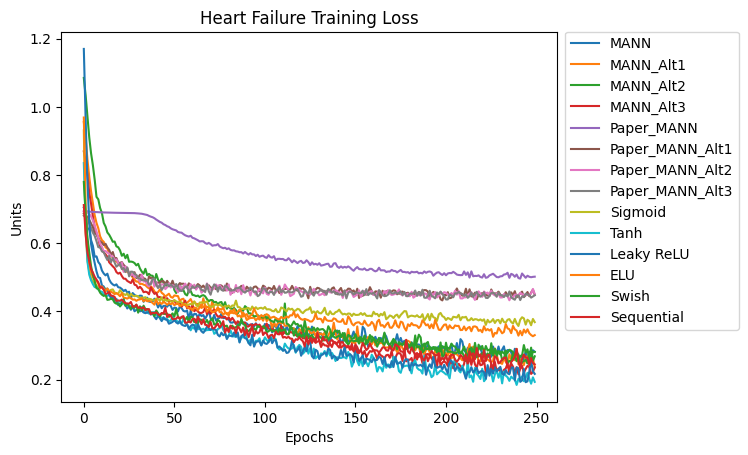

In [210]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')

plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['loss'], label='MANN_Alt1')

plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['loss'], label='MANN_Alt2')

plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['loss'], label='MANN_Alt3')

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3')


plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')

plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')

plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')

plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')

plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')

plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')

plt.title('Heart Failure Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

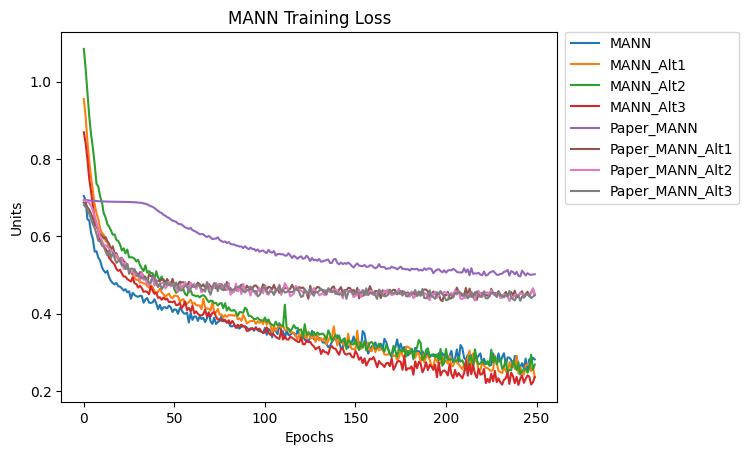

In [211]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')

plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['loss'], label='MANN_Alt1')

plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['loss'], label='MANN_Alt2')

plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['loss'], label='MANN_Alt3')

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3')

plt.title('MANN Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

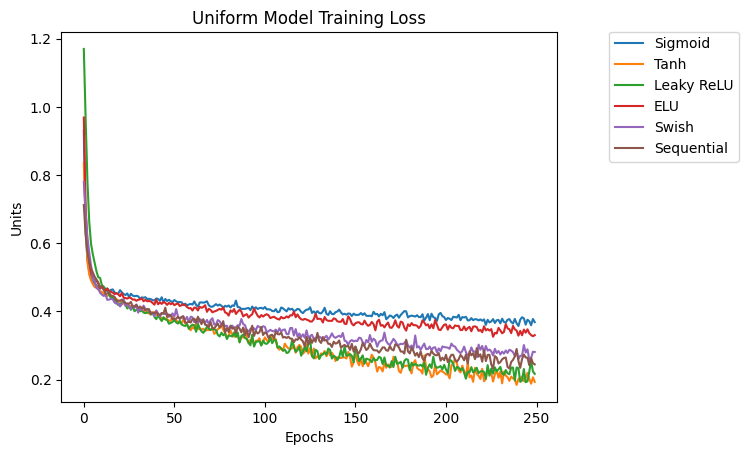

In [212]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')

plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')

plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')

plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')

plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')

plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')

plt.title('Uniform Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

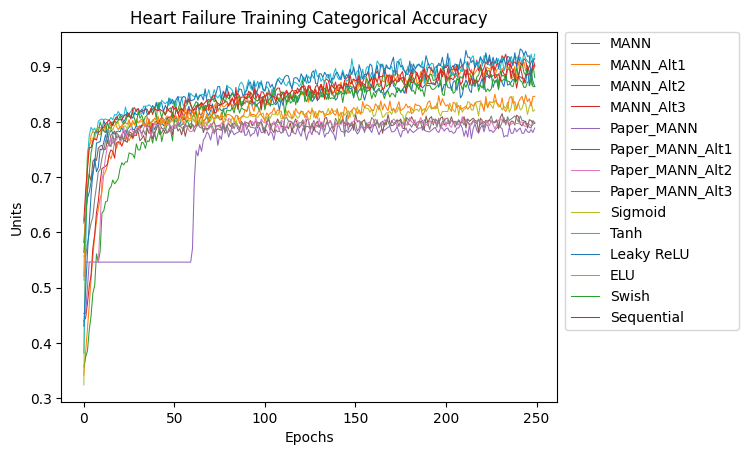

In [213]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Heart Failure Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

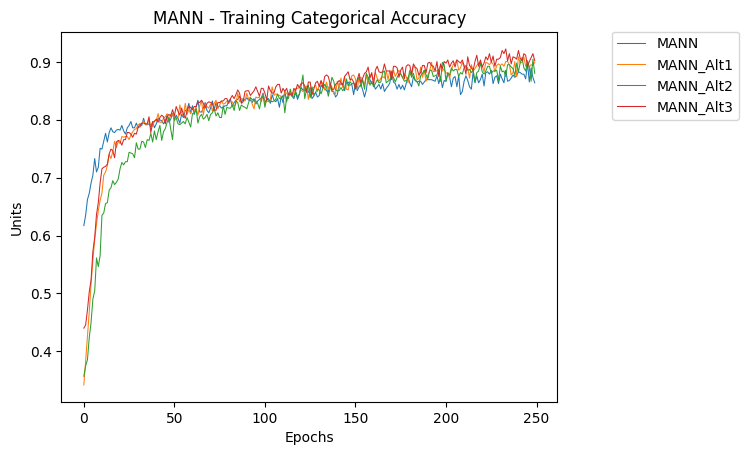

In [214]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('MANN - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

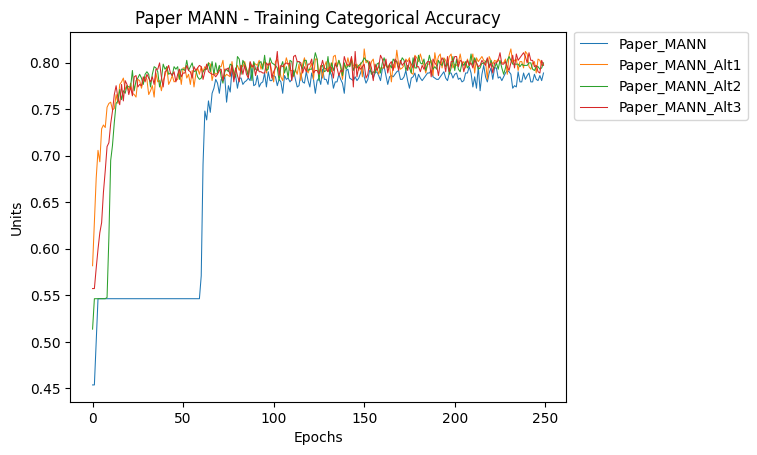

In [215]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Paper MANN - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

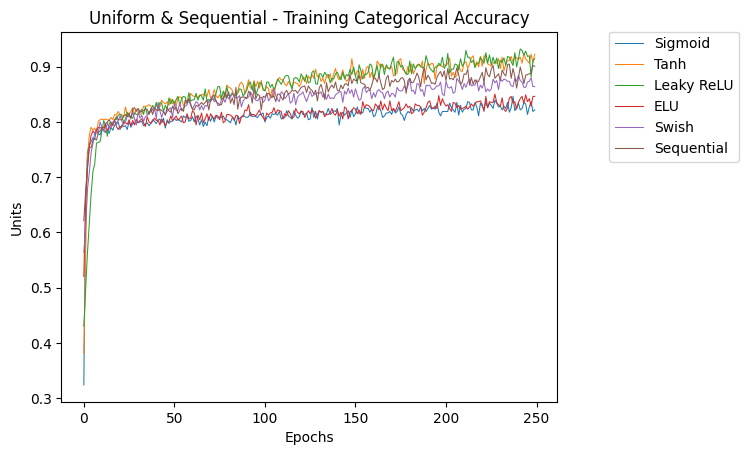

In [216]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Uniform & Sequential - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

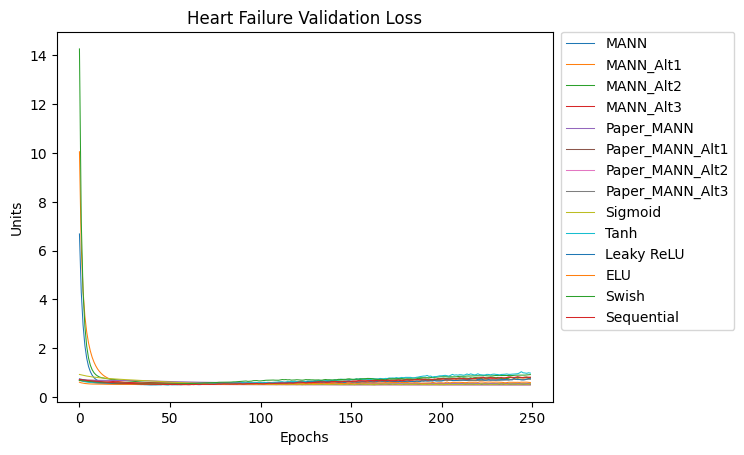

In [217]:
# Plot the validation loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['val_loss'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['val_loss'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['val_loss'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['val_loss'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['val_loss'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['val_loss'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['val_loss'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['val_loss'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['val_loss'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['val_loss'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['val_loss'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['val_loss'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['val_loss'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['val_loss'], label='Sequential', linewidth=0.75)

plt.title('Heart Failure Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')
#plt.ylim([0,1.5])
plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

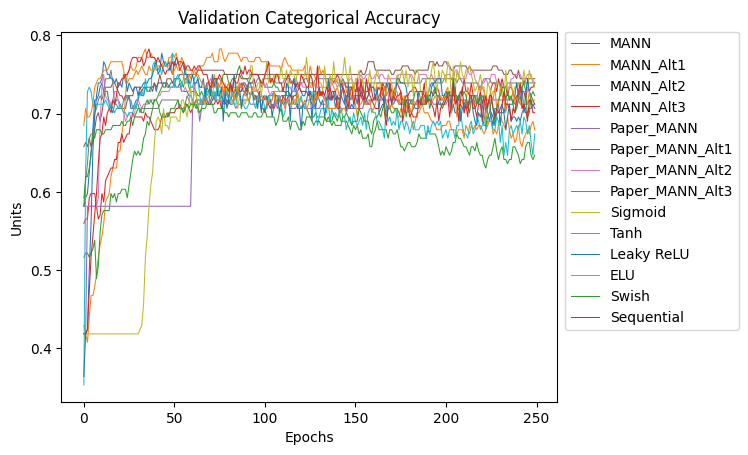

In [218]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['val_categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['val_categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['val_categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['val_categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['val_categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['val_categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['val_categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['val_categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['val_categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['val_categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['val_categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['val_categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['val_categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['val_categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

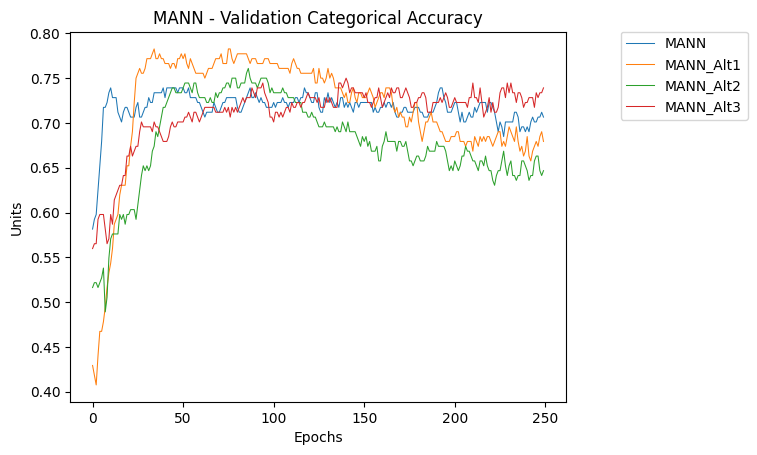

In [219]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['val_categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['val_categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['val_categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['val_categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('MANN - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

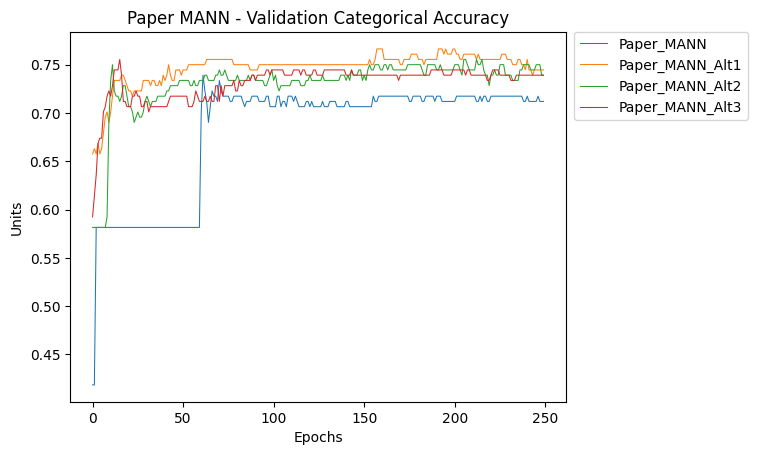

In [220]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['val_categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['val_categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['val_categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['val_categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Paper MANN - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

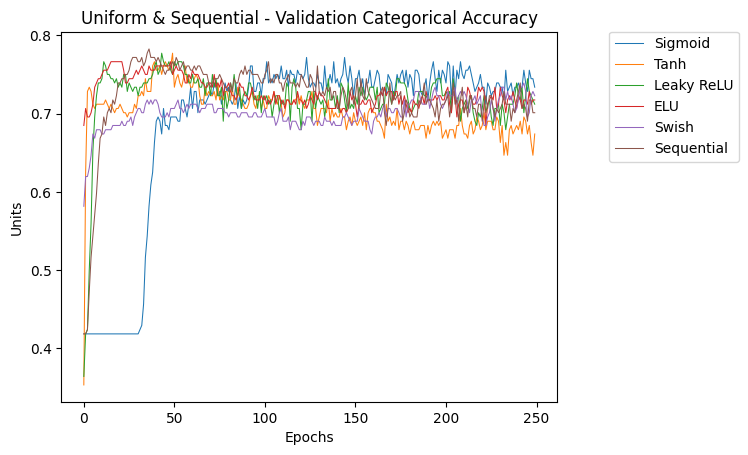

In [221]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['val_categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['val_categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['val_categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['val_categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['val_categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['val_categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Uniform & Sequential - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

In [222]:
# Save training history
train_hist_df = pd.DataFrame()
val_hist_df = pd.DataFrame()
for name, callback in histories.items():
    train_hist_df = pd.concat((train_hist_df, pd.DataFrame(callback.history['loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    val_hist_df = pd.concat((val_hist_df, pd.DataFrame(callback.history['val_loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    
train_hist_df.to_csv('Binary.training_hist.csv')
val_hist_df.to_csv('Binary.validation_hist.csv')

In [223]:
# Get performance metrics for each model
# Get the testing loss for each model
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, one_hot.inverse_transform(y_train).ravel())

metric = keras.metrics.CategoricalAccuracy()
metric.update_state(y_test.to_numpy(), one_hot.transform(log_reg.predict(X_test).reshape(-1,1)))
log_reg_loss = metric.result().numpy()

MANN_loss = models['MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt1_loss = models['MANN_Alt1'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt2_loss = models['MANN_Alt2'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt3_loss = models['MANN_Alt3'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Paper_MANN_loss = models['Paper_MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt1_loss = models['Paper_MANN_Alt1'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt2_loss = models['Paper_MANN_Alt2'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt3_loss = models['Paper_MANN_Alt3'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Sigmoid_loss = models['Sigmoid'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Tanh_loss = models['Tanh'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

LeakyReLU_loss = models['LeakyReLU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

ELU_loss = models['ELU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Swish_loss = models['Swish'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Sequential_loss = models['Sequential'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

6/6 [==============================] - 0s 5ms/step - loss: 0.8086 - categorical_accuracy: 0.7011


In [224]:
# Save metrics to a table and display results
# Save testing loss to table and display results
results = pd.DataFrame([MANN_loss, MANN_Alt1_loss, MANN_Alt2_loss, MANN_Alt3_loss, Paper_MANN_loss, Paper_MANN_Alt1_loss, Paper_MANN_Alt2_loss, Paper_MANN_Alt3_loss,Sigmoid_loss, Tanh_loss, LeakyReLU_loss, ELU_loss, Swish_loss, Sequential_loss],
                      index=['MANN', 'MANN_Alt1', 'MANN_Alt2', 'MANN_Alt3', 'Paper MANN', 'Paper Alternate MANN 1', 'Paper Alternate MANN 2', 'Paper Alternate MANN 3', 'Sigmoid NN', 'Tanh NN', 'Leaky ReLU NN', 'ELU NN', 'Swish NN', 'Sequential NN'],
                      columns=['Categorical Accuracy'])
results.sort_values('Categorical Accuracy', inplace=True, ascending=False)
results.head(20)

Categorical Accuracy
Paper Alternate MANN 1              0.744565
MANN_Alt3                           0.739130
Paper Alternate MANN 2              0.739130
Paper Alternate MANN 3              0.739130
Sigmoid NN                          0.733696
Swish NN                            0.722826
ELU NN                              0.717391
Paper MANN                          0.711957
Leaky ReLU NN                       0.711957
MANN                                0.706522
Sequential NN                       0.701087
MANN_Alt1                           0.679348
Tanh NN                             0.673913
MANN_Alt2                           0.646739

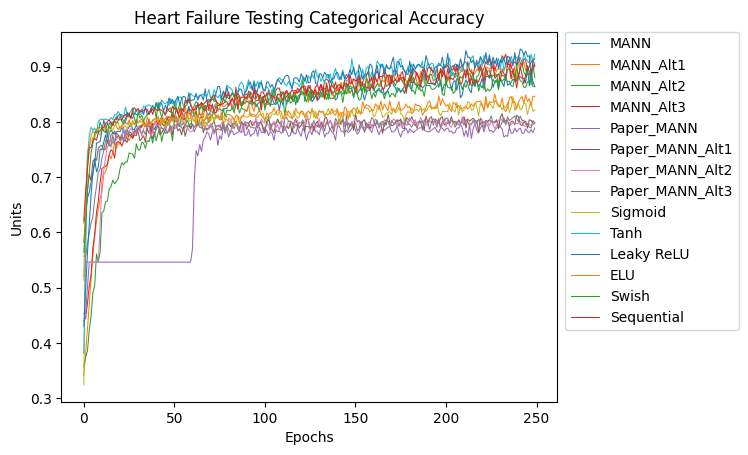

In [227]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Heart Failure Testing Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

# 

# 

# Pulling Cirrhosis Prediction Dataset data from the csv

In [228]:
# Load the data and split into testing and training for processing
CirrhosisData = pd.read_csv('./Datasets/cirrhosis.csv')

CirrhosisData.describe()

ID       N_Days           Age   Bilirubin  Cholesterol  \
count  418.000000   418.000000    418.000000  418.000000   284.000000   
mean   209.500000  1917.782297  18533.351675    3.220813   369.510563   
std    120.810458  1104.672992   3815.845055    4.407506   231.944545   
min      1.000000    41.000000   9598.000000    0.300000   120.000000   
25%    105.250000  1092.750000  15644.500000    0.800000   249.500000   
50%    209.500000  1730.000000  18628.000000    1.400000   309.500000   
75%    313.750000  2613.500000  21272.500000    3.400000   400.000000   
max    418.000000  4795.000000  28650.000000   28.000000  1775.000000   

          Albumin      Copper      Alk_Phos        SGOT  Tryglicerides  \
count  418.000000  310.000000    312.000000  312.000000     282.000000   
mean     3.497440   97.648387   1982.655769  122.556346     124.702128   
std      0.424972   85.613920   2140.388824   56.699525      65.148639   
min      1.960000    4.000000    289.000000   26.350000      33.000000   
25%      3.242500   41.250000    871.500000   80.600000      84.250000   
50%      3.530000   73.000000   1259.000000  114.700000     108.000000   
75%      3.770000  123.000000   1980.000000  151.900000     151.000000   
max      4.640000  588.000000  13862.400000  457.250000     598.000000   

        Platelets  Prothrombin       Stage  
count  407.000000   416.000000  412.000000  
mean   257.024570    10.731731    3.024272  
std     98.325585     1.022000    0.882042  
min     62.000000     9.000000    1.000000  
25%    188.500000    10.000000    2.000000  
50%    251.000000    10.600000    3.000000  
75%    318.000000    11.100000    4.000000  
max    721.000000    18.000000    4.000000

In [229]:
CirrhosisData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

In [230]:
CirrhosisData.isnull().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

## Replace nan values with the mean for float type columns 10-19

In [231]:
CirrhosisData["Stage"] = CirrhosisData["Stage"].fillna(0)

In [232]:
CirrhosisData.isnull().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              0
dtype: int64

## Assigning features and targets from dataset

In [233]:
CirrhosisData = CirrhosisData.dropna()

In [234]:
features = CirrhosisData.drop(['ID', 'Stage'], axis=1)
features["Age"] = (features["Age"]/365).astype("int64")

target = CirrhosisData['Stage']

In [235]:
features.head()

N_Days Status             Drug  Age Sex Ascites Hepatomegaly Spiders Edema  \
0     400      D  D-penicillamine   58   F       Y            Y       Y     Y   
1    4500      C  D-penicillamine   56   F       N            Y       Y     N   
2    1012      D  D-penicillamine   70   M       N            N       N     S   
3    1925      D  D-penicillamine   54   F       N            Y       Y     S   
4    1504     CL          Placebo   38   F       N            Y       Y     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0       14.5        261.0     2.60   156.0    1718.0  137.95          172.0   
1        1.1        302.0     4.14    54.0    7394.8  113.52           88.0   
2        1.4        176.0     3.48   210.0     516.0   96.10           55.0   
3        1.8        244.0     2.54    64.0    6121.8   60.63           92.0   
4        3.4        279.0     3.53   143.0     671.0  113.15           72.0   

   Platelets  Prothrombin  
0      190.0         12.2  
1      221.0         10.6  
2      151.0         12.0  
3      183.0         10.3  
4      136.0         10.9

In [236]:
target.value_counts()

3.0    111
4.0     94
2.0     59
1.0     12
Name: Stage, dtype: int64

In [237]:
CirrhosisData.isnull().sum()

ID               0
N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

## Training the models

In [238]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

## Normalizing dataset

In [239]:
# Process and normalize the data
one_hot = OneHotEncoder(sparse_output=False)

# One-Hot encode categorical columns
X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']]), columns=one_hot.get_feature_names_out()))
X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']]), columns=one_hot.get_feature_names_out()))

# Drop the transformed columns and unneeded columns
X_train.drop(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], axis = 1, inplace=True)
X_test.drop(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], axis=1, inplace=True)



# Normalize numerical columns
scaler = StandardScaler()
X_train[['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']]= scaler.fit_transform(X_train[['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']])
X_test[['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']] = scaler.transform(X_test[['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']])

C:\Users\Jaskirat\AppData\Local\Temp\ipykernel_17868\876908666.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']]), columns=one_hot.get_feature_names_out()))
C:\Users\Jaskirat\AppData\Local\Temp\ipykernel_17868\876908666.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']]), columns=one_hot.get_feature_names_out()))


In [240]:
# One-Hot encode target labels
y_train = pd.DataFrame(data=one_hot.fit_transform(y_train.to_numpy().reshape(-1,1)), columns=one_hot.categories_)
y_test = pd.DataFrame(data=one_hot.transform(y_test.to_numpy().reshape(-1,1)), columns=one_hot.categories_)

In [241]:
print(one_hot.categories_[0])
print(len(one_hot.categories_[0]))

[1. 2. 3. 4.]
4


In [242]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   (1.0,)  220 non-null    float64
 1   (2.0,)  220 non-null    float64
 2   (3.0,)  220 non-null    float64
 3   (4.0,)  220 non-null    float64
dtypes: float64(4)
memory usage: 7.0 KB


In [243]:
# Create and fit all neural networks for evaluations

models, histories = test(X_train.to_numpy(), y_train.to_numpy(), X_test=X_test.to_numpy(), y_test=y_test.to_numpy(), num_classes=len(one_hot.categories_[0]), task='classification', epochs=250, batch_size=128, task_name='Cirrhosis')

Training Multi Activation Neural Network...
Epoch 1/250
2/2 [==============================] - 3s 401ms/step - loss: 1.5211 - categorical_accuracy: 0.2545 - val_loss: 17.8403 - val_categorical_accuracy: 0.1964
Epoch 2/250
2/2 [==============================] - 0s 134ms/step - loss: 1.5076 - categorical_accuracy: 0.2818 - val_loss: 14.1553 - val_categorical_accuracy: 0.2143
Epoch 3/250
2/2 [==============================] - 0s 151ms/step - loss: 1.4727 - categorical_accuracy: 0.2818 - val_loss: 11.4975 - val_categorical_accuracy: 0.2143
Epoch 4/250
2/2 [==============================] - 0s 131ms/step - loss: 1.4906 - categorical_accuracy: 0.2682 - val_loss: 9.5265 - val_categorical_accuracy: 0.2143
Epoch 5/250
2/2 [==============================] - 0s 135ms/step - loss: 1.4653 - categorical_accuracy: 0.2864 - val_loss: 8.0983 - val_categorical_accuracy: 0.2321
Epoch 6/250
2/2 [==============================] - 0s 153ms/step - loss: 1.4602 - categorical_accuracy: 0.3091 - val_loss: 6.947

2/2 [==============================] - 0s 120ms/step - loss: 1.1348 - categorical_accuracy: 0.5636 - val_loss: 1.4050 - val_categorical_accuracy: 0.3393
Epoch 51/250
2/2 [==============================] - 0s 141ms/step - loss: 1.1596 - categorical_accuracy: 0.5318 - val_loss: 1.3982 - val_categorical_accuracy: 0.3393
Epoch 52/250
2/2 [==============================] - 0s 115ms/step - loss: 1.1265 - categorical_accuracy: 0.5591 - val_loss: 1.3904 - val_categorical_accuracy: 0.3393
Epoch 53/250
2/2 [==============================] - 0s 109ms/step - loss: 1.1332 - categorical_accuracy: 0.5500 - val_loss: 1.3848 - val_categorical_accuracy: 0.3393
Epoch 54/250
2/2 [==============================] - 0s 110ms/step - loss: 1.1239 - categorical_accuracy: 0.5545 - val_loss: 1.3784 - val_categorical_accuracy: 0.3571
Epoch 55/250
2/2 [==============================] - 0s 118ms/step - loss: 1.1064 - categorical_accuracy: 0.5727 - val_loss: 1.3718 - val_categorical_accuracy: 0.3571
Epoch 56/250
2/2 

2/2 [==============================] - 0s 70ms/step - loss: 0.9382 - categorical_accuracy: 0.6364 - val_loss: 1.2492 - val_categorical_accuracy: 0.4821
Epoch 100/250
2/2 [==============================] - 0s 67ms/step - loss: 0.9222 - categorical_accuracy: 0.6818 - val_loss: 1.2493 - val_categorical_accuracy: 0.4821
Epoch 101/250
2/2 [==============================] - 0s 65ms/step - loss: 0.9308 - categorical_accuracy: 0.6591 - val_loss: 1.2481 - val_categorical_accuracy: 0.4821
Epoch 102/250
2/2 [==============================] - 0s 67ms/step - loss: 0.9168 - categorical_accuracy: 0.6773 - val_loss: 1.2481 - val_categorical_accuracy: 0.5000
Epoch 103/250
2/2 [==============================] - 0s 70ms/step - loss: 0.9125 - categorical_accuracy: 0.6682 - val_loss: 1.2456 - val_categorical_accuracy: 0.5000
Epoch 104/250
2/2 [==============================] - 0s 138ms/step - loss: 0.9063 - categorical_accuracy: 0.6591 - val_loss: 1.2453 - val_categorical_accuracy: 0.5000
Epoch 105/250
2/2

2/2 [==============================] - 0s 98ms/step - loss: 0.7411 - categorical_accuracy: 0.7364 - val_loss: 1.3015 - val_categorical_accuracy: 0.4821
Epoch 149/250
2/2 [==============================] - 0s 71ms/step - loss: 0.7616 - categorical_accuracy: 0.7364 - val_loss: 1.3034 - val_categorical_accuracy: 0.4821
Epoch 150/250
2/2 [==============================] - 0s 83ms/step - loss: 0.7396 - categorical_accuracy: 0.7364 - val_loss: 1.3041 - val_categorical_accuracy: 0.4821
Epoch 151/250
2/2 [==============================] - 0s 66ms/step - loss: 0.7391 - categorical_accuracy: 0.7500 - val_loss: 1.3065 - val_categorical_accuracy: 0.4821
Epoch 152/250
2/2 [==============================] - 0s 73ms/step - loss: 0.7215 - categorical_accuracy: 0.7591 - val_loss: 1.3088 - val_categorical_accuracy: 0.4821
Epoch 153/250
2/2 [==============================] - 0s 82ms/step - loss: 0.7254 - categorical_accuracy: 0.7500 - val_loss: 1.3106 - val_categorical_accuracy: 0.4821
Epoch 154/250
2/2 

2/2 [==============================] - 0s 69ms/step - loss: 0.5954 - categorical_accuracy: 0.8000 - val_loss: 1.3890 - val_categorical_accuracy: 0.4464
Epoch 198/250
2/2 [==============================] - 0s 75ms/step - loss: 0.5888 - categorical_accuracy: 0.8000 - val_loss: 1.3895 - val_categorical_accuracy: 0.4464
Epoch 199/250
2/2 [==============================] - 0s 65ms/step - loss: 0.5704 - categorical_accuracy: 0.8136 - val_loss: 1.3964 - val_categorical_accuracy: 0.4464
Epoch 200/250
2/2 [==============================] - 0s 65ms/step - loss: 0.5580 - categorical_accuracy: 0.8136 - val_loss: 1.4003 - val_categorical_accuracy: 0.4643
Epoch 201/250
2/2 [==============================] - 0s 70ms/step - loss: 0.5878 - categorical_accuracy: 0.8000 - val_loss: 1.4034 - val_categorical_accuracy: 0.4464
Epoch 202/250
2/2 [==============================] - 0s 69ms/step - loss: 0.5769 - categorical_accuracy: 0.8045 - val_loss: 1.4109 - val_categorical_accuracy: 0.4464
Epoch 203/250
2/2 

2/2 [==============================] - 0s 83ms/step - loss: 0.4614 - categorical_accuracy: 0.8455 - val_loss: 1.5708 - val_categorical_accuracy: 0.4464
Epoch 247/250
2/2 [==============================] - 0s 68ms/step - loss: 0.4776 - categorical_accuracy: 0.8455 - val_loss: 1.5787 - val_categorical_accuracy: 0.4464
Epoch 248/250
2/2 [==============================] - 0s 67ms/step - loss: 0.4964 - categorical_accuracy: 0.8227 - val_loss: 1.5868 - val_categorical_accuracy: 0.4464
Epoch 249/250
2/2 [==============================] - 0s 74ms/step - loss: 0.4690 - categorical_accuracy: 0.8364 - val_loss: 1.5911 - val_categorical_accuracy: 0.4464
Epoch 250/250
2/2 [==============================] - 0s 65ms/step - loss: 0.4636 - categorical_accuracy: 0.8682 - val_loss: 1.5994 - val_categorical_accuracy: 0.4464
INFO:tensorflow:Assets written to: ./Models/250_Epochs/Cirrhosis/MANN\assets
Training Complete
Epoch 1/250
2/2 [==============================] - 3s 342ms/step - loss: 1.9975 - categor

Epoch 45/250
2/2 [==============================] - 0s 131ms/step - loss: 1.2059 - categorical_accuracy: 0.4773 - val_loss: 2.0153 - val_categorical_accuracy: 0.2679
Epoch 46/250
2/2 [==============================] - 0s 140ms/step - loss: 1.1829 - categorical_accuracy: 0.5227 - val_loss: 1.9835 - val_categorical_accuracy: 0.2500
Epoch 47/250
2/2 [==============================] - 0s 170ms/step - loss: 1.1877 - categorical_accuracy: 0.4909 - val_loss: 1.9495 - val_categorical_accuracy: 0.2500
Epoch 48/250
2/2 [==============================] - 0s 166ms/step - loss: 1.1872 - categorical_accuracy: 0.5136 - val_loss: 1.9211 - val_categorical_accuracy: 0.2679
Epoch 49/250
2/2 [==============================] - 0s 153ms/step - loss: 1.1754 - categorical_accuracy: 0.5000 - val_loss: 1.8935 - val_categorical_accuracy: 0.2857
Epoch 50/250
2/2 [==============================] - 0s 157ms/step - loss: 1.1591 - categorical_accuracy: 0.5182 - val_loss: 1.8687 - val_categorical_accuracy: 0.2679
Epoc

2/2 [==============================] - 0s 112ms/step - loss: 0.9233 - categorical_accuracy: 0.6545 - val_loss: 1.4007 - val_categorical_accuracy: 0.4464
Epoch 95/250
2/2 [==============================] - 0s 128ms/step - loss: 0.9031 - categorical_accuracy: 0.6773 - val_loss: 1.3976 - val_categorical_accuracy: 0.4464
Epoch 96/250
2/2 [==============================] - 0s 119ms/step - loss: 0.9044 - categorical_accuracy: 0.6500 - val_loss: 1.3948 - val_categorical_accuracy: 0.4464
Epoch 97/250
2/2 [==============================] - 0s 115ms/step - loss: 0.8944 - categorical_accuracy: 0.6864 - val_loss: 1.3927 - val_categorical_accuracy: 0.4286
Epoch 98/250
2/2 [==============================] - 0s 233ms/step - loss: 0.8948 - categorical_accuracy: 0.6955 - val_loss: 1.3898 - val_categorical_accuracy: 0.4464
Epoch 99/250
2/2 [==============================] - 0s 153ms/step - loss: 0.8930 - categorical_accuracy: 0.6864 - val_loss: 1.3861 - val_categorical_accuracy: 0.4464
Epoch 100/250
2/2

2/2 [==============================] - 0s 136ms/step - loss: 0.7483 - categorical_accuracy: 0.7636 - val_loss: 1.3245 - val_categorical_accuracy: 0.4464
Epoch 144/250
2/2 [==============================] - 0s 65ms/step - loss: 0.7485 - categorical_accuracy: 0.7364 - val_loss: 1.3247 - val_categorical_accuracy: 0.4464
Epoch 145/250
2/2 [==============================] - 0s 138ms/step - loss: 0.7342 - categorical_accuracy: 0.7545 - val_loss: 1.3232 - val_categorical_accuracy: 0.4464
Epoch 146/250
2/2 [==============================] - 0s 116ms/step - loss: 0.7493 - categorical_accuracy: 0.7318 - val_loss: 1.3224 - val_categorical_accuracy: 0.4464
Epoch 147/250
2/2 [==============================] - 0s 114ms/step - loss: 0.7663 - categorical_accuracy: 0.7364 - val_loss: 1.3205 - val_categorical_accuracy: 0.4643
Epoch 148/250
2/2 [==============================] - 0s 120ms/step - loss: 0.7547 - categorical_accuracy: 0.7545 - val_loss: 1.3187 - val_categorical_accuracy: 0.4643
Epoch 149/250

2/2 [==============================] - 0s 50ms/step - loss: 0.6127 - categorical_accuracy: 0.8318 - val_loss: 1.3461 - val_categorical_accuracy: 0.4643
Epoch 193/250
2/2 [==============================] - 0s 56ms/step - loss: 0.6043 - categorical_accuracy: 0.8273 - val_loss: 1.3503 - val_categorical_accuracy: 0.4643
Epoch 194/250
2/2 [==============================] - 0s 66ms/step - loss: 0.6183 - categorical_accuracy: 0.8091 - val_loss: 1.3509 - val_categorical_accuracy: 0.4643
Epoch 195/250
2/2 [==============================] - 0s 69ms/step - loss: 0.6363 - categorical_accuracy: 0.8136 - val_loss: 1.3525 - val_categorical_accuracy: 0.4643
Epoch 196/250
2/2 [==============================] - 0s 96ms/step - loss: 0.6610 - categorical_accuracy: 0.7955 - val_loss: 1.3528 - val_categorical_accuracy: 0.4643
Epoch 197/250
2/2 [==============================] - 0s 66ms/step - loss: 0.6110 - categorical_accuracy: 0.8318 - val_loss: 1.3527 - val_categorical_accuracy: 0.4643
Epoch 198/250
2/2 

2/2 [==============================] - 0s 51ms/step - loss: 0.5556 - categorical_accuracy: 0.8273 - val_loss: 1.4387 - val_categorical_accuracy: 0.5179
Epoch 242/250
2/2 [==============================] - 0s 56ms/step - loss: 0.4869 - categorical_accuracy: 0.8864 - val_loss: 1.4414 - val_categorical_accuracy: 0.5000
Epoch 243/250
2/2 [==============================] - 0s 82ms/step - loss: 0.5302 - categorical_accuracy: 0.8273 - val_loss: 1.4449 - val_categorical_accuracy: 0.5179
Epoch 244/250
2/2 [==============================] - 0s 68ms/step - loss: 0.4820 - categorical_accuracy: 0.8727 - val_loss: 1.4483 - val_categorical_accuracy: 0.5179
Epoch 245/250
2/2 [==============================] - 0s 61ms/step - loss: 0.5174 - categorical_accuracy: 0.8545 - val_loss: 1.4491 - val_categorical_accuracy: 0.5179
Epoch 246/250
2/2 [==============================] - 0s 93ms/step - loss: 0.5754 - categorical_accuracy: 0.8182 - val_loss: 1.4538 - val_categorical_accuracy: 0.5000
Epoch 247/250
2/2 

Epoch 40/250
2/2 [==============================] - 0s 208ms/step - loss: 1.3375 - categorical_accuracy: 0.3909 - val_loss: 1.7148 - val_categorical_accuracy: 0.2500
Epoch 41/250
2/2 [==============================] - 0s 207ms/step - loss: 1.3153 - categorical_accuracy: 0.4136 - val_loss: 1.7001 - val_categorical_accuracy: 0.2500
Epoch 42/250
2/2 [==============================] - 0s 230ms/step - loss: 1.3463 - categorical_accuracy: 0.3818 - val_loss: 1.6820 - val_categorical_accuracy: 0.2500
Epoch 43/250
2/2 [==============================] - 0s 231ms/step - loss: 1.3231 - categorical_accuracy: 0.4045 - val_loss: 1.6650 - val_categorical_accuracy: 0.2500
Epoch 44/250
2/2 [==============================] - 0s 212ms/step - loss: 1.3022 - categorical_accuracy: 0.4000 - val_loss: 1.6500 - val_categorical_accuracy: 0.2500
Epoch 45/250
2/2 [==============================] - 0s 212ms/step - loss: 1.3187 - categorical_accuracy: 0.4091 - val_loss: 1.6356 - val_categorical_accuracy: 0.2500
Epoc

2/2 [==============================] - 0s 180ms/step - loss: 1.1203 - categorical_accuracy: 0.4727 - val_loss: 1.3811 - val_categorical_accuracy: 0.3571
Epoch 90/250
2/2 [==============================] - 0s 192ms/step - loss: 1.1296 - categorical_accuracy: 0.5045 - val_loss: 1.3783 - val_categorical_accuracy: 0.3571
Epoch 91/250
2/2 [==============================] - 0s 166ms/step - loss: 1.1095 - categorical_accuracy: 0.4864 - val_loss: 1.3725 - val_categorical_accuracy: 0.3571
Epoch 92/250
2/2 [==============================] - 0s 163ms/step - loss: 1.0925 - categorical_accuracy: 0.5045 - val_loss: 1.3684 - val_categorical_accuracy: 0.3571
Epoch 93/250
2/2 [==============================] - 0s 160ms/step - loss: 1.1128 - categorical_accuracy: 0.4545 - val_loss: 1.3622 - val_categorical_accuracy: 0.3571
Epoch 94/250
2/2 [==============================] - 0s 126ms/step - loss: 1.0773 - categorical_accuracy: 0.5182 - val_loss: 1.3576 - val_categorical_accuracy: 0.3571
Epoch 95/250
2/2 

2/2 [==============================] - 0s 71ms/step - loss: 0.9642 - categorical_accuracy: 0.6000 - val_loss: 1.2617 - val_categorical_accuracy: 0.4286
Epoch 139/250
2/2 [==============================] - 0s 70ms/step - loss: 0.9790 - categorical_accuracy: 0.5955 - val_loss: 1.2637 - val_categorical_accuracy: 0.4286
Epoch 140/250
2/2 [==============================] - 0s 72ms/step - loss: 0.9415 - categorical_accuracy: 0.6318 - val_loss: 1.2619 - val_categorical_accuracy: 0.4286
Epoch 141/250
2/2 [==============================] - 0s 138ms/step - loss: 0.9557 - categorical_accuracy: 0.6318 - val_loss: 1.2594 - val_categorical_accuracy: 0.4286
Epoch 142/250
2/2 [==============================] - 0s 130ms/step - loss: 0.9382 - categorical_accuracy: 0.6318 - val_loss: 1.2580 - val_categorical_accuracy: 0.4286
Epoch 143/250
2/2 [==============================] - 0s 128ms/step - loss: 0.9442 - categorical_accuracy: 0.6273 - val_loss: 1.2575 - val_categorical_accuracy: 0.4286
Epoch 144/250
2

2/2 [==============================] - 0s 69ms/step - loss: 0.8528 - categorical_accuracy: 0.6636 - val_loss: 1.2481 - val_categorical_accuracy: 0.4643
Epoch 188/250
2/2 [==============================] - 0s 68ms/step - loss: 0.8591 - categorical_accuracy: 0.6636 - val_loss: 1.2535 - val_categorical_accuracy: 0.4643
Epoch 189/250
2/2 [==============================] - 0s 65ms/step - loss: 0.8709 - categorical_accuracy: 0.6273 - val_loss: 1.2594 - val_categorical_accuracy: 0.4821
Epoch 190/250
2/2 [==============================] - 0s 68ms/step - loss: 0.8514 - categorical_accuracy: 0.6682 - val_loss: 1.2612 - val_categorical_accuracy: 0.4821
Epoch 191/250
2/2 [==============================] - 0s 66ms/step - loss: 0.8539 - categorical_accuracy: 0.6591 - val_loss: 1.2600 - val_categorical_accuracy: 0.4643
Epoch 192/250
2/2 [==============================] - 0s 69ms/step - loss: 0.8381 - categorical_accuracy: 0.6727 - val_loss: 1.2632 - val_categorical_accuracy: 0.4643
Epoch 193/250
2/2 

2/2 [==============================] - 0s 79ms/step - loss: 0.7353 - categorical_accuracy: 0.6955 - val_loss: 1.3637 - val_categorical_accuracy: 0.4107
Epoch 237/250
2/2 [==============================] - 0s 99ms/step - loss: 0.7484 - categorical_accuracy: 0.7045 - val_loss: 1.3621 - val_categorical_accuracy: 0.4107
Epoch 238/250
2/2 [==============================] - 0s 70ms/step - loss: 0.7232 - categorical_accuracy: 0.7227 - val_loss: 1.3647 - val_categorical_accuracy: 0.4107
Epoch 239/250
2/2 [==============================] - 0s 72ms/step - loss: 0.7257 - categorical_accuracy: 0.7227 - val_loss: 1.3721 - val_categorical_accuracy: 0.4107
Epoch 240/250
2/2 [==============================] - 0s 70ms/step - loss: 0.7291 - categorical_accuracy: 0.7227 - val_loss: 1.3742 - val_categorical_accuracy: 0.4107
Epoch 241/250
2/2 [==============================] - 0s 68ms/step - loss: 0.7347 - categorical_accuracy: 0.7136 - val_loss: 1.3809 - val_categorical_accuracy: 0.4107
Epoch 242/250
2/2 

Epoch 35/250
2/2 [==============================] - 0s 146ms/step - loss: 1.2406 - categorical_accuracy: 0.4182 - val_loss: 1.8861 - val_categorical_accuracy: 0.1786
Epoch 36/250
2/2 [==============================] - 0s 150ms/step - loss: 1.2365 - categorical_accuracy: 0.4318 - val_loss: 1.8546 - val_categorical_accuracy: 0.1964
Epoch 37/250
2/2 [==============================] - 0s 133ms/step - loss: 1.2281 - categorical_accuracy: 0.4227 - val_loss: 1.8275 - val_categorical_accuracy: 0.2321
Epoch 38/250
2/2 [==============================] - 0s 154ms/step - loss: 1.2251 - categorical_accuracy: 0.4364 - val_loss: 1.8053 - val_categorical_accuracy: 0.2321
Epoch 39/250
2/2 [==============================] - 0s 121ms/step - loss: 1.2221 - categorical_accuracy: 0.4227 - val_loss: 1.7869 - val_categorical_accuracy: 0.2679
Epoch 40/250
2/2 [==============================] - 0s 124ms/step - loss: 1.2033 - categorical_accuracy: 0.4318 - val_loss: 1.7686 - val_categorical_accuracy: 0.2500
Epoc

2/2 [==============================] - 0s 228ms/step - loss: 0.9530 - categorical_accuracy: 0.6000 - val_loss: 1.5204 - val_categorical_accuracy: 0.2857
Epoch 85/250
2/2 [==============================] - 0s 199ms/step - loss: 0.9387 - categorical_accuracy: 0.6045 - val_loss: 1.5169 - val_categorical_accuracy: 0.2857
Epoch 86/250
2/2 [==============================] - 0s 177ms/step - loss: 0.9384 - categorical_accuracy: 0.6045 - val_loss: 1.5148 - val_categorical_accuracy: 0.2857
Epoch 87/250
2/2 [==============================] - 0s 182ms/step - loss: 0.9110 - categorical_accuracy: 0.6045 - val_loss: 1.5109 - val_categorical_accuracy: 0.2857
Epoch 88/250
2/2 [==============================] - 0s 192ms/step - loss: 0.9190 - categorical_accuracy: 0.6273 - val_loss: 1.5073 - val_categorical_accuracy: 0.2857
Epoch 89/250
2/2 [==============================] - 0s 174ms/step - loss: 0.9202 - categorical_accuracy: 0.6091 - val_loss: 1.5035 - val_categorical_accuracy: 0.2857
Epoch 90/250
2/2 

2/2 [==============================] - 0s 60ms/step - loss: 0.7663 - categorical_accuracy: 0.6818 - val_loss: 1.5222 - val_categorical_accuracy: 0.3393
Epoch 134/250
2/2 [==============================] - 0s 64ms/step - loss: 0.7610 - categorical_accuracy: 0.6909 - val_loss: 1.5306 - val_categorical_accuracy: 0.3393
Epoch 135/250
2/2 [==============================] - 0s 70ms/step - loss: 0.7421 - categorical_accuracy: 0.7182 - val_loss: 1.5353 - val_categorical_accuracy: 0.3393
Epoch 136/250
2/2 [==============================] - 0s 61ms/step - loss: 0.7531 - categorical_accuracy: 0.7182 - val_loss: 1.5374 - val_categorical_accuracy: 0.3393
Epoch 137/250
2/2 [==============================] - 0s 57ms/step - loss: 0.7653 - categorical_accuracy: 0.6909 - val_loss: 1.5401 - val_categorical_accuracy: 0.3393
Epoch 138/250
2/2 [==============================] - 0s 57ms/step - loss: 0.7147 - categorical_accuracy: 0.7091 - val_loss: 1.5421 - val_categorical_accuracy: 0.3393
Epoch 139/250
2/2 

2/2 [==============================] - 0s 96ms/step - loss: 0.6461 - categorical_accuracy: 0.7364 - val_loss: 1.6982 - val_categorical_accuracy: 0.3393
Epoch 183/250
2/2 [==============================] - 0s 99ms/step - loss: 0.6313 - categorical_accuracy: 0.7273 - val_loss: 1.6965 - val_categorical_accuracy: 0.3393
Epoch 184/250
2/2 [==============================] - 0s 94ms/step - loss: 0.6110 - categorical_accuracy: 0.7591 - val_loss: 1.6955 - val_categorical_accuracy: 0.3393
Epoch 185/250
2/2 [==============================] - 0s 122ms/step - loss: 0.6042 - categorical_accuracy: 0.7682 - val_loss: 1.6966 - val_categorical_accuracy: 0.3393
Epoch 186/250
2/2 [==============================] - 0s 119ms/step - loss: 0.6221 - categorical_accuracy: 0.7682 - val_loss: 1.7009 - val_categorical_accuracy: 0.3393
Epoch 187/250
2/2 [==============================] - 0s 114ms/step - loss: 0.6399 - categorical_accuracy: 0.7227 - val_loss: 1.7019 - val_categorical_accuracy: 0.3393
Epoch 188/250
2

2/2 [==============================] - 0s 113ms/step - loss: 0.5047 - categorical_accuracy: 0.8000 - val_loss: 1.8047 - val_categorical_accuracy: 0.4286
Epoch 232/250
2/2 [==============================] - 0s 111ms/step - loss: 0.4931 - categorical_accuracy: 0.7955 - val_loss: 1.8045 - val_categorical_accuracy: 0.4286
Epoch 233/250
2/2 [==============================] - 0s 105ms/step - loss: 0.4876 - categorical_accuracy: 0.7818 - val_loss: 1.8101 - val_categorical_accuracy: 0.4286
Epoch 234/250
2/2 [==============================] - 0s 104ms/step - loss: 0.4952 - categorical_accuracy: 0.8045 - val_loss: 1.8119 - val_categorical_accuracy: 0.4286
Epoch 235/250
2/2 [==============================] - 0s 111ms/step - loss: 0.4843 - categorical_accuracy: 0.8182 - val_loss: 1.8165 - val_categorical_accuracy: 0.4107
Epoch 236/250
2/2 [==============================] - 0s 111ms/step - loss: 0.4876 - categorical_accuracy: 0.8136 - val_loss: 1.8184 - val_categorical_accuracy: 0.4107
Epoch 237/25

Epoch 30/250
2/2 [==============================] - 0s 89ms/step - loss: 1.3844 - categorical_accuracy: 0.3955 - val_loss: 1.3811 - val_categorical_accuracy: 0.4286
Epoch 31/250
2/2 [==============================] - 0s 93ms/step - loss: 1.3837 - categorical_accuracy: 0.3955 - val_loss: 1.3792 - val_categorical_accuracy: 0.4286
Epoch 32/250
2/2 [==============================] - 0s 81ms/step - loss: 1.3809 - categorical_accuracy: 0.3955 - val_loss: 1.3774 - val_categorical_accuracy: 0.4286
Epoch 33/250
2/2 [==============================] - 0s 83ms/step - loss: 1.3794 - categorical_accuracy: 0.3955 - val_loss: 1.3757 - val_categorical_accuracy: 0.4286
Epoch 34/250
2/2 [==============================] - 0s 79ms/step - loss: 1.3784 - categorical_accuracy: 0.3955 - val_loss: 1.3740 - val_categorical_accuracy: 0.4286
Epoch 35/250
2/2 [==============================] - 0s 84ms/step - loss: 1.3765 - categorical_accuracy: 0.3955 - val_loss: 1.3723 - val_categorical_accuracy: 0.4286
Epoch 36/2

Epoch 80/250
2/2 [==============================] - 0s 77ms/step - loss: 1.3365 - categorical_accuracy: 0.3955 - val_loss: 1.3237 - val_categorical_accuracy: 0.4286
Epoch 81/250
2/2 [==============================] - 0s 80ms/step - loss: 1.3357 - categorical_accuracy: 0.3955 - val_loss: 1.3229 - val_categorical_accuracy: 0.4286
Epoch 82/250
2/2 [==============================] - 0s 77ms/step - loss: 1.3353 - categorical_accuracy: 0.3955 - val_loss: 1.3221 - val_categorical_accuracy: 0.4286
Epoch 83/250
2/2 [==============================] - 0s 79ms/step - loss: 1.3352 - categorical_accuracy: 0.3955 - val_loss: 1.3213 - val_categorical_accuracy: 0.4286
Epoch 84/250
2/2 [==============================] - 0s 75ms/step - loss: 1.3341 - categorical_accuracy: 0.3955 - val_loss: 1.3205 - val_categorical_accuracy: 0.4286
Epoch 85/250
2/2 [==============================] - 0s 78ms/step - loss: 1.3338 - categorical_accuracy: 0.3955 - val_loss: 1.3197 - val_categorical_accuracy: 0.4286
Epoch 86/2

2/2 [==============================] - 0s 81ms/step - loss: 1.3105 - categorical_accuracy: 0.3955 - val_loss: 1.2901 - val_categorical_accuracy: 0.4286
Epoch 130/250
2/2 [==============================] - 0s 83ms/step - loss: 1.3100 - categorical_accuracy: 0.3955 - val_loss: 1.2896 - val_categorical_accuracy: 0.4286
Epoch 131/250
2/2 [==============================] - 0s 68ms/step - loss: 1.3096 - categorical_accuracy: 0.3955 - val_loss: 1.2890 - val_categorical_accuracy: 0.4286
Epoch 132/250
2/2 [==============================] - 0s 59ms/step - loss: 1.3089 - categorical_accuracy: 0.3955 - val_loss: 1.2884 - val_categorical_accuracy: 0.4286
Epoch 133/250
2/2 [==============================] - 0s 64ms/step - loss: 1.3091 - categorical_accuracy: 0.3955 - val_loss: 1.2878 - val_categorical_accuracy: 0.4286
Epoch 134/250
2/2 [==============================] - 0s 63ms/step - loss: 1.3077 - categorical_accuracy: 0.3955 - val_loss: 1.2872 - val_categorical_accuracy: 0.4286
Epoch 135/250
2/2 

2/2 [==============================] - 0s 61ms/step - loss: 1.2905 - categorical_accuracy: 0.3955 - val_loss: 1.2644 - val_categorical_accuracy: 0.4286
Epoch 179/250
2/2 [==============================] - 0s 62ms/step - loss: 1.2901 - categorical_accuracy: 0.3955 - val_loss: 1.2640 - val_categorical_accuracy: 0.4286
Epoch 180/250
2/2 [==============================] - 0s 58ms/step - loss: 1.2897 - categorical_accuracy: 0.3955 - val_loss: 1.2635 - val_categorical_accuracy: 0.4286
Epoch 181/250
2/2 [==============================] - 0s 60ms/step - loss: 1.2895 - categorical_accuracy: 0.3955 - val_loss: 1.2631 - val_categorical_accuracy: 0.4286
Epoch 182/250
2/2 [==============================] - 0s 57ms/step - loss: 1.2894 - categorical_accuracy: 0.3955 - val_loss: 1.2626 - val_categorical_accuracy: 0.4286
Epoch 183/250
2/2 [==============================] - 0s 67ms/step - loss: 1.2887 - categorical_accuracy: 0.3955 - val_loss: 1.2621 - val_categorical_accuracy: 0.4286
Epoch 184/250
2/2 

2/2 [==============================] - 0s 63ms/step - loss: 1.2751 - categorical_accuracy: 0.3955 - val_loss: 1.2439 - val_categorical_accuracy: 0.4286
Epoch 228/250
2/2 [==============================] - 0s 63ms/step - loss: 1.2751 - categorical_accuracy: 0.3955 - val_loss: 1.2436 - val_categorical_accuracy: 0.4286
Epoch 229/250
2/2 [==============================] - 0s 57ms/step - loss: 1.2746 - categorical_accuracy: 0.3955 - val_loss: 1.2432 - val_categorical_accuracy: 0.4286
Epoch 230/250
2/2 [==============================] - 0s 65ms/step - loss: 1.2740 - categorical_accuracy: 0.3955 - val_loss: 1.2428 - val_categorical_accuracy: 0.4286
Epoch 231/250
2/2 [==============================] - 0s 58ms/step - loss: 1.2740 - categorical_accuracy: 0.3955 - val_loss: 1.2424 - val_categorical_accuracy: 0.4286
Epoch 232/250
2/2 [==============================] - 0s 66ms/step - loss: 1.2738 - categorical_accuracy: 0.3955 - val_loss: 1.2421 - val_categorical_accuracy: 0.4286
Epoch 233/250
2/2 

2/2 [==============================] - 0s 57ms/step - loss: 1.3724 - categorical_accuracy: 0.3818 - val_loss: 1.3593 - val_categorical_accuracy: 0.3750
Epoch 26/250
2/2 [==============================] - 0s 55ms/step - loss: 1.3654 - categorical_accuracy: 0.3727 - val_loss: 1.3580 - val_categorical_accuracy: 0.3929
Epoch 27/250
2/2 [==============================] - 0s 63ms/step - loss: 1.3626 - categorical_accuracy: 0.3591 - val_loss: 1.3566 - val_categorical_accuracy: 0.3929
Epoch 28/250
2/2 [==============================] - 0s 56ms/step - loss: 1.3637 - categorical_accuracy: 0.3318 - val_loss: 1.3548 - val_categorical_accuracy: 0.4107
Epoch 29/250
2/2 [==============================] - 0s 62ms/step - loss: 1.3661 - categorical_accuracy: 0.3409 - val_loss: 1.3536 - val_categorical_accuracy: 0.4107
Epoch 30/250
2/2 [==============================] - 0s 57ms/step - loss: 1.3576 - categorical_accuracy: 0.3727 - val_loss: 1.3518 - val_categorical_accuracy: 0.4464
Epoch 31/250
2/2 [=====

Epoch 75/250
2/2 [==============================] - 0s 62ms/step - loss: 1.2883 - categorical_accuracy: 0.4091 - val_loss: 1.2775 - val_categorical_accuracy: 0.4286
Epoch 76/250
2/2 [==============================] - 0s 62ms/step - loss: 1.2801 - categorical_accuracy: 0.4591 - val_loss: 1.2753 - val_categorical_accuracy: 0.4286
Epoch 77/250
2/2 [==============================] - 0s 63ms/step - loss: 1.2764 - categorical_accuracy: 0.5000 - val_loss: 1.2731 - val_categorical_accuracy: 0.4107
Epoch 78/250
2/2 [==============================] - 0s 59ms/step - loss: 1.2824 - categorical_accuracy: 0.4227 - val_loss: 1.2715 - val_categorical_accuracy: 0.4107
Epoch 79/250
2/2 [==============================] - 0s 60ms/step - loss: 1.2819 - categorical_accuracy: 0.4273 - val_loss: 1.2697 - val_categorical_accuracy: 0.4107
Epoch 80/250
2/2 [==============================] - 0s 56ms/step - loss: 1.2792 - categorical_accuracy: 0.4273 - val_loss: 1.2676 - val_categorical_accuracy: 0.4464
Epoch 81/2

2/2 [==============================] - 0s 60ms/step - loss: 1.1804 - categorical_accuracy: 0.5364 - val_loss: 1.2085 - val_categorical_accuracy: 0.4286
Epoch 125/250
2/2 [==============================] - 0s 29ms/step - loss: 1.1782 - categorical_accuracy: 0.4591 - val_loss: 1.2092 - val_categorical_accuracy: 0.4286
Epoch 126/250
2/2 [==============================] - 0s 57ms/step - loss: 1.1774 - categorical_accuracy: 0.5091 - val_loss: 1.2085 - val_categorical_accuracy: 0.4286
Epoch 127/250
2/2 [==============================] - 0s 63ms/step - loss: 1.1734 - categorical_accuracy: 0.5136 - val_loss: 1.2082 - val_categorical_accuracy: 0.4286
Epoch 128/250
2/2 [==============================] - 0s 59ms/step - loss: 1.1935 - categorical_accuracy: 0.5045 - val_loss: 1.2078 - val_categorical_accuracy: 0.4286
Epoch 129/250
2/2 [==============================] - 0s 56ms/step - loss: 1.1746 - categorical_accuracy: 0.4818 - val_loss: 1.2074 - val_categorical_accuracy: 0.4286
Epoch 130/250
2/2 

2/2 [==============================] - 0s 30ms/step - loss: 1.1207 - categorical_accuracy: 0.5364 - val_loss: 1.1746 - val_categorical_accuracy: 0.3929
Epoch 174/250
2/2 [==============================] - 0s 31ms/step - loss: 1.0944 - categorical_accuracy: 0.5545 - val_loss: 1.1741 - val_categorical_accuracy: 0.4107
Epoch 175/250
2/2 [==============================] - 0s 27ms/step - loss: 1.1142 - categorical_accuracy: 0.5545 - val_loss: 1.1728 - val_categorical_accuracy: 0.3929
Epoch 176/250
2/2 [==============================] - 0s 66ms/step - loss: 1.0936 - categorical_accuracy: 0.5682 - val_loss: 1.1718 - val_categorical_accuracy: 0.4107
Epoch 177/250
2/2 [==============================] - 0s 31ms/step - loss: 1.0727 - categorical_accuracy: 0.5818 - val_loss: 1.1721 - val_categorical_accuracy: 0.4107
Epoch 178/250
2/2 [==============================] - 0s 64ms/step - loss: 1.0823 - categorical_accuracy: 0.5682 - val_loss: 1.1717 - val_categorical_accuracy: 0.4107
Epoch 179/250
2/2 

2/2 [==============================] - 0s 67ms/step - loss: 1.0618 - categorical_accuracy: 0.5682 - val_loss: 1.1367 - val_categorical_accuracy: 0.4107
Epoch 223/250
2/2 [==============================] - 0s 57ms/step - loss: 1.0356 - categorical_accuracy: 0.5591 - val_loss: 1.1360 - val_categorical_accuracy: 0.4107
Epoch 224/250
2/2 [==============================] - 0s 58ms/step - loss: 1.0587 - categorical_accuracy: 0.5727 - val_loss: 1.1357 - val_categorical_accuracy: 0.4107
Epoch 225/250
2/2 [==============================] - 0s 28ms/step - loss: 1.0603 - categorical_accuracy: 0.5818 - val_loss: 1.1373 - val_categorical_accuracy: 0.4107
Epoch 226/250
2/2 [==============================] - 0s 30ms/step - loss: 1.0772 - categorical_accuracy: 0.5955 - val_loss: 1.1380 - val_categorical_accuracy: 0.4107
Epoch 227/250
2/2 [==============================] - 0s 31ms/step - loss: 1.0507 - categorical_accuracy: 0.5727 - val_loss: 1.1387 - val_categorical_accuracy: 0.4286
Epoch 228/250
2/2 

2/2 [==============================] - 0s 60ms/step - loss: 1.3510 - categorical_accuracy: 0.4045 - val_loss: 1.3352 - val_categorical_accuracy: 0.4286
Epoch 21/250
2/2 [==============================] - 0s 63ms/step - loss: 1.3446 - categorical_accuracy: 0.3818 - val_loss: 1.3326 - val_categorical_accuracy: 0.4286
Epoch 22/250
2/2 [==============================] - 0s 74ms/step - loss: 1.3438 - categorical_accuracy: 0.3773 - val_loss: 1.3297 - val_categorical_accuracy: 0.4286
Epoch 23/250
2/2 [==============================] - 0s 66ms/step - loss: 1.3334 - categorical_accuracy: 0.4000 - val_loss: 1.3266 - val_categorical_accuracy: 0.4286
Epoch 24/250
2/2 [==============================] - 0s 56ms/step - loss: 1.3420 - categorical_accuracy: 0.4045 - val_loss: 1.3238 - val_categorical_accuracy: 0.4286
Epoch 25/250
2/2 [==============================] - 0s 56ms/step - loss: 1.3387 - categorical_accuracy: 0.3909 - val_loss: 1.3208 - val_categorical_accuracy: 0.4286
Epoch 26/250
2/2 [=====

Epoch 70/250
2/2 [==============================] - 0s 28ms/step - loss: 1.2329 - categorical_accuracy: 0.4227 - val_loss: 1.2084 - val_categorical_accuracy: 0.4286
Epoch 71/250
2/2 [==============================] - 0s 28ms/step - loss: 1.2238 - categorical_accuracy: 0.4136 - val_loss: 1.2083 - val_categorical_accuracy: 0.4464
Epoch 72/250
2/2 [==============================] - 0s 56ms/step - loss: 1.2335 - categorical_accuracy: 0.3909 - val_loss: 1.2075 - val_categorical_accuracy: 0.4286
Epoch 73/250
2/2 [==============================] - 0s 61ms/step - loss: 1.2161 - categorical_accuracy: 0.4136 - val_loss: 1.2067 - val_categorical_accuracy: 0.4643
Epoch 74/250
2/2 [==============================] - 0s 58ms/step - loss: 1.2257 - categorical_accuracy: 0.4136 - val_loss: 1.2066 - val_categorical_accuracy: 0.4464
Epoch 75/250
2/2 [==============================] - 0s 60ms/step - loss: 1.2006 - categorical_accuracy: 0.4273 - val_loss: 1.2061 - val_categorical_accuracy: 0.4464
Epoch 76/2

2/2 [==============================] - 0s 68ms/step - loss: 1.1661 - categorical_accuracy: 0.4591 - val_loss: 1.1803 - val_categorical_accuracy: 0.4286
Epoch 120/250
2/2 [==============================] - 0s 29ms/step - loss: 1.1607 - categorical_accuracy: 0.5000 - val_loss: 1.1825 - val_categorical_accuracy: 0.4286
Epoch 121/250
2/2 [==============================] - 0s 28ms/step - loss: 1.1419 - categorical_accuracy: 0.4545 - val_loss: 1.1826 - val_categorical_accuracy: 0.4107
Epoch 122/250
2/2 [==============================] - 0s 29ms/step - loss: 1.1453 - categorical_accuracy: 0.4545 - val_loss: 1.1829 - val_categorical_accuracy: 0.4107
Epoch 123/250
2/2 [==============================] - 0s 28ms/step - loss: 1.1625 - categorical_accuracy: 0.4136 - val_loss: 1.1818 - val_categorical_accuracy: 0.3929
Epoch 124/250
2/2 [==============================] - 0s 30ms/step - loss: 1.1371 - categorical_accuracy: 0.4727 - val_loss: 1.1832 - val_categorical_accuracy: 0.4107
Epoch 125/250
2/2 

2/2 [==============================] - 0s 29ms/step - loss: 1.1172 - categorical_accuracy: 0.4864 - val_loss: 1.1615 - val_categorical_accuracy: 0.4464
Epoch 169/250
2/2 [==============================] - 0s 28ms/step - loss: 1.1154 - categorical_accuracy: 0.4636 - val_loss: 1.1583 - val_categorical_accuracy: 0.4464
Epoch 170/250
2/2 [==============================] - 0s 58ms/step - loss: 1.1268 - categorical_accuracy: 0.4909 - val_loss: 1.1562 - val_categorical_accuracy: 0.4643
Epoch 171/250
2/2 [==============================] - 0s 30ms/step - loss: 1.1155 - categorical_accuracy: 0.4864 - val_loss: 1.1568 - val_categorical_accuracy: 0.4286
Epoch 172/250
2/2 [==============================] - 0s 63ms/step - loss: 1.1080 - categorical_accuracy: 0.4682 - val_loss: 1.1541 - val_categorical_accuracy: 0.4464
Epoch 173/250
2/2 [==============================] - 0s 27ms/step - loss: 1.1150 - categorical_accuracy: 0.4818 - val_loss: 1.1551 - val_categorical_accuracy: 0.4464
Epoch 174/250
2/2 

2/2 [==============================] - 0s 64ms/step - loss: 1.0939 - categorical_accuracy: 0.4909 - val_loss: 1.1372 - val_categorical_accuracy: 0.4286
Epoch 218/250
2/2 [==============================] - 0s 30ms/step - loss: 1.0617 - categorical_accuracy: 0.5455 - val_loss: 1.1377 - val_categorical_accuracy: 0.4107
Epoch 219/250
2/2 [==============================] - 0s 57ms/step - loss: 1.0748 - categorical_accuracy: 0.5136 - val_loss: 1.1371 - val_categorical_accuracy: 0.4107
Epoch 220/250
2/2 [==============================] - 0s 29ms/step - loss: 1.0584 - categorical_accuracy: 0.5364 - val_loss: 1.1375 - val_categorical_accuracy: 0.4107
Epoch 221/250
2/2 [==============================] - 0s 61ms/step - loss: 1.0623 - categorical_accuracy: 0.5364 - val_loss: 1.1370 - val_categorical_accuracy: 0.4107
Epoch 222/250
2/2 [==============================] - 0s 29ms/step - loss: 1.0640 - categorical_accuracy: 0.5227 - val_loss: 1.1388 - val_categorical_accuracy: 0.4107
Epoch 223/250
2/2 

2/2 [==============================] - 0s 60ms/step - loss: 1.3592 - categorical_accuracy: 0.4409 - val_loss: 1.3419 - val_categorical_accuracy: 0.3571
Epoch 16/250
2/2 [==============================] - 0s 58ms/step - loss: 1.3422 - categorical_accuracy: 0.4818 - val_loss: 1.3383 - val_categorical_accuracy: 0.3571
Epoch 17/250
2/2 [==============================] - 0s 66ms/step - loss: 1.3478 - categorical_accuracy: 0.5000 - val_loss: 1.3347 - val_categorical_accuracy: 0.3750
Epoch 18/250
2/2 [==============================] - 0s 68ms/step - loss: 1.3441 - categorical_accuracy: 0.4409 - val_loss: 1.3314 - val_categorical_accuracy: 0.3750
Epoch 19/250
2/2 [==============================] - 0s 56ms/step - loss: 1.3375 - categorical_accuracy: 0.4273 - val_loss: 1.3279 - val_categorical_accuracy: 0.3750
Epoch 20/250
2/2 [==============================] - 0s 62ms/step - loss: 1.3301 - categorical_accuracy: 0.4636 - val_loss: 1.3238 - val_categorical_accuracy: 0.3571
Epoch 21/250
2/2 [=====

Epoch 65/250
2/2 [==============================] - 0s 65ms/step - loss: 1.2139 - categorical_accuracy: 0.4409 - val_loss: 1.1923 - val_categorical_accuracy: 0.3750
Epoch 66/250
2/2 [==============================] - 0s 65ms/step - loss: 1.1857 - categorical_accuracy: 0.5136 - val_loss: 1.1921 - val_categorical_accuracy: 0.3750
Epoch 67/250
2/2 [==============================] - 0s 63ms/step - loss: 1.1734 - categorical_accuracy: 0.4727 - val_loss: 1.1919 - val_categorical_accuracy: 0.3750
Epoch 68/250
2/2 [==============================] - 0s 60ms/step - loss: 1.1714 - categorical_accuracy: 0.4773 - val_loss: 1.1911 - val_categorical_accuracy: 0.3929
Epoch 69/250
2/2 [==============================] - 0s 64ms/step - loss: 1.1676 - categorical_accuracy: 0.4773 - val_loss: 1.1908 - val_categorical_accuracy: 0.3929
Epoch 70/250
2/2 [==============================] - 0s 62ms/step - loss: 1.1775 - categorical_accuracy: 0.4636 - val_loss: 1.1905 - val_categorical_accuracy: 0.3929
Epoch 71/2

2/2 [==============================] - 0s 27ms/step - loss: 1.0996 - categorical_accuracy: 0.5273 - val_loss: 1.1847 - val_categorical_accuracy: 0.4464
Epoch 115/250
2/2 [==============================] - 0s 28ms/step - loss: 1.0854 - categorical_accuracy: 0.5636 - val_loss: 1.1861 - val_categorical_accuracy: 0.4464
Epoch 116/250
2/2 [==============================] - 0s 30ms/step - loss: 1.1300 - categorical_accuracy: 0.5227 - val_loss: 1.1860 - val_categorical_accuracy: 0.4464
Epoch 117/250
2/2 [==============================] - 0s 28ms/step - loss: 1.1398 - categorical_accuracy: 0.5227 - val_loss: 1.1852 - val_categorical_accuracy: 0.4643
Epoch 118/250
2/2 [==============================] - 0s 37ms/step - loss: 1.1182 - categorical_accuracy: 0.5000 - val_loss: 1.1855 - val_categorical_accuracy: 0.4464
Epoch 119/250
2/2 [==============================] - 0s 33ms/step - loss: 1.1093 - categorical_accuracy: 0.5591 - val_loss: 1.1857 - val_categorical_accuracy: 0.4464
Epoch 120/250
2/2 

2/2 [==============================] - 0s 28ms/step - loss: 1.0452 - categorical_accuracy: 0.5955 - val_loss: 1.1884 - val_categorical_accuracy: 0.4286
Epoch 164/250
2/2 [==============================] - 0s 30ms/step - loss: 1.0017 - categorical_accuracy: 0.6000 - val_loss: 1.1921 - val_categorical_accuracy: 0.4464
Epoch 165/250
2/2 [==============================] - 0s 28ms/step - loss: 1.0481 - categorical_accuracy: 0.5727 - val_loss: 1.1944 - val_categorical_accuracy: 0.4107
Epoch 166/250
2/2 [==============================] - 0s 29ms/step - loss: 1.0749 - categorical_accuracy: 0.5636 - val_loss: 1.1930 - val_categorical_accuracy: 0.4107
Epoch 167/250
2/2 [==============================] - 0s 29ms/step - loss: 1.0681 - categorical_accuracy: 0.5455 - val_loss: 1.1942 - val_categorical_accuracy: 0.3929
Epoch 168/250
2/2 [==============================] - 0s 29ms/step - loss: 1.0808 - categorical_accuracy: 0.5591 - val_loss: 1.1920 - val_categorical_accuracy: 0.3929
Epoch 169/250
2/2 

2/2 [==============================] - 0s 28ms/step - loss: 1.0462 - categorical_accuracy: 0.6091 - val_loss: 1.1925 - val_categorical_accuracy: 0.4821
Epoch 213/250
2/2 [==============================] - 0s 28ms/step - loss: 1.0132 - categorical_accuracy: 0.5591 - val_loss: 1.1915 - val_categorical_accuracy: 0.4821
Epoch 214/250
2/2 [==============================] - 0s 29ms/step - loss: 1.0569 - categorical_accuracy: 0.5818 - val_loss: 1.1905 - val_categorical_accuracy: 0.5000
Epoch 215/250
2/2 [==============================] - 0s 28ms/step - loss: 1.0178 - categorical_accuracy: 0.5773 - val_loss: 1.1882 - val_categorical_accuracy: 0.5000
Epoch 216/250
2/2 [==============================] - 0s 28ms/step - loss: 1.0220 - categorical_accuracy: 0.6091 - val_loss: 1.1880 - val_categorical_accuracy: 0.5000
Epoch 217/250
2/2 [==============================] - 0s 29ms/step - loss: 1.0272 - categorical_accuracy: 0.5955 - val_loss: 1.1884 - val_categorical_accuracy: 0.5000
Epoch 218/250
2/2 

2/2 [==============================] - 0s 98ms/step - loss: 1.2688 - categorical_accuracy: 0.4409 - val_loss: 1.5005 - val_categorical_accuracy: 0.4286
Epoch 11/250
2/2 [==============================] - 0s 102ms/step - loss: 1.2456 - categorical_accuracy: 0.4409 - val_loss: 1.4965 - val_categorical_accuracy: 0.4286
Epoch 12/250
2/2 [==============================] - 0s 103ms/step - loss: 1.2342 - categorical_accuracy: 0.4364 - val_loss: 1.4928 - val_categorical_accuracy: 0.4286
Epoch 13/250
2/2 [==============================] - 0s 106ms/step - loss: 1.2061 - categorical_accuracy: 0.4682 - val_loss: 1.4892 - val_categorical_accuracy: 0.4286
Epoch 14/250
2/2 [==============================] - 0s 101ms/step - loss: 1.1978 - categorical_accuracy: 0.4545 - val_loss: 1.4856 - val_categorical_accuracy: 0.4286
Epoch 15/250
2/2 [==============================] - 0s 96ms/step - loss: 1.1800 - categorical_accuracy: 0.4773 - val_loss: 1.4823 - val_categorical_accuracy: 0.4286
Epoch 16/250
2/2 [=

2/2 [==============================] - 0s 111ms/step - loss: 0.9238 - categorical_accuracy: 0.6682 - val_loss: 1.3717 - val_categorical_accuracy: 0.4286
Epoch 60/250
2/2 [==============================] - 0s 99ms/step - loss: 0.9042 - categorical_accuracy: 0.6909 - val_loss: 1.3699 - val_categorical_accuracy: 0.4286
Epoch 61/250
2/2 [==============================] - 0s 102ms/step - loss: 0.8915 - categorical_accuracy: 0.6864 - val_loss: 1.3681 - val_categorical_accuracy: 0.4286
Epoch 62/250
2/2 [==============================] - 0s 110ms/step - loss: 0.8998 - categorical_accuracy: 0.6773 - val_loss: 1.3659 - val_categorical_accuracy: 0.4286
Epoch 63/250
2/2 [==============================] - 0s 110ms/step - loss: 0.8976 - categorical_accuracy: 0.6864 - val_loss: 1.3642 - val_categorical_accuracy: 0.4286
Epoch 64/250
2/2 [==============================] - 0s 99ms/step - loss: 0.8880 - categorical_accuracy: 0.7000 - val_loss: 1.3621 - val_categorical_accuracy: 0.4286
Epoch 65/250
2/2 [=

2/2 [==============================] - 0s 100ms/step - loss: 0.7608 - categorical_accuracy: 0.7273 - val_loss: 1.2598 - val_categorical_accuracy: 0.4286
Epoch 109/250
2/2 [==============================] - 0s 96ms/step - loss: 0.7473 - categorical_accuracy: 0.7636 - val_loss: 1.2568 - val_categorical_accuracy: 0.4286
Epoch 110/250
2/2 [==============================] - 0s 99ms/step - loss: 0.7376 - categorical_accuracy: 0.7500 - val_loss: 1.2550 - val_categorical_accuracy: 0.4286
Epoch 111/250
2/2 [==============================] - 0s 101ms/step - loss: 0.7346 - categorical_accuracy: 0.7455 - val_loss: 1.2524 - val_categorical_accuracy: 0.4286
Epoch 112/250
2/2 [==============================] - 0s 107ms/step - loss: 0.7164 - categorical_accuracy: 0.7591 - val_loss: 1.2505 - val_categorical_accuracy: 0.4286
Epoch 113/250
2/2 [==============================] - 0s 96ms/step - loss: 0.7343 - categorical_accuracy: 0.7636 - val_loss: 1.2484 - val_categorical_accuracy: 0.4286
Epoch 114/250
2

2/2 [==============================] - 0s 45ms/step - loss: 0.6087 - categorical_accuracy: 0.7909 - val_loss: 1.2083 - val_categorical_accuracy: 0.4464
Epoch 158/250
2/2 [==============================] - 0s 44ms/step - loss: 0.5943 - categorical_accuracy: 0.8182 - val_loss: 1.2065 - val_categorical_accuracy: 0.4286
Epoch 159/250
2/2 [==============================] - 0s 59ms/step - loss: 0.5824 - categorical_accuracy: 0.7909 - val_loss: 1.2077 - val_categorical_accuracy: 0.4286
Epoch 160/250
2/2 [==============================] - 0s 43ms/step - loss: 0.6013 - categorical_accuracy: 0.8000 - val_loss: 1.2128 - val_categorical_accuracy: 0.4286
Epoch 161/250
2/2 [==============================] - 0s 44ms/step - loss: 0.5974 - categorical_accuracy: 0.7909 - val_loss: 1.2096 - val_categorical_accuracy: 0.4107
Epoch 162/250
2/2 [==============================] - 0s 44ms/step - loss: 0.6043 - categorical_accuracy: 0.8000 - val_loss: 1.2162 - val_categorical_accuracy: 0.4286
Epoch 163/250
2/2 

2/2 [==============================] - 0s 43ms/step - loss: 0.5087 - categorical_accuracy: 0.8273 - val_loss: 1.3633 - val_categorical_accuracy: 0.4107
Epoch 207/250
2/2 [==============================] - 0s 44ms/step - loss: 0.4887 - categorical_accuracy: 0.8364 - val_loss: 1.3721 - val_categorical_accuracy: 0.4286
Epoch 208/250
2/2 [==============================] - 0s 46ms/step - loss: 0.4645 - categorical_accuracy: 0.8636 - val_loss: 1.3740 - val_categorical_accuracy: 0.4107
Epoch 209/250
2/2 [==============================] - 0s 45ms/step - loss: 0.4843 - categorical_accuracy: 0.8591 - val_loss: 1.3722 - val_categorical_accuracy: 0.4286
Epoch 210/250
2/2 [==============================] - 0s 48ms/step - loss: 0.4745 - categorical_accuracy: 0.8636 - val_loss: 1.3876 - val_categorical_accuracy: 0.4286
Epoch 211/250
2/2 [==============================] - 0s 44ms/step - loss: 0.5027 - categorical_accuracy: 0.8318 - val_loss: 1.3964 - val_categorical_accuracy: 0.4107
Epoch 212/250
2/2 

2/2 [==============================] - 0s 108ms/step - loss: 1.6674 - categorical_accuracy: 0.2682 - val_loss: 1.4991 - val_categorical_accuracy: 0.1964
Epoch 5/250
2/2 [==============================] - 0s 97ms/step - loss: 1.6473 - categorical_accuracy: 0.2364 - val_loss: 1.4959 - val_categorical_accuracy: 0.1964
Epoch 6/250
2/2 [==============================] - 0s 101ms/step - loss: 1.6054 - categorical_accuracy: 0.2818 - val_loss: 1.4914 - val_categorical_accuracy: 0.1786
Epoch 7/250
2/2 [==============================] - 0s 102ms/step - loss: 1.5578 - categorical_accuracy: 0.2591 - val_loss: 1.4868 - val_categorical_accuracy: 0.1786
Epoch 8/250
2/2 [==============================] - 0s 99ms/step - loss: 1.5411 - categorical_accuracy: 0.2636 - val_loss: 1.4822 - val_categorical_accuracy: 0.1786
Epoch 9/250
2/2 [==============================] - 0s 95ms/step - loss: 1.5094 - categorical_accuracy: 0.2682 - val_loss: 1.4789 - val_categorical_accuracy: 0.2143
Epoch 10/250
2/2 [=======

Epoch 54/250
2/2 [==============================] - 0s 45ms/step - loss: 0.8341 - categorical_accuracy: 0.7136 - val_loss: 1.4121 - val_categorical_accuracy: 0.2679
Epoch 55/250
2/2 [==============================] - 0s 55ms/step - loss: 0.8444 - categorical_accuracy: 0.7136 - val_loss: 1.4082 - val_categorical_accuracy: 0.3036
Epoch 56/250
2/2 [==============================] - 0s 58ms/step - loss: 0.7999 - categorical_accuracy: 0.7409 - val_loss: 1.4102 - val_categorical_accuracy: 0.2857
Epoch 57/250
2/2 [==============================] - 0s 57ms/step - loss: 0.7921 - categorical_accuracy: 0.7545 - val_loss: 1.4078 - val_categorical_accuracy: 0.3214
Epoch 58/250
2/2 [==============================] - 0s 42ms/step - loss: 0.8001 - categorical_accuracy: 0.7500 - val_loss: 1.4073 - val_categorical_accuracy: 0.2679
Epoch 59/250
2/2 [==============================] - 0s 45ms/step - loss: 0.7982 - categorical_accuracy: 0.7500 - val_loss: 1.4161 - val_categorical_accuracy: 0.3214
Epoch 60/2

2/2 [==============================] - 0s 52ms/step - loss: 0.5830 - categorical_accuracy: 0.8136 - val_loss: 1.4931 - val_categorical_accuracy: 0.3393
Epoch 104/250
2/2 [==============================] - 0s 45ms/step - loss: 0.5368 - categorical_accuracy: 0.8682 - val_loss: 1.4762 - val_categorical_accuracy: 0.3571
Epoch 105/250
2/2 [==============================] - 0s 45ms/step - loss: 0.5468 - categorical_accuracy: 0.8409 - val_loss: 1.4873 - val_categorical_accuracy: 0.3393
Epoch 106/250
2/2 [==============================] - 0s 44ms/step - loss: 0.5337 - categorical_accuracy: 0.8773 - val_loss: 1.5034 - val_categorical_accuracy: 0.3393
Epoch 107/250
2/2 [==============================] - 0s 46ms/step - loss: 0.5265 - categorical_accuracy: 0.8591 - val_loss: 1.5082 - val_categorical_accuracy: 0.3393
Epoch 108/250
2/2 [==============================] - 0s 47ms/step - loss: 0.5164 - categorical_accuracy: 0.8636 - val_loss: 1.5060 - val_categorical_accuracy: 0.3393
Epoch 109/250
2/2 

2/2 [==============================] - 0s 61ms/step - loss: 0.3876 - categorical_accuracy: 0.9000 - val_loss: 1.7026 - val_categorical_accuracy: 0.3214
Epoch 153/250
2/2 [==============================] - 0s 57ms/step - loss: 0.3684 - categorical_accuracy: 0.9045 - val_loss: 1.6863 - val_categorical_accuracy: 0.3393
Epoch 154/250
2/2 [==============================] - 0s 57ms/step - loss: 0.3565 - categorical_accuracy: 0.9136 - val_loss: 1.7335 - val_categorical_accuracy: 0.3571
Epoch 155/250
2/2 [==============================] - 0s 47ms/step - loss: 0.3663 - categorical_accuracy: 0.9045 - val_loss: 1.7233 - val_categorical_accuracy: 0.3214
Epoch 156/250
2/2 [==============================] - 0s 42ms/step - loss: 0.3637 - categorical_accuracy: 0.9091 - val_loss: 1.7390 - val_categorical_accuracy: 0.3571
Epoch 157/250
2/2 [==============================] - 0s 58ms/step - loss: 0.3570 - categorical_accuracy: 0.9136 - val_loss: 1.7595 - val_categorical_accuracy: 0.3571
Epoch 158/250
2/2 

2/2 [==============================] - 0s 42ms/step - loss: 0.2494 - categorical_accuracy: 0.9545 - val_loss: 1.9344 - val_categorical_accuracy: 0.3571
Epoch 202/250
2/2 [==============================] - 0s 47ms/step - loss: 0.2719 - categorical_accuracy: 0.9409 - val_loss: 1.9650 - val_categorical_accuracy: 0.3929
Epoch 203/250
2/2 [==============================] - 0s 49ms/step - loss: 0.2607 - categorical_accuracy: 0.9409 - val_loss: 1.9725 - val_categorical_accuracy: 0.4286
Epoch 204/250
2/2 [==============================] - 0s 46ms/step - loss: 0.2471 - categorical_accuracy: 0.9500 - val_loss: 1.9812 - val_categorical_accuracy: 0.3929
Epoch 205/250
2/2 [==============================] - 0s 44ms/step - loss: 0.2453 - categorical_accuracy: 0.9545 - val_loss: 1.9964 - val_categorical_accuracy: 0.4107
Epoch 206/250
2/2 [==============================] - 0s 44ms/step - loss: 0.2354 - categorical_accuracy: 0.9545 - val_loss: 1.9884 - val_categorical_accuracy: 0.4286
Epoch 207/250
2/2 

2/2 [==============================] - 0s 43ms/step - loss: 0.1714 - categorical_accuracy: 0.9773 - val_loss: 2.2667 - val_categorical_accuracy: 0.4107
INFO:tensorflow:Assets written to: ./Models/250_Epochs/Cirrhosis/UniformTanh\assets
Training Complete


************Training Leaky ReLU Uniform Activation Neural Network...
Epoch 1/250
2/2 [==============================] - 1s 204ms/step - loss: 1.5959 - categorical_accuracy: 0.3045 - val_loss: 1.3891 - val_categorical_accuracy: 0.1786
Epoch 2/250
2/2 [==============================] - 0s 107ms/step - loss: 1.5470 - categorical_accuracy: 0.3091 - val_loss: 1.3853 - val_categorical_accuracy: 0.1786
Epoch 3/250
2/2 [==============================] - 0s 103ms/step - loss: 1.5281 - categorical_accuracy: 0.3182 - val_loss: 1.3812 - val_categorical_accuracy: 0.2857
Epoch 4/250
2/2 [==============================] - 0s 100ms/step - loss: 1.4965 - categorical_accuracy: 0.3273 - val_loss: 1.3772 - val_categorical_accuracy: 0.3571
Epoch 5/250
2/2

2/2 [==============================] - 0s 44ms/step - loss: 0.8603 - categorical_accuracy: 0.7409 - val_loss: 1.2029 - val_categorical_accuracy: 0.5536
Epoch 49/250
2/2 [==============================] - 0s 45ms/step - loss: 0.8705 - categorical_accuracy: 0.7045 - val_loss: 1.2028 - val_categorical_accuracy: 0.5536
Epoch 50/250
2/2 [==============================] - 0s 98ms/step - loss: 0.8798 - categorical_accuracy: 0.7091 - val_loss: 1.2004 - val_categorical_accuracy: 0.5536
Epoch 51/250
2/2 [==============================] - 0s 104ms/step - loss: 0.8536 - categorical_accuracy: 0.7136 - val_loss: 1.2001 - val_categorical_accuracy: 0.5536
Epoch 52/250
2/2 [==============================] - 0s 52ms/step - loss: 0.8296 - categorical_accuracy: 0.7227 - val_loss: 1.2002 - val_categorical_accuracy: 0.5536
Epoch 53/250
2/2 [==============================] - 0s 46ms/step - loss: 0.8354 - categorical_accuracy: 0.7636 - val_loss: 1.2005 - val_categorical_accuracy: 0.5536
Epoch 54/250
2/2 [====

Epoch 98/250
2/2 [==============================] - 0s 45ms/step - loss: 0.5565 - categorical_accuracy: 0.8455 - val_loss: 1.3143 - val_categorical_accuracy: 0.4821
Epoch 99/250
2/2 [==============================] - 0s 42ms/step - loss: 0.5641 - categorical_accuracy: 0.8500 - val_loss: 1.3159 - val_categorical_accuracy: 0.4821
Epoch 100/250
2/2 [==============================] - 0s 48ms/step - loss: 0.5669 - categorical_accuracy: 0.8455 - val_loss: 1.3229 - val_categorical_accuracy: 0.4643
Epoch 101/250
2/2 [==============================] - 0s 45ms/step - loss: 0.5255 - categorical_accuracy: 0.8727 - val_loss: 1.3249 - val_categorical_accuracy: 0.4821
Epoch 102/250
2/2 [==============================] - 0s 48ms/step - loss: 0.5620 - categorical_accuracy: 0.8591 - val_loss: 1.3168 - val_categorical_accuracy: 0.4821
Epoch 103/250
2/2 [==============================] - 0s 51ms/step - loss: 0.5168 - categorical_accuracy: 0.8682 - val_loss: 1.3284 - val_categorical_accuracy: 0.4821
Epoch 

2/2 [==============================] - 0s 52ms/step - loss: 0.3767 - categorical_accuracy: 0.9045 - val_loss: 1.5823 - val_categorical_accuracy: 0.4821
Epoch 148/250
2/2 [==============================] - 0s 43ms/step - loss: 0.3231 - categorical_accuracy: 0.9273 - val_loss: 1.6058 - val_categorical_accuracy: 0.4821
Epoch 149/250
2/2 [==============================] - 0s 45ms/step - loss: 0.3112 - categorical_accuracy: 0.9318 - val_loss: 1.6089 - val_categorical_accuracy: 0.4464
Epoch 150/250
2/2 [==============================] - 0s 43ms/step - loss: 0.3118 - categorical_accuracy: 0.9545 - val_loss: 1.6144 - val_categorical_accuracy: 0.4464
Epoch 151/250
2/2 [==============================] - 0s 42ms/step - loss: 0.3303 - categorical_accuracy: 0.9227 - val_loss: 1.6027 - val_categorical_accuracy: 0.4643
Epoch 152/250
2/2 [==============================] - 0s 42ms/step - loss: 0.3097 - categorical_accuracy: 0.9364 - val_loss: 1.6385 - val_categorical_accuracy: 0.4821
Epoch 153/250
2/2 

2/2 [==============================] - 0s 59ms/step - loss: 0.1853 - categorical_accuracy: 0.9727 - val_loss: 1.9956 - val_categorical_accuracy: 0.4643
Epoch 197/250
2/2 [==============================] - 0s 56ms/step - loss: 0.2194 - categorical_accuracy: 0.9636 - val_loss: 1.9889 - val_categorical_accuracy: 0.4286
Epoch 198/250
2/2 [==============================] - 0s 58ms/step - loss: 0.1701 - categorical_accuracy: 0.9818 - val_loss: 1.9904 - val_categorical_accuracy: 0.4286
Epoch 199/250
2/2 [==============================] - 0s 54ms/step - loss: 0.1541 - categorical_accuracy: 0.9818 - val_loss: 2.0077 - val_categorical_accuracy: 0.4286
Epoch 200/250
2/2 [==============================] - 0s 43ms/step - loss: 0.2190 - categorical_accuracy: 0.9500 - val_loss: 2.0483 - val_categorical_accuracy: 0.4286
Epoch 201/250
2/2 [==============================] - 0s 44ms/step - loss: 0.2092 - categorical_accuracy: 0.9591 - val_loss: 2.0067 - val_categorical_accuracy: 0.4643
Epoch 202/250
2/2 

2/2 [==============================] - 0s 44ms/step - loss: 0.1272 - categorical_accuracy: 0.9818 - val_loss: 2.4678 - val_categorical_accuracy: 0.4464
Epoch 246/250
2/2 [==============================] - 0s 43ms/step - loss: 0.1288 - categorical_accuracy: 0.9682 - val_loss: 2.4189 - val_categorical_accuracy: 0.4464
Epoch 247/250
2/2 [==============================] - 0s 44ms/step - loss: 0.1134 - categorical_accuracy: 0.9818 - val_loss: 2.4221 - val_categorical_accuracy: 0.4643
Epoch 248/250
2/2 [==============================] - 0s 44ms/step - loss: 0.1016 - categorical_accuracy: 0.9864 - val_loss: 2.4224 - val_categorical_accuracy: 0.4643
Epoch 249/250
2/2 [==============================] - 0s 53ms/step - loss: 0.1584 - categorical_accuracy: 0.9636 - val_loss: 2.5061 - val_categorical_accuracy: 0.4643
Epoch 250/250
2/2 [==============================] - 0s 58ms/step - loss: 0.1292 - categorical_accuracy: 0.9727 - val_loss: 2.4574 - val_categorical_accuracy: 0.4643
INFO:tensorflow:As

2/2 [==============================] - 0s 45ms/step - loss: 0.9546 - categorical_accuracy: 0.6364 - val_loss: 1.2241 - val_categorical_accuracy: 0.4286
Epoch 44/250
2/2 [==============================] - 0s 43ms/step - loss: 0.9590 - categorical_accuracy: 0.6318 - val_loss: 1.2233 - val_categorical_accuracy: 0.4286
Epoch 45/250
2/2 [==============================] - 0s 45ms/step - loss: 0.9490 - categorical_accuracy: 0.6227 - val_loss: 1.2226 - val_categorical_accuracy: 0.4286
Epoch 46/250
2/2 [==============================] - 0s 59ms/step - loss: 0.9435 - categorical_accuracy: 0.6455 - val_loss: 1.2252 - val_categorical_accuracy: 0.4286
Epoch 47/250
2/2 [==============================] - 0s 42ms/step - loss: 0.9352 - categorical_accuracy: 0.6364 - val_loss: 1.2252 - val_categorical_accuracy: 0.4464
Epoch 48/250
2/2 [==============================] - 0s 46ms/step - loss: 0.9266 - categorical_accuracy: 0.6318 - val_loss: 1.2233 - val_categorical_accuracy: 0.4464
Epoch 49/250
2/2 [=====

Epoch 93/250
2/2 [==============================] - 0s 44ms/step - loss: 0.6975 - categorical_accuracy: 0.7864 - val_loss: 1.3074 - val_categorical_accuracy: 0.4464
Epoch 94/250
2/2 [==============================] - 0s 43ms/step - loss: 0.7202 - categorical_accuracy: 0.7545 - val_loss: 1.3065 - val_categorical_accuracy: 0.4643
Epoch 95/250
2/2 [==============================] - 0s 47ms/step - loss: 0.7245 - categorical_accuracy: 0.7545 - val_loss: 1.2922 - val_categorical_accuracy: 0.4464
Epoch 96/250
2/2 [==============================] - 0s 44ms/step - loss: 0.6985 - categorical_accuracy: 0.7545 - val_loss: 1.3104 - val_categorical_accuracy: 0.4464
Epoch 97/250
2/2 [==============================] - 0s 43ms/step - loss: 0.6917 - categorical_accuracy: 0.7500 - val_loss: 1.3134 - val_categorical_accuracy: 0.4464
Epoch 98/250
2/2 [==============================] - 0s 42ms/step - loss: 0.6821 - categorical_accuracy: 0.7909 - val_loss: 1.2999 - val_categorical_accuracy: 0.4464
Epoch 99/2

2/2 [==============================] - 0s 43ms/step - loss: 0.5364 - categorical_accuracy: 0.8364 - val_loss: 1.5586 - val_categorical_accuracy: 0.4107
Epoch 143/250
2/2 [==============================] - 0s 44ms/step - loss: 0.5473 - categorical_accuracy: 0.8136 - val_loss: 1.5551 - val_categorical_accuracy: 0.4107
Epoch 144/250
2/2 [==============================] - 0s 44ms/step - loss: 0.5236 - categorical_accuracy: 0.8409 - val_loss: 1.5693 - val_categorical_accuracy: 0.4286
Epoch 145/250
2/2 [==============================] - 0s 44ms/step - loss: 0.5310 - categorical_accuracy: 0.8273 - val_loss: 1.5560 - val_categorical_accuracy: 0.4286
Epoch 146/250
2/2 [==============================] - 0s 44ms/step - loss: 0.5148 - categorical_accuracy: 0.8591 - val_loss: 1.6187 - val_categorical_accuracy: 0.4643
Epoch 147/250
2/2 [==============================] - 0s 44ms/step - loss: 0.5295 - categorical_accuracy: 0.8364 - val_loss: 1.5700 - val_categorical_accuracy: 0.4107
Epoch 148/250
2/2 

2/2 [==============================] - 0s 44ms/step - loss: 0.4153 - categorical_accuracy: 0.8818 - val_loss: 1.9205 - val_categorical_accuracy: 0.3929
Epoch 192/250
2/2 [==============================] - 0s 44ms/step - loss: 0.4089 - categorical_accuracy: 0.8773 - val_loss: 1.8921 - val_categorical_accuracy: 0.3929
Epoch 193/250
2/2 [==============================] - 0s 45ms/step - loss: 0.3897 - categorical_accuracy: 0.9091 - val_loss: 1.8978 - val_categorical_accuracy: 0.3929
Epoch 194/250
2/2 [==============================] - 0s 44ms/step - loss: 0.3957 - categorical_accuracy: 0.8864 - val_loss: 1.9085 - val_categorical_accuracy: 0.4286
Epoch 195/250
2/2 [==============================] - 0s 44ms/step - loss: 0.4228 - categorical_accuracy: 0.8727 - val_loss: 2.0161 - val_categorical_accuracy: 0.4107
Epoch 196/250
2/2 [==============================] - 0s 44ms/step - loss: 0.4461 - categorical_accuracy: 0.8318 - val_loss: 1.9319 - val_categorical_accuracy: 0.4107
Epoch 197/250
2/2 

2/2 [==============================] - 0s 45ms/step - loss: 0.3041 - categorical_accuracy: 0.9227 - val_loss: 2.1781 - val_categorical_accuracy: 0.4107
Epoch 241/250
2/2 [==============================] - 0s 46ms/step - loss: 0.3104 - categorical_accuracy: 0.9318 - val_loss: 2.2628 - val_categorical_accuracy: 0.3929
Epoch 242/250
2/2 [==============================] - 0s 43ms/step - loss: 0.3237 - categorical_accuracy: 0.9045 - val_loss: 2.2787 - val_categorical_accuracy: 0.3750
Epoch 243/250
2/2 [==============================] - 0s 45ms/step - loss: 0.3693 - categorical_accuracy: 0.8955 - val_loss: 2.2675 - val_categorical_accuracy: 0.3750
Epoch 244/250
2/2 [==============================] - 0s 43ms/step - loss: 0.3437 - categorical_accuracy: 0.8909 - val_loss: 2.2263 - val_categorical_accuracy: 0.3750
Epoch 245/250
2/2 [==============================] - 0s 46ms/step - loss: 0.3278 - categorical_accuracy: 0.9000 - val_loss: 2.2634 - val_categorical_accuracy: 0.3750
Epoch 246/250
2/2 

2/2 [==============================] - 0s 103ms/step - loss: 0.9564 - categorical_accuracy: 0.6545 - val_loss: 1.2842 - val_categorical_accuracy: 0.5179
Epoch 39/250
2/2 [==============================] - 0s 98ms/step - loss: 0.9528 - categorical_accuracy: 0.6727 - val_loss: 1.2826 - val_categorical_accuracy: 0.5179
Epoch 40/250
2/2 [==============================] - 0s 104ms/step - loss: 0.9363 - categorical_accuracy: 0.6682 - val_loss: 1.2798 - val_categorical_accuracy: 0.5179
Epoch 41/250
2/2 [==============================] - 0s 100ms/step - loss: 0.9417 - categorical_accuracy: 0.6545 - val_loss: 1.2769 - val_categorical_accuracy: 0.5357
Epoch 42/250
2/2 [==============================] - 0s 98ms/step - loss: 0.9367 - categorical_accuracy: 0.6818 - val_loss: 1.2744 - val_categorical_accuracy: 0.5357
Epoch 43/250
2/2 [==============================] - 0s 98ms/step - loss: 0.9212 - categorical_accuracy: 0.7091 - val_loss: 1.2720 - val_categorical_accuracy: 0.5357
Epoch 44/250
2/2 [==

2/2 [==============================] - 0s 43ms/step - loss: 0.6347 - categorical_accuracy: 0.8227 - val_loss: 1.2311 - val_categorical_accuracy: 0.5536
Epoch 88/250
2/2 [==============================] - 0s 46ms/step - loss: 0.6317 - categorical_accuracy: 0.8136 - val_loss: 1.2350 - val_categorical_accuracy: 0.5179
Epoch 89/250
2/2 [==============================] - 0s 49ms/step - loss: 0.6309 - categorical_accuracy: 0.8273 - val_loss: 1.2393 - val_categorical_accuracy: 0.5179
Epoch 90/250
2/2 [==============================] - 0s 45ms/step - loss: 0.6325 - categorical_accuracy: 0.8182 - val_loss: 1.2392 - val_categorical_accuracy: 0.5357
Epoch 91/250
2/2 [==============================] - 0s 43ms/step - loss: 0.6332 - categorical_accuracy: 0.8045 - val_loss: 1.2426 - val_categorical_accuracy: 0.5000
Epoch 92/250
2/2 [==============================] - 0s 45ms/step - loss: 0.6052 - categorical_accuracy: 0.8182 - val_loss: 1.2478 - val_categorical_accuracy: 0.5000
Epoch 93/250
2/2 [=====

2/2 [==============================] - 0s 45ms/step - loss: 0.4667 - categorical_accuracy: 0.8636 - val_loss: 1.5008 - val_categorical_accuracy: 0.4464
Epoch 137/250
2/2 [==============================] - 0s 44ms/step - loss: 0.4446 - categorical_accuracy: 0.8727 - val_loss: 1.5126 - val_categorical_accuracy: 0.4464
Epoch 138/250
2/2 [==============================] - 0s 44ms/step - loss: 0.4843 - categorical_accuracy: 0.8364 - val_loss: 1.5242 - val_categorical_accuracy: 0.4464
Epoch 139/250
2/2 [==============================] - 0s 47ms/step - loss: 0.4344 - categorical_accuracy: 0.8864 - val_loss: 1.5301 - val_categorical_accuracy: 0.4286
Epoch 140/250
2/2 [==============================] - 0s 48ms/step - loss: 0.4969 - categorical_accuracy: 0.8409 - val_loss: 1.5316 - val_categorical_accuracy: 0.4464
Epoch 141/250
2/2 [==============================] - 0s 44ms/step - loss: 0.4560 - categorical_accuracy: 0.8682 - val_loss: 1.5374 - val_categorical_accuracy: 0.4464
Epoch 142/250
2/2 

2/2 [==============================] - 0s 50ms/step - loss: 0.3628 - categorical_accuracy: 0.8818 - val_loss: 1.8771 - val_categorical_accuracy: 0.4464
Epoch 186/250
2/2 [==============================] - 0s 45ms/step - loss: 0.3469 - categorical_accuracy: 0.9091 - val_loss: 1.8573 - val_categorical_accuracy: 0.4286
Epoch 187/250
2/2 [==============================] - 0s 43ms/step - loss: 0.3181 - categorical_accuracy: 0.9091 - val_loss: 1.8727 - val_categorical_accuracy: 0.4286
Epoch 188/250
2/2 [==============================] - 0s 46ms/step - loss: 0.3394 - categorical_accuracy: 0.8909 - val_loss: 1.8678 - val_categorical_accuracy: 0.4286
Epoch 189/250
2/2 [==============================] - 0s 45ms/step - loss: 0.3578 - categorical_accuracy: 0.8955 - val_loss: 1.8916 - val_categorical_accuracy: 0.4286
Epoch 190/250
2/2 [==============================] - 0s 44ms/step - loss: 0.3255 - categorical_accuracy: 0.8864 - val_loss: 1.8952 - val_categorical_accuracy: 0.4286
Epoch 191/250
2/2 

2/2 [==============================] - 0s 47ms/step - loss: 0.2386 - categorical_accuracy: 0.9318 - val_loss: 2.1698 - val_categorical_accuracy: 0.4643
Epoch 235/250
2/2 [==============================] - 0s 45ms/step - loss: 0.2611 - categorical_accuracy: 0.9227 - val_loss: 2.1725 - val_categorical_accuracy: 0.4643
Epoch 236/250
2/2 [==============================] - 0s 49ms/step - loss: 0.2262 - categorical_accuracy: 0.9364 - val_loss: 2.1895 - val_categorical_accuracy: 0.4464
Epoch 237/250
2/2 [==============================] - 0s 46ms/step - loss: 0.2572 - categorical_accuracy: 0.9318 - val_loss: 2.1854 - val_categorical_accuracy: 0.4286
Epoch 238/250
2/2 [==============================] - 0s 43ms/step - loss: 0.2467 - categorical_accuracy: 0.9136 - val_loss: 2.1727 - val_categorical_accuracy: 0.4821
Epoch 239/250
2/2 [==============================] - 0s 44ms/step - loss: 0.2311 - categorical_accuracy: 0.9500 - val_loss: 2.1860 - val_categorical_accuracy: 0.4643
Epoch 240/250
2/2 

2/2 [==============================] - 0s 109ms/step - loss: 1.0355 - categorical_accuracy: 0.6273 - val_loss: 1.3461 - val_categorical_accuracy: 0.4286
Epoch 33/250
2/2 [==============================] - 0s 103ms/step - loss: 1.0230 - categorical_accuracy: 0.6455 - val_loss: 1.3432 - val_categorical_accuracy: 0.4286
Epoch 34/250
2/2 [==============================] - 0s 98ms/step - loss: 1.0073 - categorical_accuracy: 0.6727 - val_loss: 1.3402 - val_categorical_accuracy: 0.4286
Epoch 35/250
2/2 [==============================] - 0s 95ms/step - loss: 1.0078 - categorical_accuracy: 0.6409 - val_loss: 1.3371 - val_categorical_accuracy: 0.4286
Epoch 36/250
2/2 [==============================] - 0s 95ms/step - loss: 0.9921 - categorical_accuracy: 0.6591 - val_loss: 1.3343 - val_categorical_accuracy: 0.4286
Epoch 37/250
2/2 [==============================] - 0s 104ms/step - loss: 0.9849 - categorical_accuracy: 0.6773 - val_loss: 1.3318 - val_categorical_accuracy: 0.4286
Epoch 38/250
2/2 [==

2/2 [==============================] - 0s 47ms/step - loss: 0.6841 - categorical_accuracy: 0.7955 - val_loss: 1.2615 - val_categorical_accuracy: 0.5179
Epoch 82/250
2/2 [==============================] - 0s 45ms/step - loss: 0.6635 - categorical_accuracy: 0.7955 - val_loss: 1.2610 - val_categorical_accuracy: 0.5179
Epoch 83/250
2/2 [==============================] - 0s 109ms/step - loss: 0.6728 - categorical_accuracy: 0.8045 - val_loss: 1.2588 - val_categorical_accuracy: 0.5000
Epoch 84/250
2/2 [==============================] - 0s 50ms/step - loss: 0.6571 - categorical_accuracy: 0.8091 - val_loss: 1.2601 - val_categorical_accuracy: 0.5179
Epoch 85/250
2/2 [==============================] - 0s 44ms/step - loss: 0.6611 - categorical_accuracy: 0.8091 - val_loss: 1.2593 - val_categorical_accuracy: 0.5000
Epoch 86/250
2/2 [==============================] - 0s 105ms/step - loss: 0.6451 - categorical_accuracy: 0.8182 - val_loss: 1.2535 - val_categorical_accuracy: 0.5000
Epoch 87/250
2/2 [===

2/2 [==============================] - 0s 44ms/step - loss: 0.4253 - categorical_accuracy: 0.8818 - val_loss: 1.2871 - val_categorical_accuracy: 0.4643
Epoch 131/250
2/2 [==============================] - 0s 44ms/step - loss: 0.4247 - categorical_accuracy: 0.8955 - val_loss: 1.3040 - val_categorical_accuracy: 0.4464
Epoch 132/250
2/2 [==============================] - 0s 50ms/step - loss: 0.4638 - categorical_accuracy: 0.8727 - val_loss: 1.2910 - val_categorical_accuracy: 0.4643
Epoch 133/250
2/2 [==============================] - 0s 43ms/step - loss: 0.3808 - categorical_accuracy: 0.9227 - val_loss: 1.2991 - val_categorical_accuracy: 0.4643
Epoch 134/250
2/2 [==============================] - 0s 45ms/step - loss: 0.4111 - categorical_accuracy: 0.9000 - val_loss: 1.2830 - val_categorical_accuracy: 0.4821
Epoch 135/250
2/2 [==============================] - 0s 45ms/step - loss: 0.3962 - categorical_accuracy: 0.9091 - val_loss: 1.3146 - val_categorical_accuracy: 0.4643
Epoch 136/250
2/2 

2/2 [==============================] - 0s 44ms/step - loss: 0.2632 - categorical_accuracy: 0.9591 - val_loss: 1.5756 - val_categorical_accuracy: 0.4107
Epoch 180/250
2/2 [==============================] - 0s 42ms/step - loss: 0.2618 - categorical_accuracy: 0.9727 - val_loss: 1.5607 - val_categorical_accuracy: 0.4107
Epoch 181/250
2/2 [==============================] - 0s 48ms/step - loss: 0.2842 - categorical_accuracy: 0.9227 - val_loss: 1.5477 - val_categorical_accuracy: 0.4464
Epoch 182/250
2/2 [==============================] - 0s 49ms/step - loss: 0.2469 - categorical_accuracy: 0.9636 - val_loss: 1.5885 - val_categorical_accuracy: 0.4107
Epoch 183/250
2/2 [==============================] - 0s 60ms/step - loss: 0.2609 - categorical_accuracy: 0.9591 - val_loss: 1.5567 - val_categorical_accuracy: 0.3929
Epoch 184/250
2/2 [==============================] - 0s 46ms/step - loss: 0.2793 - categorical_accuracy: 0.9227 - val_loss: 1.5799 - val_categorical_accuracy: 0.4107
Epoch 185/250
2/2 

2/2 [==============================] - 0s 57ms/step - loss: 0.1852 - categorical_accuracy: 0.9682 - val_loss: 1.9802 - val_categorical_accuracy: 0.4464
Epoch 229/250
2/2 [==============================] - 0s 56ms/step - loss: 0.1578 - categorical_accuracy: 0.9773 - val_loss: 2.0098 - val_categorical_accuracy: 0.4286
Epoch 230/250
2/2 [==============================] - 0s 44ms/step - loss: 0.1975 - categorical_accuracy: 0.9500 - val_loss: 2.0181 - val_categorical_accuracy: 0.4286
Epoch 231/250
2/2 [==============================] - 0s 46ms/step - loss: 0.1844 - categorical_accuracy: 0.9727 - val_loss: 2.0587 - val_categorical_accuracy: 0.4107
Epoch 232/250
2/2 [==============================] - 0s 43ms/step - loss: 0.1568 - categorical_accuracy: 0.9773 - val_loss: 2.0818 - val_categorical_accuracy: 0.4286
Epoch 233/250
2/2 [==============================] - 0s 45ms/step - loss: 0.1961 - categorical_accuracy: 0.9591 - val_loss: 2.0843 - val_categorical_accuracy: 0.4286
Epoch 234/250
2/2 

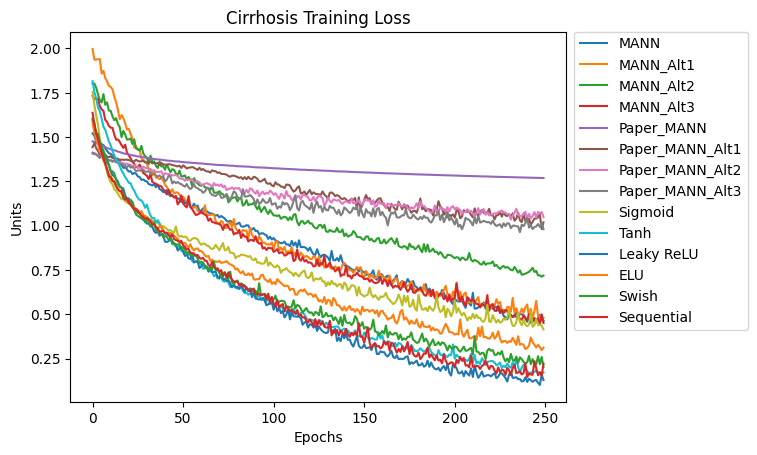

In [244]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')

plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['loss'], label='MANN_Alt1')

plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['loss'], label='MANN_Alt2')

plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['loss'], label='MANN_Alt3')

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3')


plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')

plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')

plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')

plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')

plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')

plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')

plt.title('Cirrhosis Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

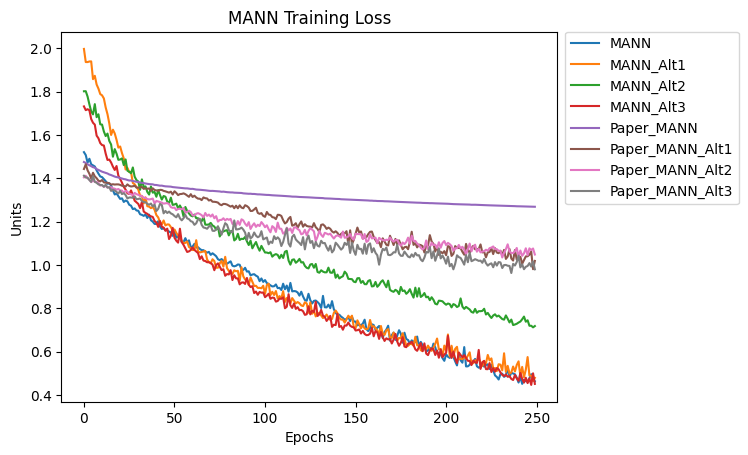

In [245]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')

plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['loss'], label='MANN_Alt1')

plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['loss'], label='MANN_Alt2')

plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['loss'], label='MANN_Alt3')

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3')

plt.title('MANN Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

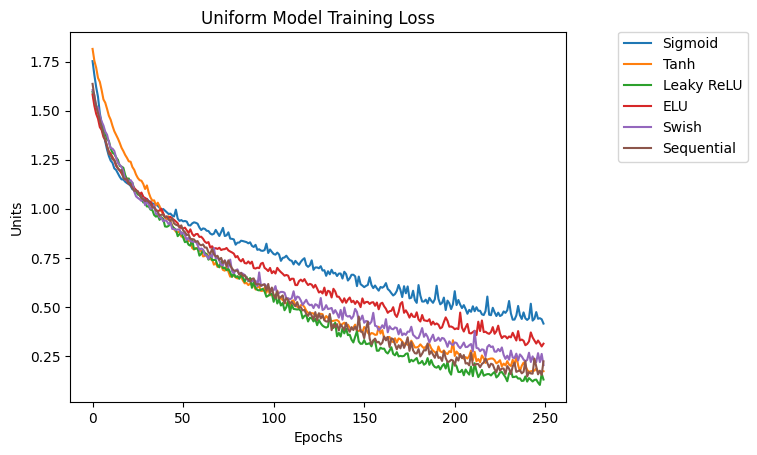

In [246]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')

plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')

plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')

plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')

plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')

plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')

plt.title('Uniform Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

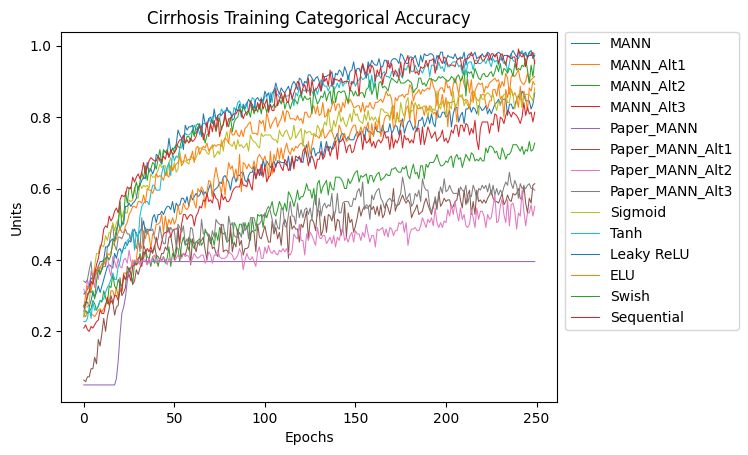

In [247]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Cirrhosis Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

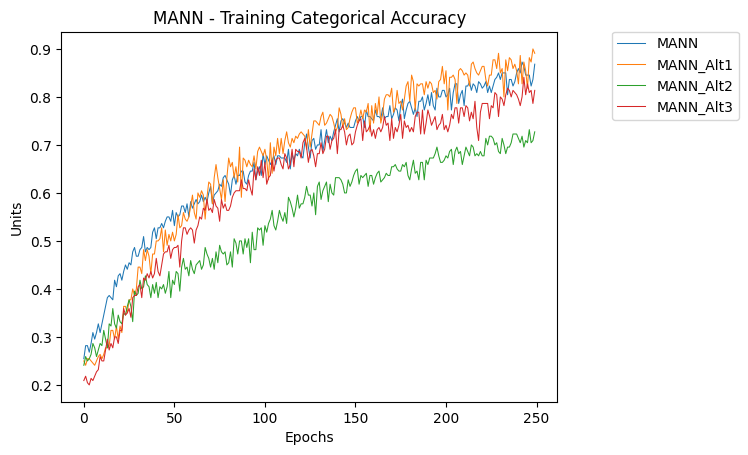

In [248]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('MANN - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

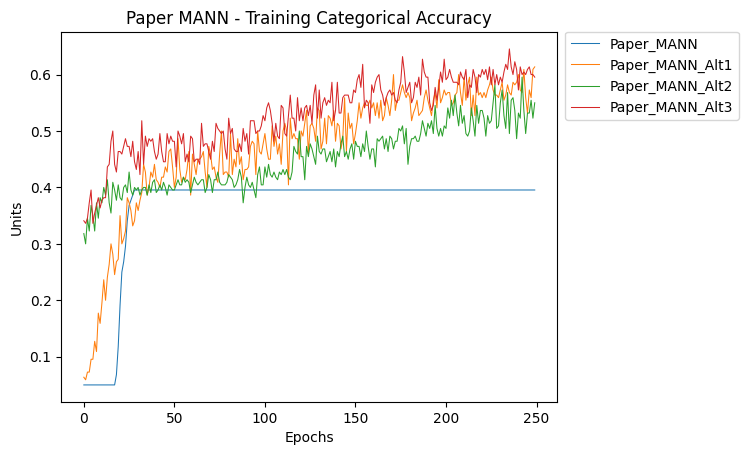

In [249]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Paper MANN - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

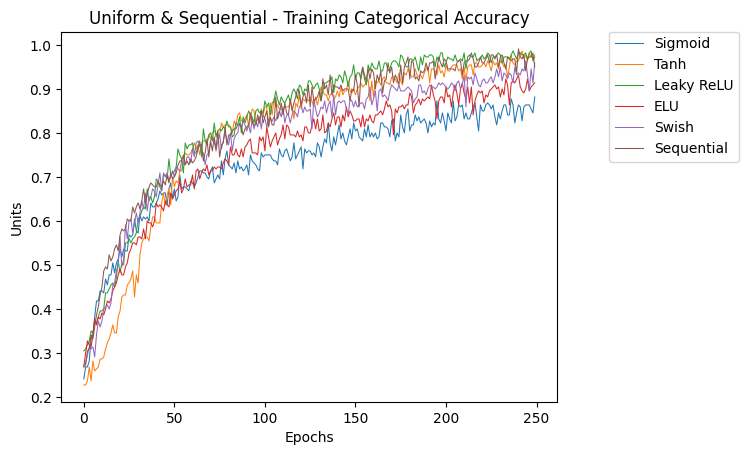

In [250]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Uniform & Sequential - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

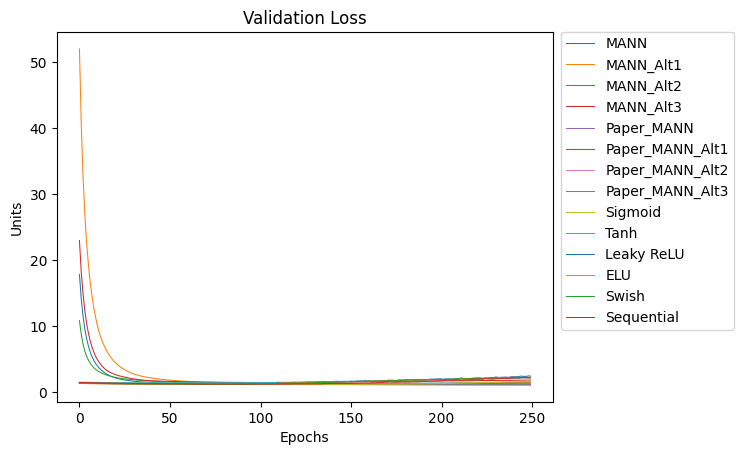

In [251]:
# Plot the validation loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['val_loss'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['val_loss'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['val_loss'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['val_loss'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['val_loss'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['val_loss'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['val_loss'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['val_loss'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['val_loss'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['val_loss'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['val_loss'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['val_loss'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['val_loss'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['val_loss'], label='Sequential', linewidth=0.75)

plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')
#plt.ylim([0,1.5])
plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

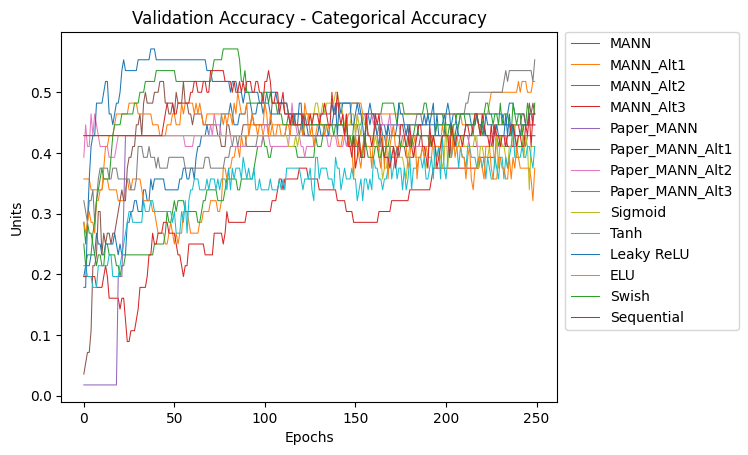

In [252]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['val_categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['val_categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['val_categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['val_categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['val_categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['val_categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['val_categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['val_categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['val_categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['val_categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['val_categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['val_categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['val_categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['val_categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Validation Accuracy - Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

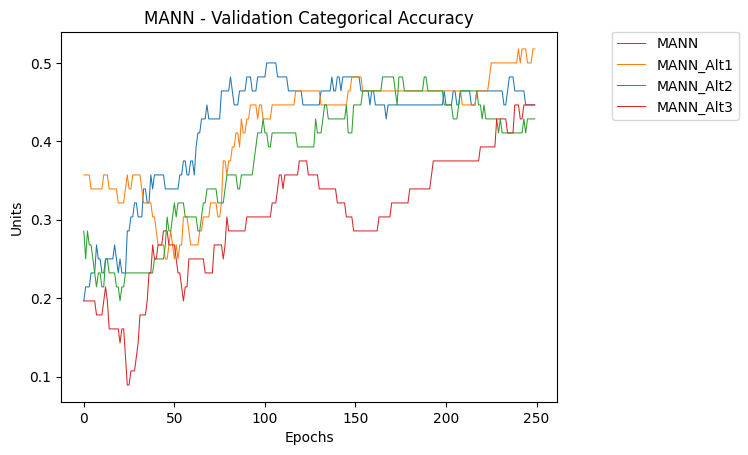

In [253]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['val_categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['val_categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['val_categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['val_categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('MANN - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

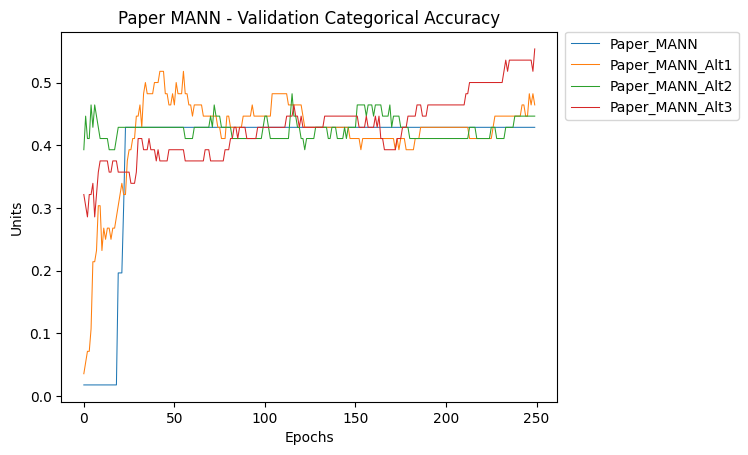

In [254]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['val_categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['val_categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['val_categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['val_categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Paper MANN - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

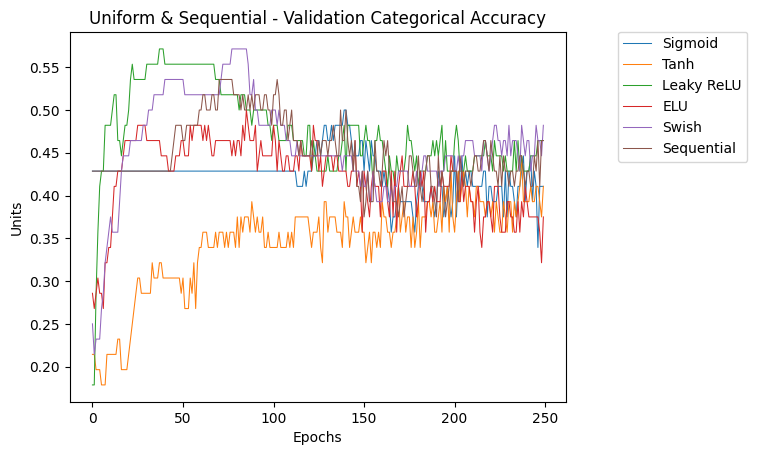

In [255]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['val_categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['val_categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['val_categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['val_categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['val_categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['val_categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Uniform & Sequential - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

In [256]:
# Save training history
train_hist_df = pd.DataFrame()
val_hist_df = pd.DataFrame()
for name, callback in histories.items():
    train_hist_df = pd.concat((train_hist_df, pd.DataFrame(callback.history['loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    val_hist_df = pd.concat((val_hist_df, pd.DataFrame(callback.history['val_loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    
train_hist_df.to_csv('Binary.training_hist.csv')
val_hist_df.to_csv('Binary.validation_hist.csv')

In [257]:
# Get performance metrics for each model
# Get the testing loss for each model
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, one_hot.inverse_transform(y_train).ravel())

metric = keras.metrics.CategoricalAccuracy()
metric.update_state(y_test.to_numpy(), one_hot.transform(log_reg.predict(X_test).reshape(-1,1)))
log_reg_loss = metric.result().numpy()

MANN_loss = models['MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt1_loss = models['MANN_Alt1'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt2_loss = models['MANN_Alt2'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt3_loss = models['MANN_Alt3'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Paper_MANN_loss = models['Paper_MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt1_loss = models['Paper_MANN_Alt1'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt2_loss = models['Paper_MANN_Alt2'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt3_loss = models['Paper_MANN_Alt3'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Sigmoid_loss = models['Sigmoid'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Tanh_loss = models['Tanh'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

LeakyReLU_loss = models['LeakyReLU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

ELU_loss = models['ELU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Swish_loss = models['Swish'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Sequential_loss = models['Sequential'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

2/2 [==============================] - 0s 7ms/step - loss: 2.1876 - categorical_accuracy: 0.4643


In [258]:
# Save metrics to a table and display results
# Save testing loss to table and display results
results = pd.DataFrame([MANN_loss, MANN_Alt1_loss, MANN_Alt2_loss, MANN_Alt3_loss, Paper_MANN_loss, Paper_MANN_Alt1_loss, Paper_MANN_Alt2_loss, Paper_MANN_Alt3_loss,Sigmoid_loss, Tanh_loss, LeakyReLU_loss, ELU_loss, Swish_loss, Sequential_loss],
                      index=['MANN', 'MANN_Alt1', 'MANN_Alt2', 'MANN_Alt3', 'Paper MANN', 'Paper Alternate MANN 1', 'Paper Alternate MANN 2', 'Paper Alternate MANN 3', 'Sigmoid NN', 'Tanh NN', 'Leaky ReLU NN', 'ELU NN', 'Swish NN', 'Sequential NN'],
                      columns=['Categorical Accuracy'])
results.sort_values('Categorical Accuracy', inplace=True, ascending=False)
results.head(20)

Categorical Accuracy
Paper Alternate MANN 3              0.553571
MANN_Alt1                           0.517857
Swish NN                            0.482143
Paper Alternate MANN 1              0.464286
Leaky ReLU NN                       0.464286
Sequential NN                       0.464286
MANN                                0.446429
MANN_Alt3                           0.446429
Paper Alternate MANN 2              0.446429
MANN_Alt2                           0.428571
Paper MANN                          0.428571
Sigmoid NN                          0.410714
Tanh NN                             0.410714
ELU NN                              0.375000

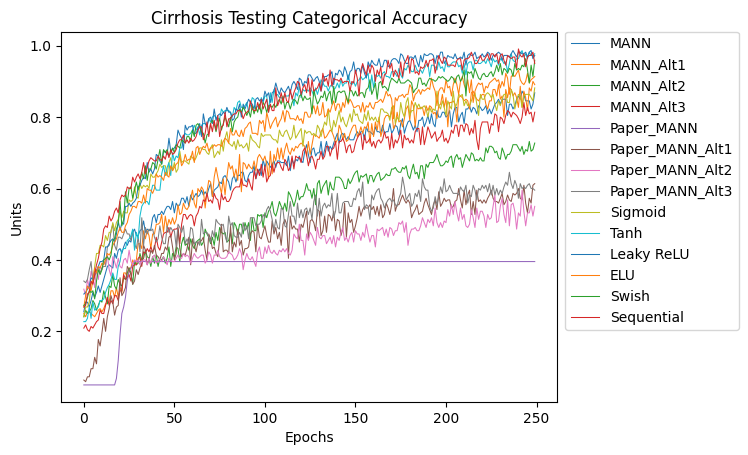

In [259]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Cirrhosis Testing Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

# 

# 

# Pulling HepatitisCdata Prediction Dataset data from the csv

In [260]:
# Load the data and split into testing and training for processing
HepatitisCdata = pd.read_csv('./Datasets/HepatitisCdata.csv')

HepatitisCdata.describe()

Unnamed: 0         Age         ALB         ALP         ALT         AST  \
count  615.000000  615.000000  614.000000  597.000000  614.000000  615.000000   
mean   308.000000   47.408130   41.620195   68.283920   28.450814   34.786341   
std    177.679487   10.055105    5.780629   26.028315   25.469689   33.090690   
min      1.000000   19.000000   14.900000   11.300000    0.900000   10.600000   
25%    154.500000   39.000000   38.800000   52.500000   16.400000   21.600000   
50%    308.000000   47.000000   41.950000   66.200000   23.000000   25.900000   
75%    461.500000   54.000000   45.200000   80.100000   33.075000   32.900000   
max    615.000000   77.000000   82.200000  416.600000  325.300000  324.000000   

              BIL         CHE        CHOL         CREA         GGT        PROT  
count  615.000000  615.000000  605.000000   615.000000  615.000000  614.000000  
mean    11.396748    8.196634    5.368099    81.287805   39.533171   72.044137  
std     19.673150    2.205657    1.132728    49.756166   54.661071    5.402636  
min      0.800000    1.420000    1.430000     8.000000    4.500000   44.800000  
25%      5.300000    6.935000    4.610000    67.000000   15.700000   69.300000  
50%      7.300000    8.260000    5.300000    77.000000   23.300000   72.200000  
75%     11.200000    9.590000    6.060000    88.000000   40.200000   75.400000  
max    254.000000   16.410000    9.670000  1079.100000  650.900000   90.000000

In [261]:
HepatitisCdata.head()

Unnamed: 0       Category  Age Sex   ALB   ALP   ALT   AST   BIL    CHE  \
0           1  0=Blood Donor   32   m  38.5  52.5   7.7  22.1   7.5   6.93   
1           2  0=Blood Donor   32   m  38.5  70.3  18.0  24.7   3.9  11.17   
2           3  0=Blood Donor   32   m  46.9  74.7  36.2  52.6   6.1   8.84   
3           4  0=Blood Donor   32   m  43.2  52.0  30.6  22.6  18.9   7.33   
4           5  0=Blood Donor   32   m  39.2  74.1  32.6  24.8   9.6   9.15   

   CHOL   CREA   GGT  PROT  
0  3.23  106.0  12.1  69.0  
1  4.80   74.0  15.6  76.5  
2  5.20   86.0  33.2  79.3  
3  4.74   80.0  33.8  75.7  
4  4.32   76.0  29.9  68.7

In [262]:
HepatitisCdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB


In [263]:
HepatitisCdata.isnull().sum()

Unnamed: 0     0
Category       0
Age            0
Sex            0
ALB            1
ALP           18
ALT            1
AST            0
BIL            0
CHE            0
CHOL          10
CREA           0
GGT            0
PROT           1
dtype: int64

## Assigning features and targets from dataset

In [264]:
HepatitisCdata = HepatitisCdata.dropna()

In [265]:
features = HepatitisCdata.drop(['Unnamed: 0','Category'], axis=1)

target = HepatitisCdata['Category']

In [266]:
features.head()

Age Sex   ALB   ALP   ALT   AST   BIL    CHE  CHOL   CREA   GGT  PROT
0   32   m  38.5  52.5   7.7  22.1   7.5   6.93  3.23  106.0  12.1  69.0
1   32   m  38.5  70.3  18.0  24.7   3.9  11.17  4.80   74.0  15.6  76.5
2   32   m  46.9  74.7  36.2  52.6   6.1   8.84  5.20   86.0  33.2  79.3
3   32   m  43.2  52.0  30.6  22.6  18.9   7.33  4.74   80.0  33.8  75.7
4   32   m  39.2  74.1  32.6  24.8   9.6   9.15  4.32   76.0  29.9  68.7

In [267]:
target.value_counts()

0=Blood Donor             526
3=Cirrhosis                24
1=Hepatitis                20
2=Fibrosis                 12
0s=suspect Blood Donor      7
Name: Category, dtype: int64

In [268]:
target = target.replace(regex={'0=Blood Donor': '0', '3=Cirrhosis': '3', '1=Hepatitis':'1', '2=Fibrosis':'2', '0s=suspect Blood Donor':'0'})

In [269]:
target.value_counts()

0    533
3     24
1     20
2     12
Name: Category, dtype: int64

In [270]:
HepatitisCdata.isnull().sum()

Unnamed: 0    0
Category      0
Age           0
Sex           0
ALB           0
ALP           0
ALT           0
AST           0
BIL           0
CHE           0
CHOL          0
CREA          0
GGT           0
PROT          0
dtype: int64

## Training the models

In [271]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

## Normalizing dataset

In [272]:
# Process and normalize the data
one_hot = OneHotEncoder(sparse_output=False)

# One-Hot encode categorical columns
X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['Sex']]), columns=one_hot.get_feature_names_out()))
X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['Sex']]), columns=one_hot.get_feature_names_out()))

# Drop the transformed columns and unneeded columns
X_train.drop(['Sex'], axis = 1, inplace=True)
X_test.drop(['Sex'], axis=1, inplace=True)



# Normalize numerical columns
scaler = StandardScaler()
X_train[['Age','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT', 'PROT']]= scaler.fit_transform(X_train[['Age','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT', 'PROT']])
X_test[['Age','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT', 'PROT']] = scaler.transform(X_test[['Age','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT', 'PROT']])

C:\Users\Jaskirat\AppData\Local\Temp\ipykernel_17868\2507058565.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['Sex']]), columns=one_hot.get_feature_names_out()))
C:\Users\Jaskirat\AppData\Local\Temp\ipykernel_17868\2507058565.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['Sex']]), columns=one_hot.get_feature_names_out()))


In [273]:
# One-Hot encode target labels
y_train = pd.DataFrame(data=one_hot.fit_transform(y_train.to_numpy().reshape(-1,1)), columns=one_hot.categories_)
y_test = pd.DataFrame(data=one_hot.transform(y_test.to_numpy().reshape(-1,1)), columns=one_hot.categories_)

In [274]:
print(one_hot.categories_[0])
print(len(one_hot.categories_[0]))

['0' '1' '2' '3']
4


In [275]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   (0,)    471 non-null    float64
 1   (1,)    471 non-null    float64
 2   (2,)    471 non-null    float64
 3   (3,)    471 non-null    float64
dtypes: float64(4)
memory usage: 14.8 KB


In [276]:
# Create and fit all neural networks for evaluations

models, histories = test(X_train.to_numpy(), y_train.to_numpy(), X_test=X_test.to_numpy(), y_test=y_test.to_numpy(), num_classes=len(one_hot.categories_[0]), task='classification', epochs=250, batch_size=128, task_name='HepatitisC')

Training Multi Activation Neural Network...
Epoch 1/250
4/4 [==============================] - 3s 143ms/step - loss: 1.6719 - categorical_accuracy: 0.3057 - val_loss: 11.5192 - val_categorical_accuracy: 0.1695
Epoch 2/250
4/4 [==============================] - 0s 71ms/step - loss: 1.6266 - categorical_accuracy: 0.3333 - val_loss: 8.3815 - val_categorical_accuracy: 0.1441
Epoch 3/250
4/4 [==============================] - 0s 73ms/step - loss: 1.5948 - categorical_accuracy: 0.3461 - val_loss: 6.6451 - val_categorical_accuracy: 0.1525
Epoch 4/250
4/4 [==============================] - 0s 69ms/step - loss: 1.5650 - categorical_accuracy: 0.3482 - val_loss: 5.5938 - val_categorical_accuracy: 0.1441
Epoch 5/250
4/4 [==============================] - 0s 67ms/step - loss: 1.5363 - categorical_accuracy: 0.3673 - val_loss: 4.8842 - val_categorical_accuracy: 0.1186
Epoch 6/250
4/4 [==============================] - 0s 64ms/step - loss: 1.5046 - categorical_accuracy: 0.3928 - val_loss: 4.3847 - val

4/4 [==============================] - 0s 55ms/step - loss: 0.6411 - categorical_accuracy: 0.9023 - val_loss: 0.8514 - val_categorical_accuracy: 0.7966
Epoch 51/250
4/4 [==============================] - 0s 52ms/step - loss: 0.6334 - categorical_accuracy: 0.9130 - val_loss: 0.8316 - val_categorical_accuracy: 0.7966
Epoch 52/250
4/4 [==============================] - 0s 53ms/step - loss: 0.6267 - categorical_accuracy: 0.9023 - val_loss: 0.8101 - val_categorical_accuracy: 0.7966
Epoch 53/250
4/4 [==============================] - 0s 51ms/step - loss: 0.6168 - categorical_accuracy: 0.9108 - val_loss: 0.7914 - val_categorical_accuracy: 0.8051
Epoch 54/250
4/4 [==============================] - 0s 54ms/step - loss: 0.5976 - categorical_accuracy: 0.9045 - val_loss: 0.7746 - val_categorical_accuracy: 0.8051
Epoch 55/250
4/4 [==============================] - 0s 60ms/step - loss: 0.5995 - categorical_accuracy: 0.9066 - val_loss: 0.7585 - val_categorical_accuracy: 0.8136
Epoch 56/250
4/4 [=====

Epoch 100/250
4/4 [==============================] - 0s 69ms/step - loss: 0.2757 - categorical_accuracy: 0.9406 - val_loss: 0.4126 - val_categorical_accuracy: 0.8898
Epoch 101/250
4/4 [==============================] - 0s 75ms/step - loss: 0.2690 - categorical_accuracy: 0.9427 - val_loss: 0.4059 - val_categorical_accuracy: 0.8898
Epoch 102/250
4/4 [==============================] - 0s 72ms/step - loss: 0.2747 - categorical_accuracy: 0.9512 - val_loss: 0.4015 - val_categorical_accuracy: 0.8898
Epoch 103/250
4/4 [==============================] - 0s 69ms/step - loss: 0.2575 - categorical_accuracy: 0.9448 - val_loss: 0.3972 - val_categorical_accuracy: 0.8898
Epoch 104/250
4/4 [==============================] - 0s 69ms/step - loss: 0.2570 - categorical_accuracy: 0.9469 - val_loss: 0.3937 - val_categorical_accuracy: 0.8898
Epoch 105/250
4/4 [==============================] - 0s 73ms/step - loss: 0.2579 - categorical_accuracy: 0.9384 - val_loss: 0.3893 - val_categorical_accuracy: 0.8898
Epoc

4/4 [==============================] - 0s 68ms/step - loss: 0.1585 - categorical_accuracy: 0.9554 - val_loss: 0.3381 - val_categorical_accuracy: 0.8814
Epoch 150/250
4/4 [==============================] - 0s 68ms/step - loss: 0.1544 - categorical_accuracy: 0.9575 - val_loss: 0.3358 - val_categorical_accuracy: 0.8814
Epoch 151/250
4/4 [==============================] - 0s 68ms/step - loss: 0.1552 - categorical_accuracy: 0.9512 - val_loss: 0.3345 - val_categorical_accuracy: 0.8814
Epoch 152/250
4/4 [==============================] - 0s 75ms/step - loss: 0.1586 - categorical_accuracy: 0.9533 - val_loss: 0.3333 - val_categorical_accuracy: 0.8814
Epoch 153/250
4/4 [==============================] - 0s 59ms/step - loss: 0.1675 - categorical_accuracy: 0.9554 - val_loss: 0.3381 - val_categorical_accuracy: 0.8814
Epoch 154/250
4/4 [==============================] - 0s 50ms/step - loss: 0.1661 - categorical_accuracy: 0.9575 - val_loss: 0.3372 - val_categorical_accuracy: 0.8814
Epoch 155/250
4/4 

4/4 [==============================] - 0s 49ms/step - loss: 0.1232 - categorical_accuracy: 0.9575 - val_loss: 0.3177 - val_categorical_accuracy: 0.8983
Epoch 199/250
4/4 [==============================] - 0s 52ms/step - loss: 0.1112 - categorical_accuracy: 0.9660 - val_loss: 0.3171 - val_categorical_accuracy: 0.9068
Epoch 200/250
4/4 [==============================] - 0s 50ms/step - loss: 0.1307 - categorical_accuracy: 0.9597 - val_loss: 0.3187 - val_categorical_accuracy: 0.9068
Epoch 201/250
4/4 [==============================] - 0s 53ms/step - loss: 0.1198 - categorical_accuracy: 0.9554 - val_loss: 0.3205 - val_categorical_accuracy: 0.9153
Epoch 202/250
4/4 [==============================] - 0s 49ms/step - loss: 0.1138 - categorical_accuracy: 0.9660 - val_loss: 0.3182 - val_categorical_accuracy: 0.9153
Epoch 203/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1120 - categorical_accuracy: 0.9554 - val_loss: 0.3173 - val_categorical_accuracy: 0.8983
Epoch 204/250
4/4 

4/4 [==============================] - 0s 49ms/step - loss: 0.0895 - categorical_accuracy: 0.9682 - val_loss: 0.3025 - val_categorical_accuracy: 0.9153
Epoch 248/250
4/4 [==============================] - 0s 52ms/step - loss: 0.0887 - categorical_accuracy: 0.9703 - val_loss: 0.3036 - val_categorical_accuracy: 0.9153
Epoch 249/250
4/4 [==============================] - 0s 53ms/step - loss: 0.0932 - categorical_accuracy: 0.9660 - val_loss: 0.3070 - val_categorical_accuracy: 0.9153
Epoch 250/250
4/4 [==============================] - 0s 48ms/step - loss: 0.0874 - categorical_accuracy: 0.9682 - val_loss: 0.3096 - val_categorical_accuracy: 0.9153
INFO:tensorflow:Assets written to: ./Models/250_Epochs/HepatitisC/MANN\assets
Training Complete
Epoch 1/250
4/4 [==============================] - 3s 133ms/step - loss: 1.8632 - categorical_accuracy: 0.2887 - val_loss: 15.0401 - val_categorical_accuracy: 0.1864
Epoch 2/250
4/4 [==============================] - 0s 62ms/step - loss: 1.8137 - categor

4/4 [==============================] - 0s 56ms/step - loss: 0.8139 - categorical_accuracy: 0.8217 - val_loss: 0.9155 - val_categorical_accuracy: 0.7542
Epoch 47/250
4/4 [==============================] - 0s 61ms/step - loss: 0.8171 - categorical_accuracy: 0.8089 - val_loss: 0.9017 - val_categorical_accuracy: 0.7627
Epoch 48/250
4/4 [==============================] - 0s 54ms/step - loss: 0.8087 - categorical_accuracy: 0.8259 - val_loss: 0.8862 - val_categorical_accuracy: 0.7627
Epoch 49/250
4/4 [==============================] - 0s 56ms/step - loss: 0.7751 - categorical_accuracy: 0.8450 - val_loss: 0.8706 - val_categorical_accuracy: 0.7797
Epoch 50/250
4/4 [==============================] - 0s 61ms/step - loss: 0.7875 - categorical_accuracy: 0.8301 - val_loss: 0.8594 - val_categorical_accuracy: 0.7797
Epoch 51/250
4/4 [==============================] - 0s 57ms/step - loss: 0.7464 - categorical_accuracy: 0.8620 - val_loss: 0.8471 - val_categorical_accuracy: 0.7797
Epoch 52/250
4/4 [=====

Epoch 96/250
4/4 [==============================] - 0s 80ms/step - loss: 0.3176 - categorical_accuracy: 0.9512 - val_loss: 0.4648 - val_categorical_accuracy: 0.8814
Epoch 97/250
4/4 [==============================] - 0s 85ms/step - loss: 0.3215 - categorical_accuracy: 0.9406 - val_loss: 0.4611 - val_categorical_accuracy: 0.8814
Epoch 98/250
4/4 [==============================] - 0s 81ms/step - loss: 0.3422 - categorical_accuracy: 0.9427 - val_loss: 0.4607 - val_categorical_accuracy: 0.8898
Epoch 99/250
4/4 [==============================] - 0s 80ms/step - loss: 0.3185 - categorical_accuracy: 0.9448 - val_loss: 0.4570 - val_categorical_accuracy: 0.8898
Epoch 100/250
4/4 [==============================] - 0s 74ms/step - loss: 0.3233 - categorical_accuracy: 0.9406 - val_loss: 0.4522 - val_categorical_accuracy: 0.8898
Epoch 101/250
4/4 [==============================] - 0s 69ms/step - loss: 0.3238 - categorical_accuracy: 0.9384 - val_loss: 0.4492 - val_categorical_accuracy: 0.8898
Epoch 10

4/4 [==============================] - 0s 74ms/step - loss: 0.1794 - categorical_accuracy: 0.9597 - val_loss: 0.3548 - val_categorical_accuracy: 0.8983
Epoch 146/250
4/4 [==============================] - 0s 78ms/step - loss: 0.1770 - categorical_accuracy: 0.9639 - val_loss: 0.3534 - val_categorical_accuracy: 0.8983
Epoch 147/250
4/4 [==============================] - 0s 68ms/step - loss: 0.1824 - categorical_accuracy: 0.9554 - val_loss: 0.3524 - val_categorical_accuracy: 0.8983
Epoch 148/250
4/4 [==============================] - 0s 68ms/step - loss: 0.1686 - categorical_accuracy: 0.9618 - val_loss: 0.3519 - val_categorical_accuracy: 0.8983
Epoch 149/250
4/4 [==============================] - 0s 76ms/step - loss: 0.1875 - categorical_accuracy: 0.9490 - val_loss: 0.3485 - val_categorical_accuracy: 0.8983
Epoch 150/250
4/4 [==============================] - 0s 85ms/step - loss: 0.1657 - categorical_accuracy: 0.9618 - val_loss: 0.3481 - val_categorical_accuracy: 0.8983
Epoch 151/250
4/4 

4/4 [==============================] - 0s 56ms/step - loss: 0.1216 - categorical_accuracy: 0.9639 - val_loss: 0.3127 - val_categorical_accuracy: 0.8983
Epoch 195/250
4/4 [==============================] - 0s 61ms/step - loss: 0.1263 - categorical_accuracy: 0.9639 - val_loss: 0.3110 - val_categorical_accuracy: 0.9068
Epoch 196/250
4/4 [==============================] - 0s 61ms/step - loss: 0.1277 - categorical_accuracy: 0.9618 - val_loss: 0.3101 - val_categorical_accuracy: 0.9068
Epoch 197/250
4/4 [==============================] - 0s 56ms/step - loss: 0.1197 - categorical_accuracy: 0.9660 - val_loss: 0.3085 - val_categorical_accuracy: 0.9068
Epoch 198/250
4/4 [==============================] - 0s 103ms/step - loss: 0.1293 - categorical_accuracy: 0.9618 - val_loss: 0.3084 - val_categorical_accuracy: 0.9068
Epoch 199/250
4/4 [==============================] - 0s 57ms/step - loss: 0.1350 - categorical_accuracy: 0.9597 - val_loss: 0.3067 - val_categorical_accuracy: 0.9068
Epoch 200/250
4/4

4/4 [==============================] - 0s 37ms/step - loss: 0.0937 - categorical_accuracy: 0.9682 - val_loss: 0.3025 - val_categorical_accuracy: 0.8898
Epoch 244/250
4/4 [==============================] - 0s 36ms/step - loss: 0.0921 - categorical_accuracy: 0.9703 - val_loss: 0.3033 - val_categorical_accuracy: 0.8898
Epoch 245/250
4/4 [==============================] - 0s 38ms/step - loss: 0.0860 - categorical_accuracy: 0.9703 - val_loss: 0.3039 - val_categorical_accuracy: 0.8898
Epoch 246/250
4/4 [==============================] - 0s 34ms/step - loss: 0.0894 - categorical_accuracy: 0.9703 - val_loss: 0.3058 - val_categorical_accuracy: 0.8898
Epoch 247/250
4/4 [==============================] - 0s 34ms/step - loss: 0.1035 - categorical_accuracy: 0.9639 - val_loss: 0.3061 - val_categorical_accuracy: 0.8898
Epoch 248/250
4/4 [==============================] - 0s 39ms/step - loss: 0.0936 - categorical_accuracy: 0.9724 - val_loss: 0.3062 - val_categorical_accuracy: 0.8814
Epoch 249/250
4/4 

4/4 [==============================] - 0s 70ms/step - loss: 1.0020 - categorical_accuracy: 0.7197 - val_loss: 0.9616 - val_categorical_accuracy: 0.7627
Epoch 43/250
4/4 [==============================] - 0s 72ms/step - loss: 0.9853 - categorical_accuracy: 0.7197 - val_loss: 0.9458 - val_categorical_accuracy: 0.7797
Epoch 44/250
4/4 [==============================] - 0s 71ms/step - loss: 0.9729 - categorical_accuracy: 0.7410 - val_loss: 0.9293 - val_categorical_accuracy: 0.7966
Epoch 45/250
4/4 [==============================] - 0s 69ms/step - loss: 0.9560 - categorical_accuracy: 0.7580 - val_loss: 0.9142 - val_categorical_accuracy: 0.8051
Epoch 46/250
4/4 [==============================] - 0s 75ms/step - loss: 0.9482 - categorical_accuracy: 0.7516 - val_loss: 0.8987 - val_categorical_accuracy: 0.8051
Epoch 47/250
4/4 [==============================] - 0s 81ms/step - loss: 0.9365 - categorical_accuracy: 0.7707 - val_loss: 0.8843 - val_categorical_accuracy: 0.8051
Epoch 48/250
4/4 [=====

Epoch 92/250
4/4 [==============================] - 0s 67ms/step - loss: 0.3774 - categorical_accuracy: 0.9406 - val_loss: 0.4448 - val_categorical_accuracy: 0.8898
Epoch 93/250
4/4 [==============================] - 0s 70ms/step - loss: 0.3652 - categorical_accuracy: 0.9427 - val_loss: 0.4390 - val_categorical_accuracy: 0.8898
Epoch 94/250
4/4 [==============================] - 0s 67ms/step - loss: 0.3547 - categorical_accuracy: 0.9406 - val_loss: 0.4341 - val_categorical_accuracy: 0.8898
Epoch 95/250
4/4 [==============================] - 0s 67ms/step - loss: 0.3463 - categorical_accuracy: 0.9490 - val_loss: 0.4287 - val_categorical_accuracy: 0.8983
Epoch 96/250
4/4 [==============================] - 0s 69ms/step - loss: 0.3379 - categorical_accuracy: 0.9469 - val_loss: 0.4232 - val_categorical_accuracy: 0.8983
Epoch 97/250
4/4 [==============================] - 0s 67ms/step - loss: 0.3252 - categorical_accuracy: 0.9512 - val_loss: 0.4179 - val_categorical_accuracy: 0.9068
Epoch 98/2

4/4 [==============================] - 0s 70ms/step - loss: 0.1754 - categorical_accuracy: 0.9575 - val_loss: 0.2913 - val_categorical_accuracy: 0.8983
Epoch 142/250
4/4 [==============================] - 0s 68ms/step - loss: 0.1586 - categorical_accuracy: 0.9639 - val_loss: 0.2884 - val_categorical_accuracy: 0.8983
Epoch 143/250
4/4 [==============================] - 0s 69ms/step - loss: 0.1500 - categorical_accuracy: 0.9639 - val_loss: 0.2868 - val_categorical_accuracy: 0.8983
Epoch 144/250
4/4 [==============================] - 0s 69ms/step - loss: 0.1575 - categorical_accuracy: 0.9682 - val_loss: 0.2862 - val_categorical_accuracy: 0.9068
Epoch 145/250
4/4 [==============================] - 0s 70ms/step - loss: 0.1523 - categorical_accuracy: 0.9724 - val_loss: 0.2844 - val_categorical_accuracy: 0.9068
Epoch 146/250
4/4 [==============================] - 0s 68ms/step - loss: 0.1629 - categorical_accuracy: 0.9575 - val_loss: 0.2823 - val_categorical_accuracy: 0.9068
Epoch 147/250
4/4 

4/4 [==============================] - 0s 50ms/step - loss: 0.0929 - categorical_accuracy: 0.9809 - val_loss: 0.2113 - val_categorical_accuracy: 0.9407
Epoch 191/250
4/4 [==============================] - 0s 49ms/step - loss: 0.0852 - categorical_accuracy: 0.9809 - val_loss: 0.2116 - val_categorical_accuracy: 0.9407
Epoch 192/250
4/4 [==============================] - 0s 70ms/step - loss: 0.0884 - categorical_accuracy: 0.9809 - val_loss: 0.2110 - val_categorical_accuracy: 0.9407
Epoch 193/250
4/4 [==============================] - 0s 68ms/step - loss: 0.0900 - categorical_accuracy: 0.9830 - val_loss: 0.2098 - val_categorical_accuracy: 0.9407
Epoch 194/250
4/4 [==============================] - 0s 49ms/step - loss: 0.1007 - categorical_accuracy: 0.9745 - val_loss: 0.2100 - val_categorical_accuracy: 0.9322
Epoch 195/250
4/4 [==============================] - 0s 72ms/step - loss: 0.0867 - categorical_accuracy: 0.9809 - val_loss: 0.2080 - val_categorical_accuracy: 0.9322
Epoch 196/250
4/4 

4/4 [==============================] - 0s 50ms/step - loss: 0.0620 - categorical_accuracy: 0.9894 - val_loss: 0.2084 - val_categorical_accuracy: 0.9407
Epoch 240/250
4/4 [==============================] - 0s 46ms/step - loss: 0.0625 - categorical_accuracy: 0.9894 - val_loss: 0.2065 - val_categorical_accuracy: 0.9407
Epoch 241/250
4/4 [==============================] - 0s 52ms/step - loss: 0.0606 - categorical_accuracy: 0.9936 - val_loss: 0.2074 - val_categorical_accuracy: 0.9407
Epoch 242/250
4/4 [==============================] - 0s 49ms/step - loss: 0.0816 - categorical_accuracy: 0.9766 - val_loss: 0.2097 - val_categorical_accuracy: 0.9407
Epoch 243/250
4/4 [==============================] - 0s 54ms/step - loss: 0.0673 - categorical_accuracy: 0.9894 - val_loss: 0.2080 - val_categorical_accuracy: 0.9407
Epoch 244/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0570 - categorical_accuracy: 0.9915 - val_loss: 0.2081 - val_categorical_accuracy: 0.9407
Epoch 245/250
4/4 

4/4 [==============================] - 0s 75ms/step - loss: 1.0921 - categorical_accuracy: 0.5499 - val_loss: 1.2130 - val_categorical_accuracy: 0.5169
Epoch 39/250
4/4 [==============================] - 0s 77ms/step - loss: 1.0877 - categorical_accuracy: 0.5563 - val_loss: 1.1979 - val_categorical_accuracy: 0.5339
Epoch 40/250
4/4 [==============================] - 0s 66ms/step - loss: 1.0637 - categorical_accuracy: 0.5775 - val_loss: 1.1833 - val_categorical_accuracy: 0.5424
Epoch 41/250
4/4 [==============================] - 0s 63ms/step - loss: 1.0554 - categorical_accuracy: 0.5945 - val_loss: 1.1691 - val_categorical_accuracy: 0.5593
Epoch 42/250
4/4 [==============================] - 0s 62ms/step - loss: 1.0394 - categorical_accuracy: 0.6008 - val_loss: 1.1544 - val_categorical_accuracy: 0.5593
Epoch 43/250
4/4 [==============================] - 0s 64ms/step - loss: 1.0270 - categorical_accuracy: 0.6242 - val_loss: 1.1419 - val_categorical_accuracy: 0.5932
Epoch 44/250
4/4 [=====

Epoch 88/250
4/4 [==============================] - 0s 77ms/step - loss: 0.4259 - categorical_accuracy: 0.9490 - val_loss: 0.5580 - val_categorical_accuracy: 0.8644
Epoch 89/250
4/4 [==============================] - 0s 70ms/step - loss: 0.4237 - categorical_accuracy: 0.9448 - val_loss: 0.5509 - val_categorical_accuracy: 0.8644
Epoch 90/250
4/4 [==============================] - 0s 67ms/step - loss: 0.4240 - categorical_accuracy: 0.9427 - val_loss: 0.5447 - val_categorical_accuracy: 0.8644
Epoch 91/250
4/4 [==============================] - 0s 78ms/step - loss: 0.4036 - categorical_accuracy: 0.9427 - val_loss: 0.5387 - val_categorical_accuracy: 0.8644
Epoch 92/250
4/4 [==============================] - 0s 85ms/step - loss: 0.3961 - categorical_accuracy: 0.9469 - val_loss: 0.5341 - val_categorical_accuracy: 0.8644
Epoch 93/250
4/4 [==============================] - 0s 72ms/step - loss: 0.3912 - categorical_accuracy: 0.9448 - val_loss: 0.5275 - val_categorical_accuracy: 0.8644
Epoch 94/2

4/4 [==============================] - 0s 78ms/step - loss: 0.1872 - categorical_accuracy: 0.9639 - val_loss: 0.3707 - val_categorical_accuracy: 0.8898
Epoch 138/250
4/4 [==============================] - 0s 59ms/step - loss: 0.1915 - categorical_accuracy: 0.9597 - val_loss: 0.3688 - val_categorical_accuracy: 0.8898
Epoch 139/250
4/4 [==============================] - 0s 82ms/step - loss: 0.2009 - categorical_accuracy: 0.9597 - val_loss: 0.3671 - val_categorical_accuracy: 0.8898
Epoch 140/250
4/4 [==============================] - 0s 60ms/step - loss: 0.1886 - categorical_accuracy: 0.9618 - val_loss: 0.3664 - val_categorical_accuracy: 0.8898
Epoch 141/250
4/4 [==============================] - 0s 77ms/step - loss: 0.1806 - categorical_accuracy: 0.9618 - val_loss: 0.3650 - val_categorical_accuracy: 0.8898
Epoch 142/250
4/4 [==============================] - 0s 65ms/step - loss: 0.1714 - categorical_accuracy: 0.9703 - val_loss: 0.3637 - val_categorical_accuracy: 0.8898
Epoch 143/250
4/4 

4/4 [==============================] - 0s 36ms/step - loss: 0.1117 - categorical_accuracy: 0.9724 - val_loss: 0.3413 - val_categorical_accuracy: 0.8983
Epoch 187/250
4/4 [==============================] - 0s 36ms/step - loss: 0.1226 - categorical_accuracy: 0.9682 - val_loss: 0.3416 - val_categorical_accuracy: 0.8983
Epoch 188/250
4/4 [==============================] - 0s 43ms/step - loss: 0.1134 - categorical_accuracy: 0.9724 - val_loss: 0.3438 - val_categorical_accuracy: 0.8983
Epoch 189/250
4/4 [==============================] - 0s 37ms/step - loss: 0.1161 - categorical_accuracy: 0.9682 - val_loss: 0.3451 - val_categorical_accuracy: 0.8983
Epoch 190/250
4/4 [==============================] - 0s 37ms/step - loss: 0.1154 - categorical_accuracy: 0.9745 - val_loss: 0.3464 - val_categorical_accuracy: 0.8983
Epoch 191/250
4/4 [==============================] - 0s 60ms/step - loss: 0.1189 - categorical_accuracy: 0.9703 - val_loss: 0.3473 - val_categorical_accuracy: 0.8983
Epoch 192/250
4/4 

4/4 [==============================] - 0s 46ms/step - loss: 0.0693 - categorical_accuracy: 0.9894 - val_loss: 0.3262 - val_categorical_accuracy: 0.8983
Epoch 236/250
4/4 [==============================] - 0s 49ms/step - loss: 0.0659 - categorical_accuracy: 0.9894 - val_loss: 0.3260 - val_categorical_accuracy: 0.8983
Epoch 237/250
4/4 [==============================] - 0s 41ms/step - loss: 0.0778 - categorical_accuracy: 0.9830 - val_loss: 0.3298 - val_categorical_accuracy: 0.8983
Epoch 238/250
4/4 [==============================] - 0s 59ms/step - loss: 0.0801 - categorical_accuracy: 0.9809 - val_loss: 0.3295 - val_categorical_accuracy: 0.8983
Epoch 239/250
4/4 [==============================] - 0s 45ms/step - loss: 0.0710 - categorical_accuracy: 0.9873 - val_loss: 0.3291 - val_categorical_accuracy: 0.8983
Epoch 240/250
4/4 [==============================] - 0s 44ms/step - loss: 0.0668 - categorical_accuracy: 0.9894 - val_loss: 0.3313 - val_categorical_accuracy: 0.8983
Epoch 241/250
4/4 

Epoch 34/250
4/4 [==============================] - 0s 29ms/step - loss: 0.9782 - categorical_accuracy: 0.9172 - val_loss: 1.0346 - val_categorical_accuracy: 0.8559
Epoch 35/250
4/4 [==============================] - 0s 27ms/step - loss: 0.9703 - categorical_accuracy: 0.9172 - val_loss: 1.0275 - val_categorical_accuracy: 0.8559
Epoch 36/250
4/4 [==============================] - 0s 29ms/step - loss: 0.9620 - categorical_accuracy: 0.9172 - val_loss: 1.0205 - val_categorical_accuracy: 0.8559
Epoch 37/250
4/4 [==============================] - 0s 27ms/step - loss: 0.9541 - categorical_accuracy: 0.9172 - val_loss: 1.0137 - val_categorical_accuracy: 0.8559
Epoch 38/250
4/4 [==============================] - 0s 28ms/step - loss: 0.9464 - categorical_accuracy: 0.9172 - val_loss: 1.0069 - val_categorical_accuracy: 0.8559
Epoch 39/250
4/4 [==============================] - 0s 30ms/step - loss: 0.9388 - categorical_accuracy: 0.9172 - val_loss: 1.0003 - val_categorical_accuracy: 0.8559
Epoch 40/2

Epoch 84/250
4/4 [==============================] - 0s 30ms/step - loss: 0.6840 - categorical_accuracy: 0.9172 - val_loss: 0.7851 - val_categorical_accuracy: 0.8559
Epoch 85/250
4/4 [==============================] - 0s 35ms/step - loss: 0.6799 - categorical_accuracy: 0.9172 - val_loss: 0.7819 - val_categorical_accuracy: 0.8559
Epoch 86/250
4/4 [==============================] - 0s 28ms/step - loss: 0.6760 - categorical_accuracy: 0.9172 - val_loss: 0.7787 - val_categorical_accuracy: 0.8559
Epoch 87/250
4/4 [==============================] - 0s 31ms/step - loss: 0.6722 - categorical_accuracy: 0.9172 - val_loss: 0.7755 - val_categorical_accuracy: 0.8559
Epoch 88/250
4/4 [==============================] - 0s 36ms/step - loss: 0.6682 - categorical_accuracy: 0.9172 - val_loss: 0.7724 - val_categorical_accuracy: 0.8559
Epoch 89/250
4/4 [==============================] - 0s 32ms/step - loss: 0.6645 - categorical_accuracy: 0.9172 - val_loss: 0.7693 - val_categorical_accuracy: 0.8559
Epoch 90/2

4/4 [==============================] - 0s 36ms/step - loss: 0.5401 - categorical_accuracy: 0.9172 - val_loss: 0.6730 - val_categorical_accuracy: 0.8559
Epoch 134/250
4/4 [==============================] - 0s 26ms/step - loss: 0.5381 - categorical_accuracy: 0.9172 - val_loss: 0.6715 - val_categorical_accuracy: 0.8559
Epoch 135/250
4/4 [==============================] - 0s 32ms/step - loss: 0.5361 - categorical_accuracy: 0.9172 - val_loss: 0.6700 - val_categorical_accuracy: 0.8559
Epoch 136/250
4/4 [==============================] - 0s 30ms/step - loss: 0.5341 - categorical_accuracy: 0.9172 - val_loss: 0.6686 - val_categorical_accuracy: 0.8559
Epoch 137/250
4/4 [==============================] - 0s 29ms/step - loss: 0.5322 - categorical_accuracy: 0.9172 - val_loss: 0.6672 - val_categorical_accuracy: 0.8559
Epoch 138/250
4/4 [==============================] - 0s 31ms/step - loss: 0.5303 - categorical_accuracy: 0.9172 - val_loss: 0.6659 - val_categorical_accuracy: 0.8559
Epoch 139/250
4/4 

4/4 [==============================] - 0s 31ms/step - loss: 0.4672 - categorical_accuracy: 0.9172 - val_loss: 0.6234 - val_categorical_accuracy: 0.8559
Epoch 183/250
4/4 [==============================] - 0s 26ms/step - loss: 0.4661 - categorical_accuracy: 0.9172 - val_loss: 0.6227 - val_categorical_accuracy: 0.8559
Epoch 184/250
4/4 [==============================] - 0s 28ms/step - loss: 0.4651 - categorical_accuracy: 0.9172 - val_loss: 0.6221 - val_categorical_accuracy: 0.8559
Epoch 185/250
4/4 [==============================] - 0s 27ms/step - loss: 0.4642 - categorical_accuracy: 0.9172 - val_loss: 0.6214 - val_categorical_accuracy: 0.8559
Epoch 186/250
4/4 [==============================] - 0s 25ms/step - loss: 0.4630 - categorical_accuracy: 0.9172 - val_loss: 0.6208 - val_categorical_accuracy: 0.8559
Epoch 187/250
4/4 [==============================] - 0s 27ms/step - loss: 0.4621 - categorical_accuracy: 0.9172 - val_loss: 0.6202 - val_categorical_accuracy: 0.8559
Epoch 188/250
4/4 

4/4 [==============================] - 0s 28ms/step - loss: 0.4287 - categorical_accuracy: 0.9172 - val_loss: 0.6022 - val_categorical_accuracy: 0.8559
Epoch 232/250
4/4 [==============================] - 0s 32ms/step - loss: 0.4282 - categorical_accuracy: 0.9172 - val_loss: 0.6019 - val_categorical_accuracy: 0.8559
Epoch 233/250
4/4 [==============================] - 0s 29ms/step - loss: 0.4276 - categorical_accuracy: 0.9172 - val_loss: 0.6017 - val_categorical_accuracy: 0.8559
Epoch 234/250
4/4 [==============================] - 0s 29ms/step - loss: 0.4271 - categorical_accuracy: 0.9172 - val_loss: 0.6014 - val_categorical_accuracy: 0.8559
Epoch 235/250
4/4 [==============================] - 0s 29ms/step - loss: 0.4265 - categorical_accuracy: 0.9172 - val_loss: 0.6012 - val_categorical_accuracy: 0.8559
Epoch 236/250
4/4 [==============================] - 0s 28ms/step - loss: 0.4261 - categorical_accuracy: 0.9172 - val_loss: 0.6009 - val_categorical_accuracy: 0.8559
Epoch 237/250
4/4 

4/4 [==============================] - 0s 30ms/step - loss: 0.6709 - categorical_accuracy: 0.9448 - val_loss: 0.6407 - val_categorical_accuracy: 0.9068
Epoch 30/250
4/4 [==============================] - 0s 37ms/step - loss: 0.6012 - categorical_accuracy: 0.9512 - val_loss: 0.5805 - val_categorical_accuracy: 0.9068
Epoch 31/250
4/4 [==============================] - 0s 41ms/step - loss: 0.5463 - categorical_accuracy: 0.9448 - val_loss: 0.5242 - val_categorical_accuracy: 0.9068
Epoch 32/250
4/4 [==============================] - 0s 32ms/step - loss: 0.5034 - categorical_accuracy: 0.9448 - val_loss: 0.4744 - val_categorical_accuracy: 0.9068
Epoch 33/250
4/4 [==============================] - 0s 31ms/step - loss: 0.4530 - categorical_accuracy: 0.9406 - val_loss: 0.4335 - val_categorical_accuracy: 0.9068
Epoch 34/250
4/4 [==============================] - 0s 34ms/step - loss: 0.3994 - categorical_accuracy: 0.9448 - val_loss: 0.3991 - val_categorical_accuracy: 0.9068
Epoch 35/250
4/4 [=====

Epoch 79/250
4/4 [==============================] - 0s 28ms/step - loss: 0.1555 - categorical_accuracy: 0.9554 - val_loss: 0.2240 - val_categorical_accuracy: 0.9068
Epoch 80/250
4/4 [==============================] - 0s 31ms/step - loss: 0.1392 - categorical_accuracy: 0.9490 - val_loss: 0.2233 - val_categorical_accuracy: 0.9068
Epoch 81/250
4/4 [==============================] - 0s 25ms/step - loss: 0.1513 - categorical_accuracy: 0.9533 - val_loss: 0.2220 - val_categorical_accuracy: 0.9068
Epoch 82/250
4/4 [==============================] - 0s 29ms/step - loss: 0.1510 - categorical_accuracy: 0.9490 - val_loss: 0.2200 - val_categorical_accuracy: 0.9068
Epoch 83/250
4/4 [==============================] - 0s 35ms/step - loss: 0.1393 - categorical_accuracy: 0.9512 - val_loss: 0.2183 - val_categorical_accuracy: 0.9068
Epoch 84/250
4/4 [==============================] - 0s 29ms/step - loss: 0.1424 - categorical_accuracy: 0.9469 - val_loss: 0.2177 - val_categorical_accuracy: 0.9068
Epoch 85/2

4/4 [==============================] - 0s 18ms/step - loss: 0.1192 - categorical_accuracy: 0.9533 - val_loss: 0.1975 - val_categorical_accuracy: 0.9068
Epoch 129/250
4/4 [==============================] - 0s 31ms/step - loss: 0.1128 - categorical_accuracy: 0.9533 - val_loss: 0.1972 - val_categorical_accuracy: 0.9068
Epoch 130/250
4/4 [==============================] - 0s 29ms/step - loss: 0.1184 - categorical_accuracy: 0.9512 - val_loss: 0.1966 - val_categorical_accuracy: 0.9068
Epoch 131/250
4/4 [==============================] - 0s 30ms/step - loss: 0.1203 - categorical_accuracy: 0.9490 - val_loss: 0.1957 - val_categorical_accuracy: 0.9068
Epoch 132/250
4/4 [==============================] - 0s 24ms/step - loss: 0.1157 - categorical_accuracy: 0.9533 - val_loss: 0.1958 - val_categorical_accuracy: 0.9068
Epoch 133/250
4/4 [==============================] - 0s 39ms/step - loss: 0.1038 - categorical_accuracy: 0.9533 - val_loss: 0.1957 - val_categorical_accuracy: 0.9068
Epoch 134/250
4/4 

4/4 [==============================] - 0s 20ms/step - loss: 0.0927 - categorical_accuracy: 0.9554 - val_loss: 0.1845 - val_categorical_accuracy: 0.9068
Epoch 178/250
4/4 [==============================] - 0s 33ms/step - loss: 0.1005 - categorical_accuracy: 0.9533 - val_loss: 0.1842 - val_categorical_accuracy: 0.9068
Epoch 179/250
4/4 [==============================] - 0s 29ms/step - loss: 0.1036 - categorical_accuracy: 0.9512 - val_loss: 0.1838 - val_categorical_accuracy: 0.9068
Epoch 180/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0996 - categorical_accuracy: 0.9533 - val_loss: 0.1835 - val_categorical_accuracy: 0.9068
Epoch 181/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0890 - categorical_accuracy: 0.9533 - val_loss: 0.1834 - val_categorical_accuracy: 0.9068
Epoch 182/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1107 - categorical_accuracy: 0.9490 - val_loss: 0.1841 - val_categorical_accuracy: 0.9068
Epoch 183/250
4/4 

4/4 [==============================] - 0s 18ms/step - loss: 0.1267 - categorical_accuracy: 0.9512 - val_loss: 0.1813 - val_categorical_accuracy: 0.9068
Epoch 227/250
4/4 [==============================] - 0s 18ms/step - loss: 0.0979 - categorical_accuracy: 0.9490 - val_loss: 0.1816 - val_categorical_accuracy: 0.9068
Epoch 228/250
4/4 [==============================] - 0s 19ms/step - loss: 0.0892 - categorical_accuracy: 0.9554 - val_loss: 0.1815 - val_categorical_accuracy: 0.9068
Epoch 229/250
4/4 [==============================] - 0s 19ms/step - loss: 0.0932 - categorical_accuracy: 0.9533 - val_loss: 0.1816 - val_categorical_accuracy: 0.9068
Epoch 230/250
4/4 [==============================] - 0s 20ms/step - loss: 0.0945 - categorical_accuracy: 0.9533 - val_loss: 0.1820 - val_categorical_accuracy: 0.9068
Epoch 231/250
4/4 [==============================] - 0s 18ms/step - loss: 0.0939 - categorical_accuracy: 0.9554 - val_loss: 0.1822 - val_categorical_accuracy: 0.9068
Epoch 232/250
4/4 

4/4 [==============================] - 0s 38ms/step - loss: 0.4893 - categorical_accuracy: 0.9406 - val_loss: 0.4790 - val_categorical_accuracy: 0.8898
Epoch 25/250
4/4 [==============================] - 0s 35ms/step - loss: 0.4456 - categorical_accuracy: 0.9363 - val_loss: 0.4432 - val_categorical_accuracy: 0.8898
Epoch 26/250
4/4 [==============================] - 0s 36ms/step - loss: 0.4279 - categorical_accuracy: 0.9299 - val_loss: 0.4149 - val_categorical_accuracy: 0.8898
Epoch 27/250
4/4 [==============================] - 0s 28ms/step - loss: 0.3707 - categorical_accuracy: 0.9363 - val_loss: 0.3916 - val_categorical_accuracy: 0.8898
Epoch 28/250
4/4 [==============================] - 0s 38ms/step - loss: 0.3654 - categorical_accuracy: 0.9406 - val_loss: 0.3709 - val_categorical_accuracy: 0.8898
Epoch 29/250
4/4 [==============================] - 0s 37ms/step - loss: 0.3403 - categorical_accuracy: 0.9406 - val_loss: 0.3535 - val_categorical_accuracy: 0.8898
Epoch 30/250
4/4 [=====

Epoch 74/250
4/4 [==============================] - 0s 37ms/step - loss: 0.1653 - categorical_accuracy: 0.9469 - val_loss: 0.2327 - val_categorical_accuracy: 0.9068
Epoch 75/250
4/4 [==============================] - 0s 38ms/step - loss: 0.1620 - categorical_accuracy: 0.9512 - val_loss: 0.2320 - val_categorical_accuracy: 0.9068
Epoch 76/250
4/4 [==============================] - 0s 35ms/step - loss: 0.1637 - categorical_accuracy: 0.9533 - val_loss: 0.2314 - val_categorical_accuracy: 0.9068
Epoch 77/250
4/4 [==============================] - 0s 25ms/step - loss: 0.1603 - categorical_accuracy: 0.9448 - val_loss: 0.2315 - val_categorical_accuracy: 0.9068
Epoch 78/250
4/4 [==============================] - 0s 26ms/step - loss: 0.1421 - categorical_accuracy: 0.9533 - val_loss: 0.2320 - val_categorical_accuracy: 0.9068
Epoch 79/250
4/4 [==============================] - 0s 26ms/step - loss: 0.1438 - categorical_accuracy: 0.9533 - val_loss: 0.2317 - val_categorical_accuracy: 0.9068
Epoch 80/2

4/4 [==============================] - 0s 31ms/step - loss: 0.1314 - categorical_accuracy: 0.9533 - val_loss: 0.2108 - val_categorical_accuracy: 0.9068
Epoch 124/250
4/4 [==============================] - 0s 33ms/step - loss: 0.1461 - categorical_accuracy: 0.9490 - val_loss: 0.2102 - val_categorical_accuracy: 0.9068
Epoch 125/250
4/4 [==============================] - 0s 28ms/step - loss: 0.1281 - categorical_accuracy: 0.9512 - val_loss: 0.2099 - val_categorical_accuracy: 0.9068
Epoch 126/250
4/4 [==============================] - 0s 30ms/step - loss: 0.1295 - categorical_accuracy: 0.9533 - val_loss: 0.2091 - val_categorical_accuracy: 0.9068
Epoch 127/250
4/4 [==============================] - 0s 29ms/step - loss: 0.1369 - categorical_accuracy: 0.9533 - val_loss: 0.2089 - val_categorical_accuracy: 0.9068
Epoch 128/250
4/4 [==============================] - 0s 30ms/step - loss: 0.1159 - categorical_accuracy: 0.9533 - val_loss: 0.2085 - val_categorical_accuracy: 0.9068
Epoch 129/250
4/4 

4/4 [==============================] - 0s 21ms/step - loss: 0.1141 - categorical_accuracy: 0.9533 - val_loss: 0.2057 - val_categorical_accuracy: 0.9153
Epoch 173/250
4/4 [==============================] - 0s 25ms/step - loss: 0.1163 - categorical_accuracy: 0.9512 - val_loss: 0.2061 - val_categorical_accuracy: 0.9153
Epoch 174/250
4/4 [==============================] - 0s 24ms/step - loss: 0.1076 - categorical_accuracy: 0.9533 - val_loss: 0.2057 - val_categorical_accuracy: 0.9153
Epoch 175/250
4/4 [==============================] - 0s 22ms/step - loss: 0.1225 - categorical_accuracy: 0.9512 - val_loss: 0.2055 - val_categorical_accuracy: 0.9153
Epoch 176/250
4/4 [==============================] - 0s 35ms/step - loss: 0.1146 - categorical_accuracy: 0.9533 - val_loss: 0.2054 - val_categorical_accuracy: 0.9153
Epoch 177/250
4/4 [==============================] - 0s 33ms/step - loss: 0.1163 - categorical_accuracy: 0.9512 - val_loss: 0.2044 - val_categorical_accuracy: 0.9068
Epoch 178/250
4/4 

4/4 [==============================] - 0s 17ms/step - loss: 0.1092 - categorical_accuracy: 0.9554 - val_loss: 0.2029 - val_categorical_accuracy: 0.9068
Epoch 222/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1009 - categorical_accuracy: 0.9512 - val_loss: 0.2034 - val_categorical_accuracy: 0.9153
Epoch 223/250
4/4 [==============================] - 0s 17ms/step - loss: 0.1035 - categorical_accuracy: 0.9554 - val_loss: 0.2041 - val_categorical_accuracy: 0.9153
Epoch 224/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1106 - categorical_accuracy: 0.9512 - val_loss: 0.2025 - val_categorical_accuracy: 0.9153
Epoch 225/250
4/4 [==============================] - 0s 21ms/step - loss: 0.0935 - categorical_accuracy: 0.9554 - val_loss: 0.2021 - val_categorical_accuracy: 0.9068
Epoch 226/250
4/4 [==============================] - 0s 13ms/step - loss: 0.1024 - categorical_accuracy: 0.9554 - val_loss: 0.2024 - val_categorical_accuracy: 0.9153
Epoch 227/250
4/4 

4/4 [==============================] - 0s 35ms/step - loss: 0.4561 - categorical_accuracy: 0.9172 - val_loss: 0.5348 - val_categorical_accuracy: 0.8559
Epoch 20/250
4/4 [==============================] - 0s 37ms/step - loss: 0.4576 - categorical_accuracy: 0.9193 - val_loss: 0.5200 - val_categorical_accuracy: 0.8559
Epoch 21/250
4/4 [==============================] - 0s 35ms/step - loss: 0.3897 - categorical_accuracy: 0.9214 - val_loss: 0.5039 - val_categorical_accuracy: 0.8559
Epoch 22/250
4/4 [==============================] - 0s 38ms/step - loss: 0.4119 - categorical_accuracy: 0.9193 - val_loss: 0.4907 - val_categorical_accuracy: 0.8559
Epoch 23/250
4/4 [==============================] - 0s 37ms/step - loss: 0.3916 - categorical_accuracy: 0.9236 - val_loss: 0.4764 - val_categorical_accuracy: 0.8559
Epoch 24/250
4/4 [==============================] - 0s 32ms/step - loss: 0.3415 - categorical_accuracy: 0.9236 - val_loss: 0.4643 - val_categorical_accuracy: 0.8559
Epoch 25/250
4/4 [=====

Epoch 69/250
4/4 [==============================] - 0s 28ms/step - loss: 0.1615 - categorical_accuracy: 0.9257 - val_loss: 0.2821 - val_categorical_accuracy: 0.8729
Epoch 70/250
4/4 [==============================] - 0s 25ms/step - loss: 0.1823 - categorical_accuracy: 0.9193 - val_loss: 0.2777 - val_categorical_accuracy: 0.8814
Epoch 71/250
4/4 [==============================] - 0s 26ms/step - loss: 0.1549 - categorical_accuracy: 0.9299 - val_loss: 0.2760 - val_categorical_accuracy: 0.8814
Epoch 72/250
4/4 [==============================] - 0s 29ms/step - loss: 0.1513 - categorical_accuracy: 0.9342 - val_loss: 0.2750 - val_categorical_accuracy: 0.8814
Epoch 73/250
4/4 [==============================] - 0s 28ms/step - loss: 0.1561 - categorical_accuracy: 0.9342 - val_loss: 0.2735 - val_categorical_accuracy: 0.8814
Epoch 74/250
4/4 [==============================] - 0s 25ms/step - loss: 0.1614 - categorical_accuracy: 0.9257 - val_loss: 0.2720 - val_categorical_accuracy: 0.8814
Epoch 75/2

4/4 [==============================] - 0s 19ms/step - loss: 0.1365 - categorical_accuracy: 0.9299 - val_loss: 0.2431 - val_categorical_accuracy: 0.8814
Epoch 119/250
4/4 [==============================] - 0s 16ms/step - loss: 0.1383 - categorical_accuracy: 0.9299 - val_loss: 0.2442 - val_categorical_accuracy: 0.8814
Epoch 120/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1391 - categorical_accuracy: 0.9427 - val_loss: 0.2419 - val_categorical_accuracy: 0.8814
Epoch 121/250
4/4 [==============================] - 0s 31ms/step - loss: 0.1288 - categorical_accuracy: 0.9469 - val_loss: 0.2407 - val_categorical_accuracy: 0.8898
Epoch 122/250
4/4 [==============================] - 0s 28ms/step - loss: 0.1300 - categorical_accuracy: 0.9469 - val_loss: 0.2403 - val_categorical_accuracy: 0.8898
Epoch 123/250
4/4 [==============================] - 0s 32ms/step - loss: 0.1302 - categorical_accuracy: 0.9384 - val_loss: 0.2395 - val_categorical_accuracy: 0.8983
Epoch 124/250
4/4 

4/4 [==============================] - 0s 31ms/step - loss: 0.1185 - categorical_accuracy: 0.9512 - val_loss: 0.2266 - val_categorical_accuracy: 0.9068
Epoch 168/250
4/4 [==============================] - 0s 36ms/step - loss: 0.1126 - categorical_accuracy: 0.9512 - val_loss: 0.2261 - val_categorical_accuracy: 0.9068
Epoch 169/250
4/4 [==============================] - 0s 33ms/step - loss: 0.1152 - categorical_accuracy: 0.9533 - val_loss: 0.2253 - val_categorical_accuracy: 0.9068
Epoch 170/250
4/4 [==============================] - 0s 39ms/step - loss: 0.1140 - categorical_accuracy: 0.9512 - val_loss: 0.2243 - val_categorical_accuracy: 0.9068
Epoch 171/250
4/4 [==============================] - 0s 22ms/step - loss: 0.1088 - categorical_accuracy: 0.9533 - val_loss: 0.2248 - val_categorical_accuracy: 0.9068
Epoch 172/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1037 - categorical_accuracy: 0.9533 - val_loss: 0.2250 - val_categorical_accuracy: 0.9068
Epoch 173/250
4/4 

4/4 [==============================] - 0s 22ms/step - loss: 0.1176 - categorical_accuracy: 0.9533 - val_loss: 0.2182 - val_categorical_accuracy: 0.9068
Epoch 217/250
4/4 [==============================] - 0s 25ms/step - loss: 0.1029 - categorical_accuracy: 0.9533 - val_loss: 0.2182 - val_categorical_accuracy: 0.9068
Epoch 218/250
4/4 [==============================] - 0s 24ms/step - loss: 0.1012 - categorical_accuracy: 0.9533 - val_loss: 0.2185 - val_categorical_accuracy: 0.9068
Epoch 219/250
4/4 [==============================] - 0s 25ms/step - loss: 0.1075 - categorical_accuracy: 0.9533 - val_loss: 0.2182 - val_categorical_accuracy: 0.9068
Epoch 220/250
4/4 [==============================] - 0s 25ms/step - loss: 0.1003 - categorical_accuracy: 0.9533 - val_loss: 0.2184 - val_categorical_accuracy: 0.9068
Epoch 221/250
4/4 [==============================] - 0s 23ms/step - loss: 0.1032 - categorical_accuracy: 0.9533 - val_loss: 0.2186 - val_categorical_accuracy: 0.9068
Epoch 222/250
4/4 

4/4 [==============================] - 0s 63ms/step - loss: 1.1076 - categorical_accuracy: 0.7219 - val_loss: 1.0655 - val_categorical_accuracy: 0.8559
Epoch 15/250
4/4 [==============================] - 0s 51ms/step - loss: 1.0826 - categorical_accuracy: 0.7325 - val_loss: 1.0486 - val_categorical_accuracy: 0.8559
Epoch 16/250
4/4 [==============================] - 0s 55ms/step - loss: 1.0603 - categorical_accuracy: 0.7834 - val_loss: 1.0321 - val_categorical_accuracy: 0.8559
Epoch 17/250
4/4 [==============================] - 0s 64ms/step - loss: 1.0463 - categorical_accuracy: 0.7686 - val_loss: 1.0154 - val_categorical_accuracy: 0.8559
Epoch 18/250
4/4 [==============================] - 0s 48ms/step - loss: 1.0220 - categorical_accuracy: 0.7856 - val_loss: 0.9980 - val_categorical_accuracy: 0.8559
Epoch 19/250
4/4 [==============================] - 0s 47ms/step - loss: 1.0088 - categorical_accuracy: 0.8068 - val_loss: 0.9816 - val_categorical_accuracy: 0.8559
Epoch 20/250
4/4 [=====

Epoch 64/250
4/4 [==============================] - 0s 52ms/step - loss: 0.4122 - categorical_accuracy: 0.9363 - val_loss: 0.5603 - val_categorical_accuracy: 0.8559
Epoch 65/250
4/4 [==============================] - 0s 33ms/step - loss: 0.3560 - categorical_accuracy: 0.9724 - val_loss: 0.5626 - val_categorical_accuracy: 0.8559
Epoch 66/250
4/4 [==============================] - 0s 33ms/step - loss: 0.3404 - categorical_accuracy: 0.9724 - val_loss: 0.5604 - val_categorical_accuracy: 0.8559
Epoch 67/250
4/4 [==============================] - 0s 32ms/step - loss: 0.3356 - categorical_accuracy: 0.9745 - val_loss: 0.5608 - val_categorical_accuracy: 0.8559
Epoch 68/250
4/4 [==============================] - 0s 33ms/step - loss: 0.3336 - categorical_accuracy: 0.9703 - val_loss: 0.5627 - val_categorical_accuracy: 0.8559
Epoch 69/250
4/4 [==============================] - 0s 34ms/step - loss: 0.3373 - categorical_accuracy: 0.9660 - val_loss: 0.5668 - val_categorical_accuracy: 0.8559
Epoch 70/2

4/4 [==============================] - 0s 38ms/step - loss: 0.1480 - categorical_accuracy: 0.9873 - val_loss: 0.4474 - val_categorical_accuracy: 0.8644
Epoch 114/250
4/4 [==============================] - 0s 32ms/step - loss: 0.1275 - categorical_accuracy: 0.9851 - val_loss: 0.4376 - val_categorical_accuracy: 0.8644
Epoch 115/250
4/4 [==============================] - 0s 51ms/step - loss: 0.1231 - categorical_accuracy: 0.9936 - val_loss: 0.4312 - val_categorical_accuracy: 0.8644
Epoch 116/250
4/4 [==============================] - 0s 52ms/step - loss: 0.1326 - categorical_accuracy: 0.9894 - val_loss: 0.4090 - val_categorical_accuracy: 0.8644
Epoch 117/250
4/4 [==============================] - 0s 53ms/step - loss: 0.1224 - categorical_accuracy: 0.9851 - val_loss: 0.3954 - val_categorical_accuracy: 0.8644
Epoch 118/250
4/4 [==============================] - 0s 53ms/step - loss: 0.1249 - categorical_accuracy: 0.9894 - val_loss: 0.3824 - val_categorical_accuracy: 0.8644
Epoch 119/250
4/4 

4/4 [==============================] - 0s 34ms/step - loss: 0.0685 - categorical_accuracy: 0.9894 - val_loss: 0.2222 - val_categorical_accuracy: 0.9322
Epoch 163/250
4/4 [==============================] - 0s 36ms/step - loss: 0.0751 - categorical_accuracy: 0.9915 - val_loss: 0.2295 - val_categorical_accuracy: 0.9322
Epoch 164/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0694 - categorical_accuracy: 0.9936 - val_loss: 0.2263 - val_categorical_accuracy: 0.9322
Epoch 165/250
4/4 [==============================] - 0s 35ms/step - loss: 0.0659 - categorical_accuracy: 0.9958 - val_loss: 0.2343 - val_categorical_accuracy: 0.9322
Epoch 166/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0643 - categorical_accuracy: 0.9936 - val_loss: 0.2218 - val_categorical_accuracy: 0.9322
Epoch 167/250
4/4 [==============================] - 0s 40ms/step - loss: 0.0754 - categorical_accuracy: 0.9894 - val_loss: 0.2319 - val_categorical_accuracy: 0.9322
Epoch 168/250
4/4 

4/4 [==============================] - 0s 34ms/step - loss: 0.0438 - categorical_accuracy: 0.9958 - val_loss: 0.2021 - val_categorical_accuracy: 0.9407
Epoch 212/250
4/4 [==============================] - 0s 36ms/step - loss: 0.0492 - categorical_accuracy: 0.9915 - val_loss: 0.2543 - val_categorical_accuracy: 0.9407
Epoch 213/250
4/4 [==============================] - 0s 34ms/step - loss: 0.0435 - categorical_accuracy: 0.9958 - val_loss: 0.2063 - val_categorical_accuracy: 0.9407
Epoch 214/250
4/4 [==============================] - 0s 41ms/step - loss: 0.0379 - categorical_accuracy: 0.9979 - val_loss: 0.2071 - val_categorical_accuracy: 0.9407
Epoch 215/250
4/4 [==============================] - 0s 39ms/step - loss: 0.0352 - categorical_accuracy: 1.0000 - val_loss: 0.2055 - val_categorical_accuracy: 0.9407
Epoch 216/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0519 - categorical_accuracy: 0.9958 - val_loss: 0.2220 - val_categorical_accuracy: 0.9322
Epoch 217/250
4/4 

4/4 [==============================] - 0s 58ms/step - loss: 1.2400 - categorical_accuracy: 0.4904 - val_loss: 1.0303 - val_categorical_accuracy: 0.8559
Epoch 10/250
4/4 [==============================] - 0s 61ms/step - loss: 1.2223 - categorical_accuracy: 0.5456 - val_loss: 1.0077 - val_categorical_accuracy: 0.8729
Epoch 11/250
4/4 [==============================] - 0s 62ms/step - loss: 1.1918 - categorical_accuracy: 0.5478 - val_loss: 0.9868 - val_categorical_accuracy: 0.8729
Epoch 12/250
4/4 [==============================] - 0s 48ms/step - loss: 1.1744 - categorical_accuracy: 0.5881 - val_loss: 0.9725 - val_categorical_accuracy: 0.8814
Epoch 13/250
4/4 [==============================] - 0s 45ms/step - loss: 1.1569 - categorical_accuracy: 0.6030 - val_loss: 0.9561 - val_categorical_accuracy: 0.8983
Epoch 14/250
4/4 [==============================] - 0s 46ms/step - loss: 1.1405 - categorical_accuracy: 0.5987 - val_loss: 0.9408 - val_categorical_accuracy: 0.9068
Epoch 15/250
4/4 [=====

Epoch 59/250
4/4 [==============================] - 0s 59ms/step - loss: 0.3976 - categorical_accuracy: 0.9724 - val_loss: 0.3221 - val_categorical_accuracy: 0.9153
Epoch 60/250
4/4 [==============================] - 0s 54ms/step - loss: 0.3703 - categorical_accuracy: 0.9809 - val_loss: 0.3179 - val_categorical_accuracy: 0.9153
Epoch 61/250
4/4 [==============================] - 0s 63ms/step - loss: 0.3828 - categorical_accuracy: 0.9660 - val_loss: 0.3070 - val_categorical_accuracy: 0.9153
Epoch 62/250
4/4 [==============================] - 0s 59ms/step - loss: 0.3417 - categorical_accuracy: 0.9851 - val_loss: 0.3045 - val_categorical_accuracy: 0.9153
Epoch 63/250
4/4 [==============================] - 0s 49ms/step - loss: 0.3284 - categorical_accuracy: 0.9809 - val_loss: 0.2916 - val_categorical_accuracy: 0.9153
Epoch 64/250
4/4 [==============================] - 0s 65ms/step - loss: 0.3405 - categorical_accuracy: 0.9703 - val_loss: 0.2880 - val_categorical_accuracy: 0.9153
Epoch 65/2

4/4 [==============================] - 0s 40ms/step - loss: 0.1002 - categorical_accuracy: 0.9979 - val_loss: 0.1834 - val_categorical_accuracy: 0.9407
Epoch 109/250
4/4 [==============================] - 0s 34ms/step - loss: 0.0935 - categorical_accuracy: 1.0000 - val_loss: 0.1783 - val_categorical_accuracy: 0.9407
Epoch 110/250
4/4 [==============================] - 0s 39ms/step - loss: 0.0865 - categorical_accuracy: 1.0000 - val_loss: 0.1805 - val_categorical_accuracy: 0.9407
Epoch 111/250
4/4 [==============================] - 0s 32ms/step - loss: 0.1187 - categorical_accuracy: 0.9851 - val_loss: 0.1802 - val_categorical_accuracy: 0.9407
Epoch 112/250
4/4 [==============================] - 0s 35ms/step - loss: 0.0964 - categorical_accuracy: 0.9936 - val_loss: 0.1791 - val_categorical_accuracy: 0.9407
Epoch 113/250
4/4 [==============================] - 0s 41ms/step - loss: 0.0913 - categorical_accuracy: 0.9958 - val_loss: 0.1899 - val_categorical_accuracy: 0.9322
Epoch 114/250
4/4 

4/4 [==============================] - 0s 32ms/step - loss: 0.0356 - categorical_accuracy: 1.0000 - val_loss: 0.2102 - val_categorical_accuracy: 0.9407
Epoch 158/250
4/4 [==============================] - 0s 43ms/step - loss: 0.0332 - categorical_accuracy: 1.0000 - val_loss: 0.2120 - val_categorical_accuracy: 0.9322
Epoch 159/250
4/4 [==============================] - 0s 42ms/step - loss: 0.0319 - categorical_accuracy: 1.0000 - val_loss: 0.2151 - val_categorical_accuracy: 0.9322
Epoch 160/250
4/4 [==============================] - 0s 35ms/step - loss: 0.0305 - categorical_accuracy: 1.0000 - val_loss: 0.2156 - val_categorical_accuracy: 0.9322
Epoch 161/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0303 - categorical_accuracy: 1.0000 - val_loss: 0.2156 - val_categorical_accuracy: 0.9322
Epoch 162/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0315 - categorical_accuracy: 1.0000 - val_loss: 0.2111 - val_categorical_accuracy: 0.9322
Epoch 163/250
4/4 

4/4 [==============================] - 0s 37ms/step - loss: 0.0227 - categorical_accuracy: 1.0000 - val_loss: 0.2380 - val_categorical_accuracy: 0.9322
Epoch 207/250
4/4 [==============================] - 0s 26ms/step - loss: 0.0171 - categorical_accuracy: 1.0000 - val_loss: 0.2343 - val_categorical_accuracy: 0.9322
Epoch 208/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0168 - categorical_accuracy: 1.0000 - val_loss: 0.2322 - val_categorical_accuracy: 0.9322
Epoch 209/250
4/4 [==============================] - 0s 28ms/step - loss: 0.0166 - categorical_accuracy: 1.0000 - val_loss: 0.2298 - val_categorical_accuracy: 0.9322
Epoch 210/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0191 - categorical_accuracy: 1.0000 - val_loss: 0.2257 - val_categorical_accuracy: 0.9407
Epoch 211/250
4/4 [==============================] - 0s 28ms/step - loss: 0.0183 - categorical_accuracy: 1.0000 - val_loss: 0.2269 - val_categorical_accuracy: 0.9407
Epoch 212/250
4/4 

4/4 [==============================] - 0s 47ms/step - loss: 1.4823 - categorical_accuracy: 0.2208 - val_loss: 1.3394 - val_categorical_accuracy: 0.6017
Epoch 5/250
4/4 [==============================] - 0s 56ms/step - loss: 1.4373 - categorical_accuracy: 0.2739 - val_loss: 1.3291 - val_categorical_accuracy: 0.7034
Epoch 6/250
4/4 [==============================] - 0s 56ms/step - loss: 1.4067 - categorical_accuracy: 0.3121 - val_loss: 1.3195 - val_categorical_accuracy: 0.7542
Epoch 7/250
4/4 [==============================] - 0s 61ms/step - loss: 1.3692 - categorical_accuracy: 0.3333 - val_loss: 1.3085 - val_categorical_accuracy: 0.7966
Epoch 8/250
4/4 [==============================] - 0s 52ms/step - loss: 1.3334 - categorical_accuracy: 0.3864 - val_loss: 1.2978 - val_categorical_accuracy: 0.8136
Epoch 9/250
4/4 [==============================] - 0s 47ms/step - loss: 1.3311 - categorical_accuracy: 0.3992 - val_loss: 1.2878 - val_categorical_accuracy: 0.8220
Epoch 10/250
4/4 [==========

Epoch 54/250
4/4 [==============================] - 0s 59ms/step - loss: 0.4804 - categorical_accuracy: 0.9639 - val_loss: 0.4541 - val_categorical_accuracy: 0.9153
Epoch 55/250
4/4 [==============================] - 0s 59ms/step - loss: 0.4733 - categorical_accuracy: 0.9682 - val_loss: 0.4450 - val_categorical_accuracy: 0.9153
Epoch 56/250
4/4 [==============================] - 0s 57ms/step - loss: 0.4738 - categorical_accuracy: 0.9575 - val_loss: 0.4309 - val_categorical_accuracy: 0.9322
Epoch 57/250
4/4 [==============================] - 0s 73ms/step - loss: 0.4421 - categorical_accuracy: 0.9682 - val_loss: 0.4202 - val_categorical_accuracy: 0.9322
Epoch 58/250
4/4 [==============================] - 0s 64ms/step - loss: 0.4415 - categorical_accuracy: 0.9618 - val_loss: 0.4083 - val_categorical_accuracy: 0.9322
Epoch 59/250
4/4 [==============================] - 0s 60ms/step - loss: 0.4296 - categorical_accuracy: 0.9660 - val_loss: 0.3976 - val_categorical_accuracy: 0.9322
Epoch 60/2

4/4 [==============================] - 0s 39ms/step - loss: 0.1898 - categorical_accuracy: 0.9682 - val_loss: 0.2138 - val_categorical_accuracy: 0.9153
Epoch 104/250
4/4 [==============================] - 0s 35ms/step - loss: 0.1623 - categorical_accuracy: 0.9809 - val_loss: 0.2127 - val_categorical_accuracy: 0.9153
Epoch 105/250
4/4 [==============================] - 0s 37ms/step - loss: 0.1419 - categorical_accuracy: 0.9788 - val_loss: 0.2084 - val_categorical_accuracy: 0.9153
Epoch 106/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1405 - categorical_accuracy: 0.9830 - val_loss: 0.2058 - val_categorical_accuracy: 0.9068
Epoch 107/250
4/4 [==============================] - 0s 50ms/step - loss: 0.1310 - categorical_accuracy: 0.9894 - val_loss: 0.2053 - val_categorical_accuracy: 0.9068
Epoch 108/250
4/4 [==============================] - 0s 53ms/step - loss: 0.1617 - categorical_accuracy: 0.9724 - val_loss: 0.2035 - val_categorical_accuracy: 0.9153
Epoch 109/250
4/4 

4/4 [==============================] - 0s 40ms/step - loss: 0.0782 - categorical_accuracy: 0.9830 - val_loss: 0.2034 - val_categorical_accuracy: 0.9068
Epoch 153/250
4/4 [==============================] - 0s 41ms/step - loss: 0.0751 - categorical_accuracy: 0.9830 - val_loss: 0.2014 - val_categorical_accuracy: 0.9068
Epoch 154/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0635 - categorical_accuracy: 0.9936 - val_loss: 0.2013 - val_categorical_accuracy: 0.9068
Epoch 155/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0630 - categorical_accuracy: 0.9958 - val_loss: 0.2027 - val_categorical_accuracy: 0.9068
Epoch 156/250
4/4 [==============================] - 0s 33ms/step - loss: 0.0640 - categorical_accuracy: 0.9936 - val_loss: 0.2032 - val_categorical_accuracy: 0.9068
Epoch 157/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0678 - categorical_accuracy: 0.9915 - val_loss: 0.1958 - val_categorical_accuracy: 0.9153
Epoch 158/250
4/4 

4/4 [==============================] - 0s 34ms/step - loss: 0.0445 - categorical_accuracy: 0.9915 - val_loss: 0.2284 - val_categorical_accuracy: 0.9237
Epoch 202/250
4/4 [==============================] - 0s 35ms/step - loss: 0.0551 - categorical_accuracy: 0.9936 - val_loss: 0.2052 - val_categorical_accuracy: 0.9237
Epoch 203/250
4/4 [==============================] - 0s 33ms/step - loss: 0.0459 - categorical_accuracy: 0.9936 - val_loss: 0.2027 - val_categorical_accuracy: 0.9237
Epoch 204/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0465 - categorical_accuracy: 0.9915 - val_loss: 0.2247 - val_categorical_accuracy: 0.9237
Epoch 205/250
4/4 [==============================] - 0s 33ms/step - loss: 0.0403 - categorical_accuracy: 0.9958 - val_loss: 0.2348 - val_categorical_accuracy: 0.9237
Epoch 206/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0369 - categorical_accuracy: 0.9979 - val_loss: 0.2377 - val_categorical_accuracy: 0.9237
Epoch 207/250
4/4 

4/4 [==============================] - 0s 31ms/step - loss: 0.0428 - categorical_accuracy: 0.9936 - val_loss: 0.2355 - val_categorical_accuracy: 0.9322
INFO:tensorflow:Assets written to: ./Models/250_Epochs/HepatitisC/UniformLeakyReLU\assets
Training Complete


************Training ELU Uniform Activation Neural Network...
Epoch 1/250
4/4 [==============================] - 2s 106ms/step - loss: 1.6673 - categorical_accuracy: 0.2633 - val_loss: 1.2841 - val_categorical_accuracy: 0.3983
Epoch 2/250
4/4 [==============================] - 0s 81ms/step - loss: 1.5770 - categorical_accuracy: 0.2654 - val_loss: 1.2488 - val_categorical_accuracy: 0.4576
Epoch 3/250
4/4 [==============================] - 0s 81ms/step - loss: 1.5007 - categorical_accuracy: 0.2718 - val_loss: 1.2115 - val_categorical_accuracy: 0.5424
Epoch 4/250
4/4 [==============================] - 0s 63ms/step - loss: 1.4338 - categorical_accuracy: 0.2930 - val_loss: 1.1729 - val_categorical_accuracy: 0.6525
Epoch 5/250
4/4 [==

Epoch 49/250
4/4 [==============================] - 0s 68ms/step - loss: 0.4858 - categorical_accuracy: 0.9597 - val_loss: 0.3223 - val_categorical_accuracy: 0.9068
Epoch 50/250
4/4 [==============================] - 0s 48ms/step - loss: 0.4688 - categorical_accuracy: 0.9533 - val_loss: 0.3250 - val_categorical_accuracy: 0.9068
Epoch 51/250
4/4 [==============================] - 0s 42ms/step - loss: 0.4631 - categorical_accuracy: 0.9512 - val_loss: 0.3308 - val_categorical_accuracy: 0.9068
Epoch 52/250
4/4 [==============================] - 0s 44ms/step - loss: 0.4443 - categorical_accuracy: 0.9660 - val_loss: 0.3229 - val_categorical_accuracy: 0.9068
Epoch 53/250
4/4 [==============================] - 0s 62ms/step - loss: 0.4213 - categorical_accuracy: 0.9639 - val_loss: 0.3090 - val_categorical_accuracy: 0.9068
Epoch 54/250
4/4 [==============================] - 0s 43ms/step - loss: 0.4521 - categorical_accuracy: 0.9469 - val_loss: 0.3288 - val_categorical_accuracy: 0.9153
Epoch 55/2

Epoch 99/250
4/4 [==============================] - 0s 42ms/step - loss: 0.1361 - categorical_accuracy: 0.9894 - val_loss: 0.2035 - val_categorical_accuracy: 0.9322
Epoch 100/250
4/4 [==============================] - 0s 53ms/step - loss: 0.1402 - categorical_accuracy: 0.9894 - val_loss: 0.1980 - val_categorical_accuracy: 0.9322
Epoch 101/250
4/4 [==============================] - 0s 33ms/step - loss: 0.1392 - categorical_accuracy: 0.9851 - val_loss: 0.2005 - val_categorical_accuracy: 0.9322
Epoch 102/250
4/4 [==============================] - 0s 32ms/step - loss: 0.1288 - categorical_accuracy: 0.9873 - val_loss: 0.1998 - val_categorical_accuracy: 0.9322
Epoch 103/250
4/4 [==============================] - 0s 33ms/step - loss: 0.1957 - categorical_accuracy: 0.9724 - val_loss: 0.2174 - val_categorical_accuracy: 0.9322
Epoch 104/250
4/4 [==============================] - 0s 33ms/step - loss: 0.1631 - categorical_accuracy: 0.9745 - val_loss: 0.2040 - val_categorical_accuracy: 0.9322
Epoch

4/4 [==============================] - 0s 32ms/step - loss: 0.0821 - categorical_accuracy: 0.9894 - val_loss: 0.1909 - val_categorical_accuracy: 0.9407
Epoch 149/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0678 - categorical_accuracy: 0.9958 - val_loss: 0.1891 - val_categorical_accuracy: 0.9407
Epoch 150/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0671 - categorical_accuracy: 0.9936 - val_loss: 0.1917 - val_categorical_accuracy: 0.9322
Epoch 151/250
4/4 [==============================] - 0s 31ms/step - loss: 0.1192 - categorical_accuracy: 0.9788 - val_loss: 0.1914 - val_categorical_accuracy: 0.9322
Epoch 152/250
4/4 [==============================] - 0s 36ms/step - loss: 0.0694 - categorical_accuracy: 0.9894 - val_loss: 0.1960 - val_categorical_accuracy: 0.9322
Epoch 153/250
4/4 [==============================] - 0s 34ms/step - loss: 0.0742 - categorical_accuracy: 0.9915 - val_loss: 0.1982 - val_categorical_accuracy: 0.9322
Epoch 154/250
4/4 

4/4 [==============================] - 0s 37ms/step - loss: 0.0401 - categorical_accuracy: 0.9958 - val_loss: 0.2090 - val_categorical_accuracy: 0.9322
Epoch 198/250
4/4 [==============================] - 0s 40ms/step - loss: 0.0369 - categorical_accuracy: 0.9979 - val_loss: 0.2064 - val_categorical_accuracy: 0.9322
Epoch 199/250
4/4 [==============================] - 0s 42ms/step - loss: 0.0321 - categorical_accuracy: 1.0000 - val_loss: 0.2024 - val_categorical_accuracy: 0.9322
Epoch 200/250
4/4 [==============================] - 0s 39ms/step - loss: 0.0384 - categorical_accuracy: 1.0000 - val_loss: 0.2019 - val_categorical_accuracy: 0.9322
Epoch 201/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0346 - categorical_accuracy: 0.9979 - val_loss: 0.1980 - val_categorical_accuracy: 0.9322
Epoch 202/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0319 - categorical_accuracy: 0.9979 - val_loss: 0.1985 - val_categorical_accuracy: 0.9407
Epoch 203/250
4/4 

4/4 [==============================] - 0s 23ms/step - loss: 0.0233 - categorical_accuracy: 1.0000 - val_loss: 0.1959 - val_categorical_accuracy: 0.9407
Epoch 247/250
4/4 [==============================] - 0s 23ms/step - loss: 0.0240 - categorical_accuracy: 0.9979 - val_loss: 0.1958 - val_categorical_accuracy: 0.9492
Epoch 248/250
4/4 [==============================] - 0s 24ms/step - loss: 0.0230 - categorical_accuracy: 1.0000 - val_loss: 0.1893 - val_categorical_accuracy: 0.9407
Epoch 249/250
4/4 [==============================] - 0s 24ms/step - loss: 0.0232 - categorical_accuracy: 1.0000 - val_loss: 0.1910 - val_categorical_accuracy: 0.9492
Epoch 250/250
4/4 [==============================] - 0s 26ms/step - loss: 0.0195 - categorical_accuracy: 1.0000 - val_loss: 0.1917 - val_categorical_accuracy: 0.9492
INFO:tensorflow:Assets written to: ./Models/250_Epochs/HepatitisC/UniformELU\assets
Training Complete


************Training Swish Uniform Activation Neural Network...
Epoch 1/250
4/4 

Epoch 45/250
4/4 [==============================] - 0s 43ms/step - loss: 0.7624 - categorical_accuracy: 0.8811 - val_loss: 0.6358 - val_categorical_accuracy: 0.8898
Epoch 46/250
4/4 [==============================] - 0s 44ms/step - loss: 0.7290 - categorical_accuracy: 0.9193 - val_loss: 0.6192 - val_categorical_accuracy: 0.8898
Epoch 47/250
4/4 [==============================] - 0s 42ms/step - loss: 0.7140 - categorical_accuracy: 0.9130 - val_loss: 0.6033 - val_categorical_accuracy: 0.8898
Epoch 48/250
4/4 [==============================] - 0s 49ms/step - loss: 0.7145 - categorical_accuracy: 0.8981 - val_loss: 0.5899 - val_categorical_accuracy: 0.8898
Epoch 49/250
4/4 [==============================] - 0s 45ms/step - loss: 0.6993 - categorical_accuracy: 0.9172 - val_loss: 0.5750 - val_categorical_accuracy: 0.8898
Epoch 50/250
4/4 [==============================] - 0s 43ms/step - loss: 0.6915 - categorical_accuracy: 0.9151 - val_loss: 0.5610 - val_categorical_accuracy: 0.8898
Epoch 51/2

Epoch 95/250
4/4 [==============================] - 0s 54ms/step - loss: 0.2566 - categorical_accuracy: 0.9618 - val_loss: 0.2665 - val_categorical_accuracy: 0.9237
Epoch 96/250
4/4 [==============================] - 0s 54ms/step - loss: 0.2310 - categorical_accuracy: 0.9639 - val_loss: 0.2593 - val_categorical_accuracy: 0.9237
Epoch 97/250
4/4 [==============================] - 0s 33ms/step - loss: 0.2227 - categorical_accuracy: 0.9766 - val_loss: 0.2633 - val_categorical_accuracy: 0.9237
Epoch 98/250
4/4 [==============================] - 0s 33ms/step - loss: 0.1862 - categorical_accuracy: 0.9830 - val_loss: 0.2597 - val_categorical_accuracy: 0.9237
Epoch 99/250
4/4 [==============================] - 0s 47ms/step - loss: 0.2285 - categorical_accuracy: 0.9597 - val_loss: 0.2607 - val_categorical_accuracy: 0.9237
Epoch 100/250
4/4 [==============================] - 0s 39ms/step - loss: 0.1906 - categorical_accuracy: 0.9724 - val_loss: 0.2618 - val_categorical_accuracy: 0.9237
Epoch 101

4/4 [==============================] - 0s 37ms/step - loss: 0.0968 - categorical_accuracy: 0.9830 - val_loss: 0.2333 - val_categorical_accuracy: 0.9237
Epoch 145/250
4/4 [==============================] - 0s 36ms/step - loss: 0.0827 - categorical_accuracy: 0.9915 - val_loss: 0.2317 - val_categorical_accuracy: 0.9237
Epoch 146/250
4/4 [==============================] - 0s 52ms/step - loss: 0.1348 - categorical_accuracy: 0.9766 - val_loss: 0.2200 - val_categorical_accuracy: 0.9407
Epoch 147/250
4/4 [==============================] - 0s 47ms/step - loss: 0.0910 - categorical_accuracy: 0.9873 - val_loss: 0.2276 - val_categorical_accuracy: 0.9322
Epoch 148/250
4/4 [==============================] - 0s 38ms/step - loss: 0.0795 - categorical_accuracy: 0.9915 - val_loss: 0.2323 - val_categorical_accuracy: 0.9322
Epoch 149/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0804 - categorical_accuracy: 0.9894 - val_loss: 0.2358 - val_categorical_accuracy: 0.9237
Epoch 150/250
4/4 

4/4 [==============================] - 0s 32ms/step - loss: 0.0395 - categorical_accuracy: 0.9979 - val_loss: 0.2378 - val_categorical_accuracy: 0.9322
Epoch 194/250
4/4 [==============================] - 0s 36ms/step - loss: 0.0433 - categorical_accuracy: 0.9979 - val_loss: 0.2366 - val_categorical_accuracy: 0.9322
Epoch 195/250
4/4 [==============================] - 0s 34ms/step - loss: 0.0392 - categorical_accuracy: 1.0000 - val_loss: 0.2399 - val_categorical_accuracy: 0.9322
Epoch 196/250
4/4 [==============================] - 0s 43ms/step - loss: 0.0490 - categorical_accuracy: 0.9915 - val_loss: 0.2384 - val_categorical_accuracy: 0.9322
Epoch 197/250
4/4 [==============================] - 0s 40ms/step - loss: 0.0672 - categorical_accuracy: 0.9894 - val_loss: 0.2483 - val_categorical_accuracy: 0.9322
Epoch 198/250
4/4 [==============================] - 0s 35ms/step - loss: 0.0732 - categorical_accuracy: 0.9873 - val_loss: 0.2422 - val_categorical_accuracy: 0.9322
Epoch 199/250
4/4 

4/4 [==============================] - 0s 35ms/step - loss: 0.0260 - categorical_accuracy: 0.9979 - val_loss: 0.2479 - val_categorical_accuracy: 0.9322
Epoch 243/250
4/4 [==============================] - 0s 39ms/step - loss: 0.0306 - categorical_accuracy: 0.9958 - val_loss: 0.2494 - val_categorical_accuracy: 0.9322
Epoch 244/250
4/4 [==============================] - 0s 34ms/step - loss: 0.0533 - categorical_accuracy: 0.9830 - val_loss: 0.2603 - val_categorical_accuracy: 0.9322
Epoch 245/250
4/4 [==============================] - 0s 42ms/step - loss: 0.0349 - categorical_accuracy: 0.9915 - val_loss: 0.2635 - val_categorical_accuracy: 0.9322
Epoch 246/250
4/4 [==============================] - 0s 34ms/step - loss: 0.0282 - categorical_accuracy: 1.0000 - val_loss: 0.2598 - val_categorical_accuracy: 0.9322
Epoch 247/250
4/4 [==============================] - 0s 41ms/step - loss: 0.0567 - categorical_accuracy: 0.9851 - val_loss: 0.2597 - val_categorical_accuracy: 0.9322
Epoch 248/250
4/4 

Epoch 41/250
4/4 [==============================] - 0s 44ms/step - loss: 0.6861 - categorical_accuracy: 0.8960 - val_loss: 0.5991 - val_categorical_accuracy: 0.8983
Epoch 42/250
4/4 [==============================] - 0s 46ms/step - loss: 0.6581 - categorical_accuracy: 0.9023 - val_loss: 0.5812 - val_categorical_accuracy: 0.8983
Epoch 43/250
4/4 [==============================] - 0s 48ms/step - loss: 0.6452 - categorical_accuracy: 0.9023 - val_loss: 0.5635 - val_categorical_accuracy: 0.8983
Epoch 44/250
4/4 [==============================] - 0s 46ms/step - loss: 0.6281 - categorical_accuracy: 0.9130 - val_loss: 0.5508 - val_categorical_accuracy: 0.8983
Epoch 45/250
4/4 [==============================] - 0s 46ms/step - loss: 0.6347 - categorical_accuracy: 0.9002 - val_loss: 0.5365 - val_categorical_accuracy: 0.8983
Epoch 46/250
4/4 [==============================] - 0s 45ms/step - loss: 0.5953 - categorical_accuracy: 0.9448 - val_loss: 0.5199 - val_categorical_accuracy: 0.8983
Epoch 47/2

Epoch 91/250
4/4 [==============================] - 0s 45ms/step - loss: 0.2355 - categorical_accuracy: 0.9703 - val_loss: 0.2238 - val_categorical_accuracy: 0.9322
Epoch 92/250
4/4 [==============================] - 0s 46ms/step - loss: 0.2155 - categorical_accuracy: 0.9809 - val_loss: 0.2221 - val_categorical_accuracy: 0.9322
Epoch 93/250
4/4 [==============================] - 0s 64ms/step - loss: 0.2035 - categorical_accuracy: 0.9788 - val_loss: 0.2178 - val_categorical_accuracy: 0.9322
Epoch 94/250
4/4 [==============================] - 0s 75ms/step - loss: 0.1989 - categorical_accuracy: 0.9809 - val_loss: 0.2157 - val_categorical_accuracy: 0.9322
Epoch 95/250
4/4 [==============================] - 0s 28ms/step - loss: 0.1966 - categorical_accuracy: 0.9788 - val_loss: 0.2169 - val_categorical_accuracy: 0.9322
Epoch 96/250
4/4 [==============================] - 0s 25ms/step - loss: 0.1906 - categorical_accuracy: 0.9851 - val_loss: 0.2167 - val_categorical_accuracy: 0.9237
Epoch 97/2

4/4 [==============================] - 0s 34ms/step - loss: 0.0793 - categorical_accuracy: 0.9979 - val_loss: 0.1968 - val_categorical_accuracy: 0.9322
Epoch 141/250
4/4 [==============================] - 0s 44ms/step - loss: 0.0848 - categorical_accuracy: 0.9936 - val_loss: 0.1992 - val_categorical_accuracy: 0.9322
Epoch 142/250
4/4 [==============================] - 0s 53ms/step - loss: 0.1035 - categorical_accuracy: 0.9873 - val_loss: 0.1887 - val_categorical_accuracy: 0.9237
Epoch 143/250
4/4 [==============================] - 0s 59ms/step - loss: 0.0760 - categorical_accuracy: 0.9915 - val_loss: 0.1847 - val_categorical_accuracy: 0.9237
Epoch 144/250
4/4 [==============================] - 0s 48ms/step - loss: 0.0935 - categorical_accuracy: 0.9958 - val_loss: 0.1843 - val_categorical_accuracy: 0.9237
Epoch 145/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0739 - categorical_accuracy: 1.0000 - val_loss: 0.1856 - val_categorical_accuracy: 0.9237
Epoch 146/250
4/4 

4/4 [==============================] - 0s 36ms/step - loss: 0.0453 - categorical_accuracy: 0.9979 - val_loss: 0.2085 - val_categorical_accuracy: 0.9322
Epoch 190/250
4/4 [==============================] - 0s 48ms/step - loss: 0.0466 - categorical_accuracy: 0.9936 - val_loss: 0.2346 - val_categorical_accuracy: 0.9322
Epoch 191/250
4/4 [==============================] - 0s 40ms/step - loss: 0.0404 - categorical_accuracy: 1.0000 - val_loss: 0.2379 - val_categorical_accuracy: 0.9322
Epoch 192/250
4/4 [==============================] - 0s 37ms/step - loss: 0.0424 - categorical_accuracy: 0.9979 - val_loss: 0.2285 - val_categorical_accuracy: 0.9322
Epoch 193/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0427 - categorical_accuracy: 1.0000 - val_loss: 0.2226 - val_categorical_accuracy: 0.9322
Epoch 194/250
4/4 [==============================] - 0s 29ms/step - loss: 0.0370 - categorical_accuracy: 1.0000 - val_loss: 0.2236 - val_categorical_accuracy: 0.9322
Epoch 195/250
4/4 

4/4 [==============================] - 0s 27ms/step - loss: 0.0251 - categorical_accuracy: 1.0000 - val_loss: 0.2529 - val_categorical_accuracy: 0.9322
Epoch 239/250
4/4 [==============================] - 0s 38ms/step - loss: 0.0241 - categorical_accuracy: 1.0000 - val_loss: 0.2550 - val_categorical_accuracy: 0.9322
Epoch 240/250
4/4 [==============================] - 0s 54ms/step - loss: 0.0262 - categorical_accuracy: 1.0000 - val_loss: 0.2614 - val_categorical_accuracy: 0.9322
Epoch 241/250
4/4 [==============================] - 0s 35ms/step - loss: 0.0274 - categorical_accuracy: 1.0000 - val_loss: 0.2683 - val_categorical_accuracy: 0.9322
Epoch 242/250
4/4 [==============================] - 0s 25ms/step - loss: 0.0332 - categorical_accuracy: 0.9958 - val_loss: 0.2741 - val_categorical_accuracy: 0.9322
Epoch 243/250
4/4 [==============================] - 0s 33ms/step - loss: 0.0316 - categorical_accuracy: 0.9958 - val_loss: 0.2674 - val_categorical_accuracy: 0.9322
Epoch 244/250
4/4 

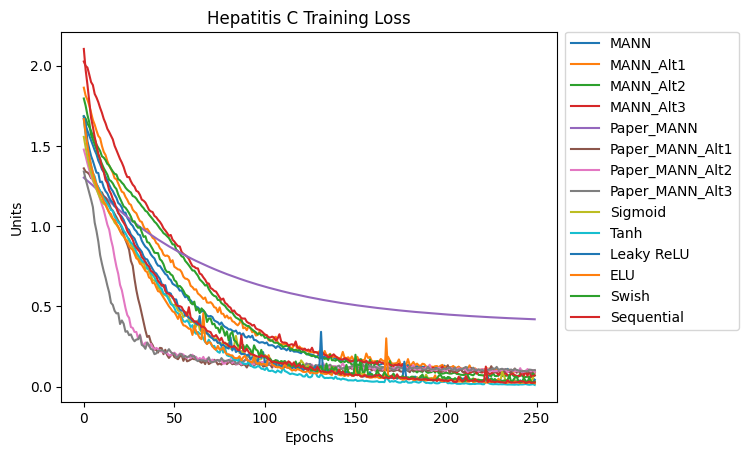

In [277]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')

plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['loss'], label='MANN_Alt1')

plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['loss'], label='MANN_Alt2')

plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['loss'], label='MANN_Alt3')

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3')


plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')

plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')

plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')

plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')

plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')

plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')

plt.title('Hepatitis C Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

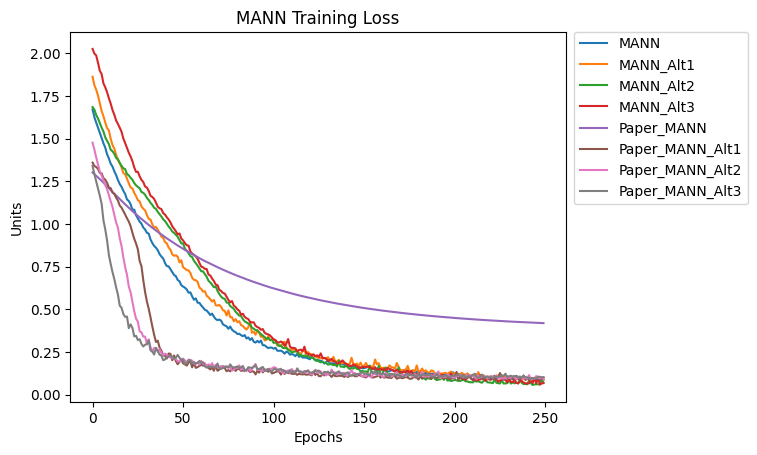

In [278]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')

plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['loss'], label='MANN_Alt1')

plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['loss'], label='MANN_Alt2')

plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['loss'], label='MANN_Alt3')

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3')

plt.title('MANN Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

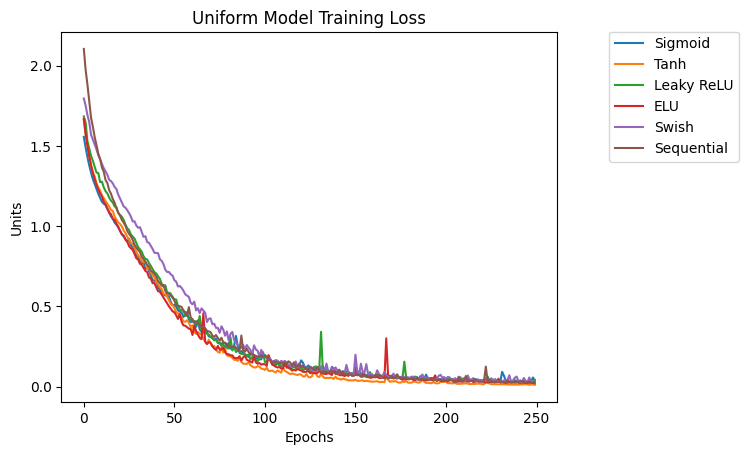

In [279]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')

plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')

plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')

plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')

plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')

plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')

plt.title('Uniform Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

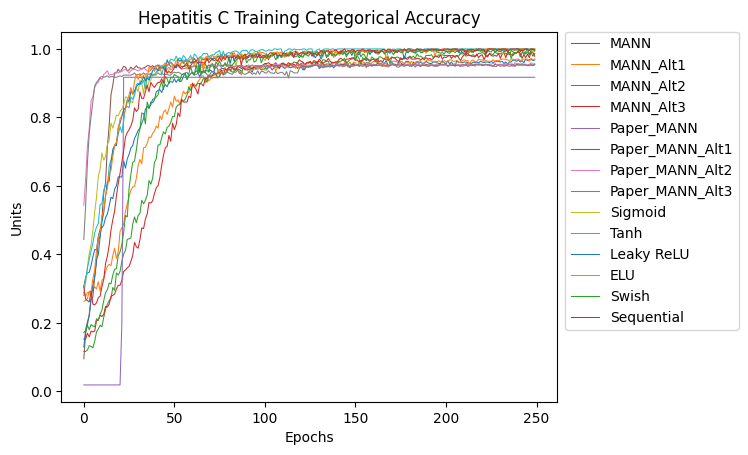

In [280]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Hepatitis C Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

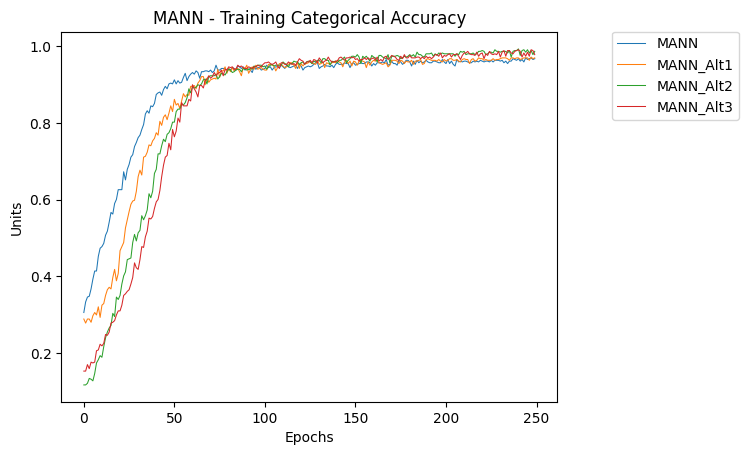

In [281]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('MANN - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

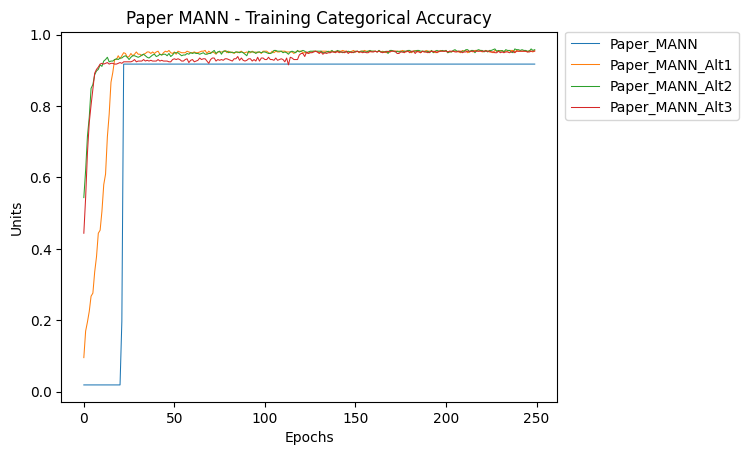

In [282]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Paper MANN - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

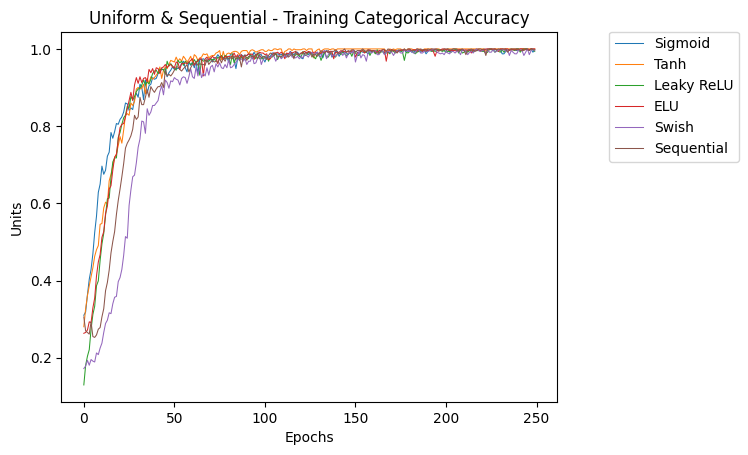

In [283]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Uniform & Sequential - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

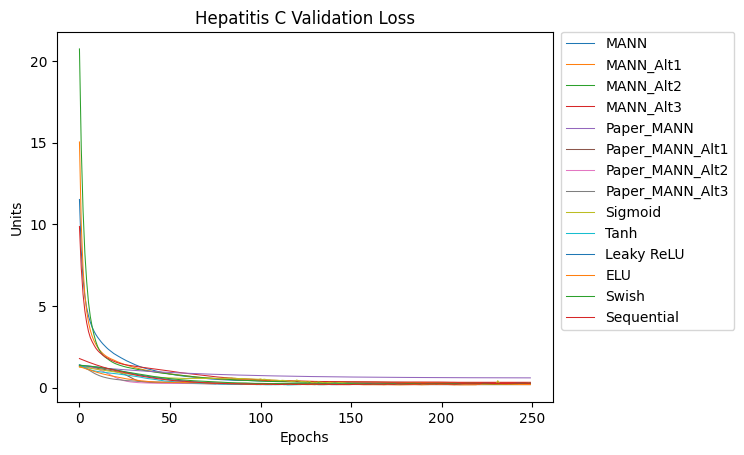

In [284]:
# Plot the validation loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['val_loss'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['val_loss'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['val_loss'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['val_loss'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['val_loss'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['val_loss'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['val_loss'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['val_loss'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['val_loss'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['val_loss'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['val_loss'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['val_loss'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['val_loss'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['val_loss'], label='Sequential', linewidth=0.75)

plt.title('Hepatitis C Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')
#plt.ylim([0,1.5])
plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

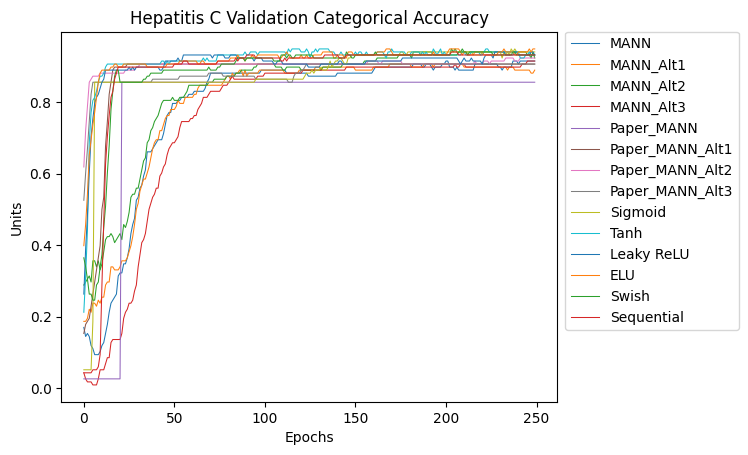

In [285]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['val_categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['val_categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['val_categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['val_categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['val_categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['val_categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['val_categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['val_categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['val_categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['val_categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['val_categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['val_categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['val_categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['val_categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Hepatitis C Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

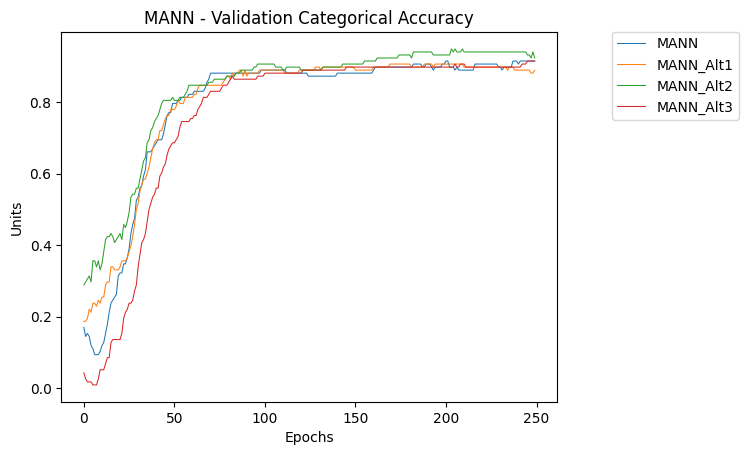

In [286]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['val_categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['val_categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['val_categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['val_categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('MANN - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

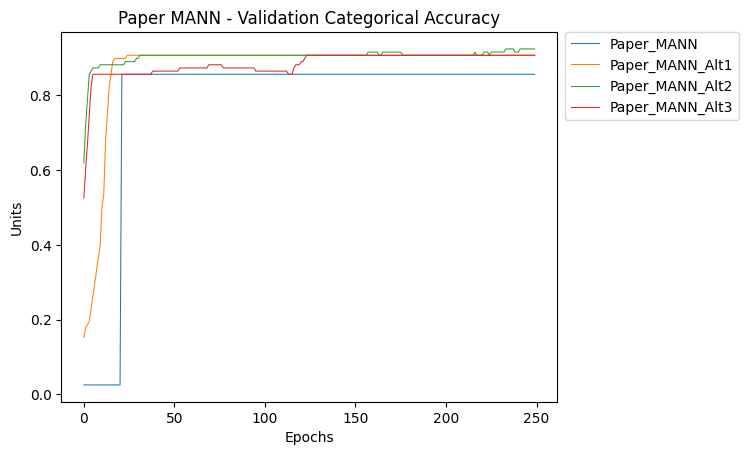

In [287]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['val_categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['val_categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['val_categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['val_categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Paper MANN - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

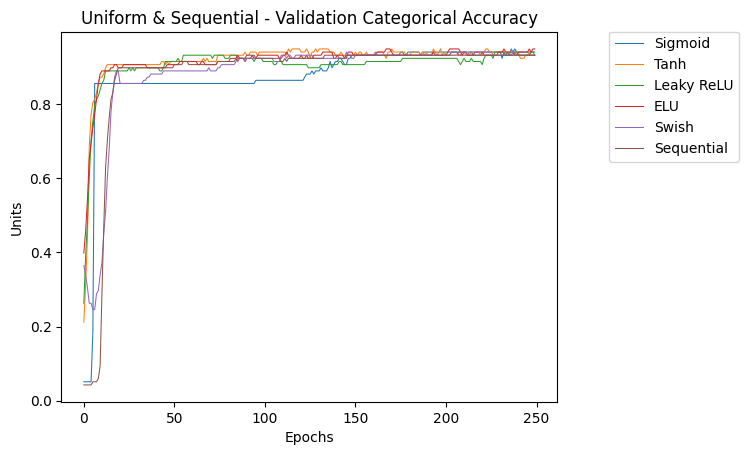

In [288]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['val_categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['val_categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['val_categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['val_categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['val_categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['val_categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Uniform & Sequential - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

In [289]:
# Save training history
train_hist_df = pd.DataFrame()
val_hist_df = pd.DataFrame()
for name, callback in histories.items():
    train_hist_df = pd.concat((train_hist_df, pd.DataFrame(callback.history['loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    val_hist_df = pd.concat((val_hist_df, pd.DataFrame(callback.history['val_loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    
train_hist_df.to_csv('Binary.training_hist.csv')
val_hist_df.to_csv('Binary.validation_hist.csv')

In [290]:
# Get performance metrics for each model
# Get the testing loss for each model
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, one_hot.inverse_transform(y_train).ravel())

metric = keras.metrics.CategoricalAccuracy()
metric.update_state(y_test.to_numpy(), one_hot.transform(log_reg.predict(X_test).reshape(-1,1)))
log_reg_loss = metric.result().numpy()

MANN_loss = models['MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt1_loss = models['MANN_Alt1'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt2_loss = models['MANN_Alt2'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt3_loss = models['MANN_Alt3'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Paper_MANN_loss = models['Paper_MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt1_loss = models['Paper_MANN_Alt1'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt2_loss = models['Paper_MANN_Alt2'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt3_loss = models['Paper_MANN_Alt3'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Sigmoid_loss = models['Sigmoid'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Tanh_loss = models['Tanh'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

LeakyReLU_loss = models['LeakyReLU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

ELU_loss = models['ELU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Swish_loss = models['Swish'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Sequential_loss = models['Sequential'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

4/4 [==============================] - 0s 4ms/step - loss: 0.2636 - categorical_accuracy: 0.9322


In [291]:
# Save metrics to a table and display results
# Save testing loss to table and display results
results = pd.DataFrame([MANN_loss, MANN_Alt1_loss, MANN_Alt2_loss, MANN_Alt3_loss, Paper_MANN_loss, Paper_MANN_Alt1_loss, Paper_MANN_Alt2_loss, Paper_MANN_Alt3_loss,Sigmoid_loss, Tanh_loss, LeakyReLU_loss, ELU_loss, Swish_loss, Sequential_loss],
                      index=['MANN', 'MANN_Alt1', 'MANN_Alt2', 'MANN_Alt3', 'Paper MANN', 'Paper Alternate MANN 1', 'Paper Alternate MANN 2', 'Paper Alternate MANN 3', 'Sigmoid NN', 'Tanh NN', 'Leaky ReLU NN', 'ELU NN', 'Swish NN', 'Sequential NN'],
                      columns=['Categorical Accuracy'])
results.sort_values('Categorical Accuracy', inplace=True, ascending=False)
results.head(20)

Categorical Accuracy
ELU NN                              0.949153
Sigmoid NN                          0.940678
Tanh NN                             0.932203
Leaky ReLU NN                       0.932203
Swish NN                            0.932203
Sequential NN                       0.932203
MANN_Alt2                           0.923729
Paper Alternate MANN 2              0.923729
MANN                                0.915254
MANN_Alt3                           0.915254
Paper Alternate MANN 1              0.906780
Paper Alternate MANN 3              0.906780
MANN_Alt1                           0.889831
Paper MANN                          0.855932

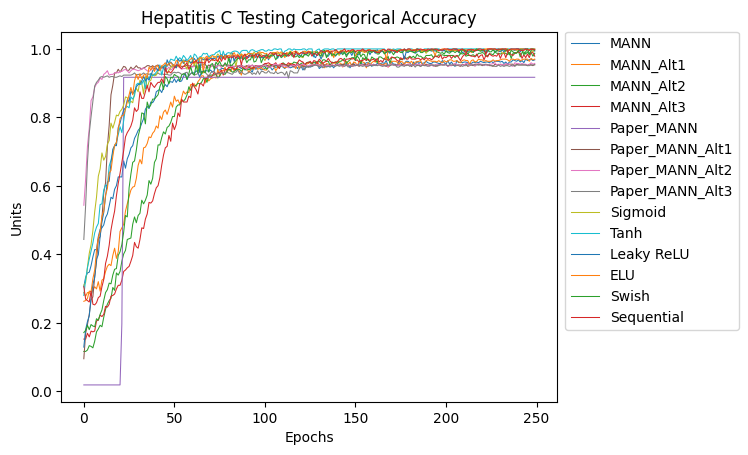

In [292]:
# Plot the Testing Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Hepatitis C Testing Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

# 

# 